# Analyzing Text Entries for User Expertise

- Analysis of amazon product reviews - more specifically electronics data.

Data source => "http://jmcauley.ucsd.edu/data/amazon/"

where

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [122]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [123]:
import pandas as pd
import gzip

"""def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Electronics_5.json.gz')"""

"def parse(path):\n  g = gzip.open(path, 'rb')\n  for l in g:\n    yield eval(l)\n\ndef getDF(path):\n  i = 0\n  df = {}\n  for d in parse(path):\n    df[i] = d\n    i += 1\n  return pd.DataFrame.from_dict(df, orient='index')\n\ndf = getDF('reviews_Electronics_5.json.gz')"

In [124]:
#saving AvgwordtoVec
"""with open('electronics_df.pickle', 'wb') as f:
    pickle.dump(df, f)"""

"with open('electronics_df.pickle', 'wb') as f:\n    pickle.dump(df, f)"

In [125]:
#Retrieving AvgwordtoVec
with open('electronics_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [126]:
df.head()

reviewerID        asin              reviewerName   helpful  \
0   AO94DHGC771SJ  0528881469                   amazdnu    [0, 0]   
1   AMO214LNFCEI4  0528881469           Amazon Customer  [12, 15]   
2  A3N7T0DY83Y4IG  0528881469             C. A. Freeman  [43, 45]   
3  A1H8PY3QHMQQA0  0528881469  Dave M. Shaw "mack dave"   [9, 10]   
4  A24EV6RXELQZ63  0528881469               Wayne Smith    [0, 0]   

                                          reviewText  overall  \
0  We got this GPS for my husband who is an (OTR)...      5.0   
1  I'm a professional OTR truck driver, and I bou...      1.0   
2  Well, what can I say.  I've had this unit in m...      3.0   
3  Not going to write a long review, even thought...      2.0   
4  I've had mine for a year and here's what we go...      1.0   

                                  summary  unixReviewTime   reviewTime  
0                         Gotta have GPS!      1370131200   06 2, 2013  
1                       Very Disappointed      1290643200  11 25, 2010  
2                          1st impression      1283990400   09 9, 2010  
3                 Great grafics, POOR GPS      1290556800  11 24, 2010  
4  Major issues, only excuses for support      1317254400  09 29, 2011

In [127]:
df.shape

(1689188, 9)

In [128]:
df.count()

reviewerID        1689188
asin              1689188
reviewerName      1664458
helpful           1689188
reviewText        1689188
overall           1689188
summary           1689188
unixReviewTime    1689188
reviewTime        1689188
dtype: int64

In [129]:
df['asin'].value_counts()

B007WTAJTO    4915
B003ES5ZUU    4143
B00DR0PDNE    3798
B0019EHU8G    3435
B002WE6D44    2813
B003ELYQGG    2652
B0002L5R78    2599
B009SYZ8OC    2542
B00BGGDVOO    2104
B002V88HFE    2082
B0074BW614    2069
B000LRMS66    1960
B006GWO5WK    1917
B000QUUFRW    1890
B005FYNSPK    1884
B005HMKKH4    1866
B0041Q38NU    1812
B00622AG6S    1710
B004QK7HI8    1581
B005DKZTMG    1564
B000VX6XL6    1556
B001XURP7W    1485
B004XC6GJ0    1456
B004G6002M    1424
B0052SCU8U    1419
B000S5Q9CA    1393
B000BQ7GW8    1388
B002MAPRYU    1374
B005CT56F8    1365
B006W8U2MU    1339
              ... 
B000021YUL       5
B002ASBQOE       5
B003VSOQ1W       5
B0007QN86U       5
B001F6W7TK       5
B009S4GZQC       5
B0035AOOMC       5
B00006DY6J       5
B0031WIX7G       5
B000DZFT1C       5
B002PY7OF8       5
B000V8AWFY       5
B00D2D46S4       5
B000BQPH7Y       5
B000WQ0MTG       5
B004YW7W10       5
B00009R9BV       5
B007HF8XB4       5
B004P354L8       5
B00DPYPYTK       5
B000WN4RJA       5
B002XXT1RU  

"B007WTAJTO" => https://www.amazon.com/dp/B007WTAJTO
SanDisk Ultra 64GB MicroSDXC Class 10 UHS Memory Card Speed Up To 30MB/s With Adapter - SDSDQUA-064G-U46A

In [130]:
#df_sandisk=df[df.asin == 'B007WTAJTO' ]

In [131]:
#saving AvgwordtoVec
"""import pickle
with open('sandisk_df.pickle', 'wb') as f:
    pickle.dump(df_sandisk, f)"""

"import pickle\nwith open('sandisk_df.pickle', 'wb') as f:\n    pickle.dump(df_sandisk, f)"

In [132]:
#Retrieving AvgwordtoVec
with open('sandisk_df.pickle', 'rb') as f:
    df_sandisk = pickle.load(f)

In [133]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  
1336614                              Four Stars      1406073600  07 23, 2014  
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013  
1336616               nothing to really say....      1356220800  12 23, 2012  
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013  
1336618                        best deal around      1373673600  07 13, 2013

In [134]:
df_sandisk["reviewerID"].value_counts()

A7GSAXOHLDDYP     1
A3LOC24GCZBZ0N    1
A1I4O9Q7XPAG8C    1
A186WJ3EFN42GH    1
A1IFHNPYI6G3MM    1
AFUZA5L0OBGX6     1
A2PZJVZGK4PXXT    1
AUD6EV5XIKX6B     1
A69R0HD1TKHAK     1
AFM65NU0UXIGP     1
AJM8T3W3A0BLY     1
A2ROZ33LXZBSVI    1
A2O2ZKPV2J0JUG    1
A3SRDVCD2ATIIS    1
A246LL40AOOY5J    1
A1PYJMLUQ1JDUB    1
A3DKXGMGKVFVZW    1
A1HCWV68E20S0F    1
AZQ1O9ZVCJT0J     1
ARRJAV2KHRXIM     1
A2JNBBSGJFN7EF    1
AR4HIS9SJ1JSX     1
A2T077JYCTRL60    1
A1S2P2BIQVLDN3    1
AJ67I7HOUWI1M     1
A249KJSBUPW7RC    1
A2AVY1038B8KT2    1
A13MPH77KVE9NH    1
A1VRFFNOMLSENT    1
A20Y224WRCNFTH    1
                 ..
A124DIYEKRO9EO    1
A2O96COBMVY9C4    1
A18NOHFD1NRXHB    1
A2OZG897EZJ84U    1
A2I39WJIGIDSJG    1
A2UY3K9AVPRIRQ    1
A1NAAI0SBO3FBA    1
AZUG7T2XYSI7A     1
A75ZDN2NDVIYR     1
A1EDPCGXJ43801    1
AZV2U6GU5QA6C     1
A18P98QS2M3K6Z    1
A2EC99EZ7ENIW5    1
AWP5F6CCNM1LZ     1
A24BKH5ZCTZ4CG    1
A165WJDRP7ZJYS    1
A3SKJFXH1MTCHJ    1
A254VIZ8VNFFHZ    1
AEKNT5K9X1ZI1     1


# Hence No Duplicates and as said in the website "De duplication has been done"

In [135]:
df_sandisk[df_sandisk.astype(str).sum(axis=1).str.contains("class") == 1]

reviewerID        asin                           reviewerName  \
1336629  A29RI184HRX66H  B007WTAJTO                          Aaron "Aaron"   
1336640  A1U9QJQW3XPRL2  B007WTAJTO                         Aaron T. Swain   
1336660   AGX2K0FMS0IVL  B007WTAJTO                            AC500Driver   
1336681  A1OM05JSG2J1KB  B007WTAJTO                                 adavey   
1336689  A2KJY8F5O1U5D6  B007WTAJTO                              A. Felson   
1336703  A1JOXGZH55JMHW  B007WTAJTO                              A. Hejazi   
1336707   A837QPVOZ9YAD  B007WTAJTO                                Airedad   
1336708  A1PKJZRYCZFIGJ  B007WTAJTO                                  ajb03   
1336711  A20MEC7JYD5U11  B007WTAJTO                 A.J.O. From California   
1336714  A2CHQH95XQUY4E  B007WTAJTO                                 ak2012   
1336733   ATE41IMLCAC2H  B007WTAJTO                            Al Campbell   
1336737  A1UM44ILLZCEI1  B007WTAJTO                 Aleksandar Milivojevic   
1336754  A1OKTNPURCNYKX  B007WTAJTO                                    A.L   
1336768  A3LBEV0UWH9V2G  B007WTAJTO                                  Allen   
1336794   A3ACC82B33MGX  B007WTAJTO   Amazon Customer "ElectricalEngineer"   
1336814  A2XKRQ2IM5XS9A  B007WTAJTO                        Amazon Customer   
1336817  A26EB0MDHMDD5U  B007WTAJTO                        Amazon Customer   
1336856  A20ZOIIWZU6G6H  B007WTAJTO                        Amazon Customer   
1336865  A3DXCQV1U6QLTS  B007WTAJTO                        Amazon Customer   
1336883  A2Z2ANFDUJBB9R  B007WTAJTO                        Amazon Customer   
1336886   AK3D1F2TEULT0  B007WTAJTO                        Amazon Customer   
1336892  A149EPYL6YG1EI  B007WTAJTO                        Amazon Customer   
1336899   ABFBA039H3S1Z  B007WTAJTO                        Amazon Customer   
1336921  A3KZUJLA2X2LLC  B007WTAJTO                        Amazon Customer   
1336973   ACDHXI72HS6AR  B007WTAJTO                            Amazon User   
1336989  A1SGIBL61P776R  B007WTAJTO                                ANDR D.   
1337032  A361M14PU2GUEG  B007WTAJTO           Angry Ryan "Ryan A. Forrest"   
1337050   AWATUDXT8A7TA  B007WTAJTO                          Anthony Nonya   
1337082  A22W6XTBU8S6XA  B007WTAJTO                                 ART005   
1337083  A2EF13B4GOOVRR  B007WTAJTO                          ART D "ART D"   
...                 ...         ...                                    ...   
1341084  A2VJ5ALN1BIV3B  B007WTAJTO                      terster "Terster"   
1341096   AXOKMY2J7E2LY  B007WTAJTO                            tgreenwaldt   
1341097   A8IMDXXLZVN5M  B007WTAJTO             ThaCooLoser "CooLoserTech"   
1341116   AK6AKMA3147X0  B007WTAJTO                             The Lor **   
1341126  A17INQNCZ1HMHL  B007WTAJTO                             TheSnowman   
1341134  A2NI78TLCLF7Z2  B007WTAJTO                                 Thomas   
1341136  A3S1OWJEYYW8QY  B007WTAJTO         Thomas King "internet shopper"   
1341157   AAEVGE52KL0DJ  B007WTAJTO                                    Tim   
1341197  A3VZH0PWLQ9BB1  B007WTAJTO                                 Tom B.   
1341198  A1C00XXCYWEKK1  B007WTAJTO                                  Tombo   
1341210  A1WTQUOQ4WG9AI  B007WTAJTO            Tom Henriksen "Doggy Diner"   
1341215   AOSMOGUP5XN7V  B007WTAJTO          Tommy Dee "EnglishmanHi Tech"   
1341232  A2N2PJLAVS6TSJ  B007WTAJTO                                 Tony Z   
1341261  A3UBFIZWLK674O  B007WTAJTO                              Trip "SC"   
1341262   ABMF4UC4Z00NT  B007WTAJTO                                 trlamb   
1341273   ABAPF3XY1W6JX  B007WTAJTO                          TucsonShopper   
1341296   A4K1YGL2AXS9F  B007WTAJTO                                  Tyson   
1341315  A280KHZO2L7GKA  B007WTAJTO                                 V. Aub   
1341316   AIVU1J51MJ9O2  B007WTAJTO               Vaughn "The answer man!"   
1341333  A3KF3RWPANR3FI  B007WTAJTO

In [136]:
df_sandisk.shape

(4915, 9)

In [137]:
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
stop

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arjun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [138]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [139]:
TechPhrases = ["portable flash memory","speed","capacity","expand storage","SDSC", "kb",
               "SDHC","SDXC","SDIO","mm","miniSD","miniSDHC","miniSDIO","microSD",
               "microSDHC","microSDXC","MB","specifications","GB","transfer rate",
               "MB/s","FAT12","FAT16","FAT16B","file systems","transfer rates",
               "FAT32","exFAT","Speed Class","Seq Writes","UHS","FAT",
               "Video Speed Class","Ideal Workload","recording","playback","fps",
               "data transfer rates","advancements","Class","classification",
               "minimum sequential","write speed", "IOPS" , "giga", "bytes","Ultra series",
               "capacities","flash card provider","adapter", "Evo", "Ultra",
               "pricing","availability","affordablility","benchmarks","SanDisk Extreme",
               "read","write rates","non-Select","compliance","Sony","Lexar","solid state drives",
               "SSD","memory chips","Samsung","branded","Random Read","Random Write","Ideal Workload",
               "Editing","updating app data","Application Class", "specification", "SDSQUAR" ]


In [140]:
bypass=['gb','kb','mb','mb/s','kb/s','gb/s','uhs', 'non-select',
        'fat16', 'fat16b', 'fat32', 'fps', 'mm', 'giga', 'mega', 'byte']

#bypass='\w\w\w\w'

'''if any part of [word.lower] matches any word in bypass then 
keep that word contverted to the corresposnding word in bypass, n the list.'''

'''if "blah" not in somestring: 
    continue'''

'if "blah" not in somestring: \n    continue'

In [141]:
unigramTechSet = set();

for phrase in TechPhrases:
    for w in phrase.split():
        w = w.lower()
        for i in bypass:
            if w.find(i) == -1:
                continue
            else:
                w= i
            unigramTechSet.add(w);
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c))
                        unigramTechSet.add(s);
                    else:
                        continue
            else:
                    continue
        
    
print(unigramTechSet)

{'minisd', 'class', 'video', 'solid', 'avail', 'drive', 'samsung', 'extrem', 'sdsquar', 'specif', 'random', 'fps', 'read', 'complianc', 'sequenti', 'minisdhc', 'mm', 'workload', 'provid', 'memori', 'fat', 'portabl', 'sdio', 'storag', 'affordablil', 'rate', 'sdsc', 'exfat', 'classif', 'iop', 'fat32', 'applic', 'fat16', 'speed', 'minimum', 'mb', 'record', 'sandisk', 'microsd', 'seq', 'giga', 'uh', 'evo', 'price', 'benchmark', 'app', 'expand', 'adapt', 'kb', 'non-select', 'minisdio', 'sdxc', 'gb', 'lexar', 'write', 'microsdxc', 'microsdhc', 'state', 'ultra', 'edit', 'byte', 'uhs', 'card', 'flash', 'playback', 'capac', 'file', 'ideal', 'system', 'data', 'advanc', 'seri', 'chip', 'ssd', 'brand', 'updat', 'soni', 'transfer', 'sdhc'}


In [142]:
count_each = []
final_string=[]
s=''
str_full = '';
for sent in tqdm(df_sandisk['reviewText'].values):
    count = 0;
    filtered_sentence=[]
    print("#############################################################")
    print(sent)
    for w in sent.split():
        for i in bypass:
            if w.lower().find(i) == -1:
                continue
            else:
                w= i
        #if re.match('\w\w\w\w', w, flags=0):
            s = w.encode('utf8');
            filtered_sentence.append(s)
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c)).encode('utf8')
                        filtered_sentence.append(s)
                        if(sno.stem(c) in unigramTechSet):
                            count = count + 1;
                    else:
                        continue
            else:
                    continue
    print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    count_each.append(count)
    final_string.append(str1)

  0%|                                                                                         | 0/4915 [00:00<?, ?it/s]

#############################################################
No issues.
[b'issu']
#############################################################
Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.
[b'purchas', b'devic', b'work', b'advertis', b'never', b'much', b'phone', b'memori', b'sinc', b'download', b'lot', b'stuff', b'brainer']
#############################################################
it works as expected. I should have sprung for the higher capacity.  I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before
[b'work', b'expect', b'sprung', b'higher', b'capac', b'think', b'made', b'bit', b'cheesier', b'earlier', b'paint', b'look', b'clean']
#############################################################
This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I h

got this because i had a 2 GB one that filled up. i kept getting the insufficient disk space on my phone. my kids take my phone and do selfies. mostly my daughter. I had to get a bigger card. the 2GB one was a carry over from an old phone.needless to say this was sweet. plenty of space. and i dont have to delete pictures anymore. well for now at least.my daughter loves selfies.
[b'got', b'gb', b'one', b'fill', b'kept', b'get', b'insuffici', b'disk', b'space', b'phone', b'kid', b'take', b'phone', b'selfi', b'most', b'daughter', b'get', b'bigger', b'card', b'gb', b'one', b'carri', b'old', b'phone', b'needless', b'say', b'sweet', b'plenti', b'space', b'dont', b'delet', b'pictur', b'anymor', b'well', b'least', b'daughter', b'love', b'selfi']
#############################################################
Class 10 Speed Rating for Seamless Full HD VideoThe SanDisk Ultra UHS-I card features a Class 10 and UHS Speed Class 1 (U1) rating, the highest video performance available for recording unin

  1%|▍                                                                              | 25/4915 [00:00<00:20, 243.37it/s]

#############################################################
Installed in my Blackberry Q10 SQN100-1 and formatted. Works just fine. Plenty of storage space for pictures and videos of my son at the park.
[b'instal', b'kb', b'format', b'work', b'fine', b'plenti', b'storag', b'space', b'pictur', b'video', b'son', b'park']
#############################################################
I just received my card, it is the class 10 64GB with the correct serial#SDSDQUA-064G-A11A. I received it in an unopened SanDisk packaging. I am going to use it on my HTC Rezound, I hope it works. From what I have read, it will work after reformatting the disk. I will update this review if I have any issues using it, if not, my rating will remain unchanged...
[b'receiv', b'card', b'class', b'gb', b'correct', b'receiv', b'unopen', b'sandisk', b'packag', b'go', b'use', b'htc', b'rezound', b'hope', b'work', b'read', b'work', b'reformat', b'disk', b'updat', b'review', b'issu', b'use', b'rate', b'remain', b'uncha

[b'bougth', b'micro', b'card', b'trubl', b'got', b'kingston', b'tell', b'sandisk', b'qualiti', b'best', b'phone', b'read', b'gb', b'fast', b'dta', b'transfer', b'speed', b'amaz', b'look', b'addit', b'storag', b'phone', b'music', b'pictur', b'type', b'file', b'good', b'qualiti', b'materi', b'speedupd', b'one', b'year', b'memori', b'damag', b'delet', b'put', b'new', b'file', b'format', b'memori', b'tri', b'format', b'phone', b'camera', b'noth', b'like', b'gb', b'data', b'memori', b'avail', b'read', b'move', b'delet', b'bought', b'memori', b'use', b'backup', b'data', b'android', b'devic', b'readabl', b'memori', b'write', b'data', b'hope', b'sandisk', b'make', b'better', b'product', b'futur', b'total', b'disagre', b'buy', b'samsung', b'memori', b'card', b'expect', b'better', b'qualiti']
#############################################################
Using this in a contout gps camera,  don't waste your time buying any other brand it will be a waste. Buy the best to start with.
[b'use', b'con

  1%|▊                                                                              | 50/4915 [00:00<00:20, 240.57it/s]

#############################################################
A memory card either works or it doesn't. This was always going to be a one star or five star review - no middle ground.The adapter is a nice bonus too, though I don't think I have anything to use it with.
[b'memori', b'card', b'either', b'work', b'doesnt', b'alway', b'go', b'one', b'star', b'five', b'star', b'review', b'middl', b'ground', b'adapt', b'nice', b'bonus', b'though', b'dont', b'think', b'anyth', b'use']
#############################################################
I purchased this card to use in my ContourROAM2 and it works great.  All I had to do was put the card in the camera, format it, and I was good to go.  It allows me to easily record hours of 720p/60fps video without running out of space or slowing down.
[b'purchas', b'card', b'use', b'work', b'great', b'put', b'card', b'camera', b'format', b'good', b'allow', b'easili', b'record', b'hour', b'fps', b'fps', b'video', b'without', b'run', b'space', b'slow']
#

[b'gb', b'storag', b'new', b'asus', b'tablet', b'what', b'love', b'cant', b'imagin', b'pay', b'model', b'upgrad', b'storag', b'especi', b'sinc', b'usual', b'like', b'thing', b'cheap', b'work', b'great']
#############################################################
excellent quality, excellent speed. no complaints here. very easy to use, reliable and the red stripe on the front makes it easy to find on a crowded desk
[b'excel', b'qualiti', b'excel', b'speed', b'complaint', b'easi', b'use', b'reliabl', b'red', b'stripe', b'front', b'make', b'easi', b'find', b'crowd', b'desk']
#############################################################
This card advertises itself as UHS1 but it's actually UHS50.This means that it will not go up to SDR104 speeds/throughput.Not necessary bad, just false advertising.
[b'card', b'advertis', b'uhs', b'uh', b'actual', b'uhs', b'uh', b'mean', b'speed', b'throughput', b'necessari', b'bad', b'fals', b'advertis']
##################################################

  1%|█                                                                              | 67/4915 [00:00<00:24, 197.75it/s]

#############################################################
A lot of people want big memory which is fine. But you need to look at speed class. This one is class 10. Which is great when your taking pictures or video. It will not freeze because it can move the MB/s fast enough. Lesser speed cards will freeze or will say waiting for camera and you will miss the moment. Its also a Sandisk which is a name you can trust when it come to memory cards.
[b'lot', b'peopl', b'want', b'big', b'memori', b'fine', b'need', b'look', b'speed', b'class', b'one', b'class', b'great', b'take', b'pictur', b'video', b'freez', b'move', b'mb', b'fast', b'enough', b'lesser', b'speed', b'card', b'freez', b'say', b'wait', b'camera', b'miss', b'moment', b'also', b'sandisk', b'name', b'trust', b'come', b'memori', b'card']
#############################################################
fast transfer rates, I downloaded about 2GB of videos form the card to my laptop through a card reader, all in about a minute
[b'fas

**Update 6.24.14**My 128 GB card stopped allowing writes via any of my card-readers on a Windows PC--either when it was inside any of several full-size SD card adapters (with the write-protect tab in either position) or plugged directly into the microSD slot of the reader.  MicroSD cards have no write-protect tab, so I was quite surprised and worried by this.  After failing to find any workable solution by searching online, I finally put it in my Chromebook and created a new folder on it there, then stuck it back in my Windows PC and it no longer gave me a write-protect error.  If anyone has a similar problem, I'd recommend doing something similar by putting it in any other PC, laptop, camera, etc you have available and try writing to it there.----------------------------------------------This portion of my review is necessarily being written as an update to my original review of the 64 GB version of this card, since Amazon disallows multiple reviews for what they consider the same ite

#############################################################
Bought this for my S3 and loaded it with 4 seasons of Futurama, 5 full length HD movies, several documentaries, and a dozen or so 30 minute comedy shows with plenty of room left over for pictures, etc...Only slight nitpick is when booting up into recovery mode on the S3 it will not recognize the card. Wanted to update the phone to the latest version of Android and it would not see it. Had to resort to a 2GB MicroSD I had laying around. That wasn't a SD card issue but I thought I would throw that in.
[b'bought', b'load', b'season', b'futurama', b'full', b'length', b'movi', b'sever', b'documentari', b'dozen', b'minut', b'comedi', b'show', b'plenti', b'room', b'left', b'pictur', b'etc', b'slight', b'nitpick', b'boot', b'recoveri', b'mode', b'recogn', b'card', b'want', b'updat', b'phone', b'latest', b'version', b'android', b'would', b'see', b'resort', b'gb', b'microsd', b'lay', b'around', b'wasnt', b'card', b'issu', b'thought', 

  2%|█▍                                                                             | 87/4915 [00:00<00:24, 196.24it/s]

#############################################################
High speed, high capacity of storage. Great durability. I use in my phone and in my digital camera. Work very good
[b'high', b'speed', b'high', b'capac', b'storag', b'great', b'durabl', b'use', b'phone', b'digit', b'camera', b'work', b'good']
#############################################################
THis memory helps me to keep all what I want to keep on my cell phone.It is a good brand and its on the right price.
[b'memori', b'help', b'keep', b'want', b'keep', b'cell', b'phone', b'good', b'brand', b'right', b'price']
#############################################################
I bought this SD card for my android phone thinking that a class 10 will be faster and more reliable than others. it turns out, the difference in class doesn't really matter at least for Android phones. didn't really worth the price difference
[b'bought', b'card', b'android', b'phone', b'think', b'class', b'faster', b'reliabl', b'other', b'turn',

The Ultra micro SDHC was fine once I got it working. Neither the packaging nor the Sansa Clip player inform the user that the player needs to be totally off before the microcard is inserted. If not, the unit will not read the card!  Otherwise? Love it and the storage for even 16 GB, let alone 32, is tremendous...
[b'ultra', b'micro', b'sdhc', b'fine', b'got', b'work', b'neither', b'packag', b'sansa', b'clip', b'player', b'inform', b'user', b'player', b'need', b'total', b'microcard', b'insert', b'unit', b'read', b'card', b'otherwis', b'love', b'storag', b'even', b'gb', b'let', b'alon', b'tremend']
#############################################################
I upgraded to this after the price dropped. I originally had a 16gig sandisk card and it was in my mytouch 4g. I found toward my mytouch 4g's end of life that space is running low. So when I got my Galaxy S3 I bought this card. It works flawlessly. I highly recommend it. Now errors what so ever. Super fast transfer rate.
[b'upgrad',

  2%|█▋                                                                            | 108/4915 [00:00<00:30, 157.60it/s]

#############################################################
It works but the actual R/W speeds are 18/8 MB/s, not even Class 10. It should be marketed as "Sandisk Basic", not Sandisk Ultra", unless they mean ultra slow. Now is 2014 and there is no excuse for such slow card from Sandisk.*** UPDATE ***I have redone the test with NotePro 12.2" instead of using non UHS-I PC and the latest results are 32/8.6MB/s. Since the read speed hits 30, I believe the device is DHS-I ready. Still underwhelmed by the write speed though.
[b'work', b'actual', b'speed', b'mb', b'even', b'class', b'market', b'sandisk', b'basic', b'sandisk', b'ultra', b'unless', b'mean', b'ultra', b'slow', b'excus', b'slow', b'card', b'sandisk', b'updat', b'redon', b'test', b'notepro', b'instead', b'use', b'non', b'uhs', b'uh', b'latest', b'result', b'mb', b'sinc', b'read', b'speed', b'hit', b'believ', b'devic', b'readi', b'still', b'underwhelm', b'write', b'speed', b'though']
##############################################

Update: providing an update with regard to SanDisk support.I bought the memory card in Aug 2012 (see original review below). In May of 2013 while on my cruise to Alaska the card went bad. During the sailing out of San Francisco it was fine as I used it to take a panorama shot of the Golden Gate Bridge. For most of the cruise I was using my DSLR but the next time I wanted to use my cell phone, the phone told me I had no memory card loaded.  Any way, tested the card on my laptop when I got back and it couldn't recognize it. I contacted SanDisk via email and provide them copy of my receipt from Amazon along with the serial number on the back of the card (very hard to read) and no problems; they told me to send them back the card and they sent me a brand new card which is now still functioning in my cell phone.  Great support provide by SanDisk. No hassle as long as you can provide proof of purchase (easy to do since Amazon keeps my entire purchase history/invoices online).  One reason I b

I bought 64GB version of the card to use with GoPro Hero 3 black edition.  It didn't work out.  The card worked OK if camera was set to resolution with lower bit rates.  E.g. worked fine in 720p with protune on, or 1080p with protune off.  However, in 1080p with protune on (bitrate is just shy of 6 MB/s in this mode -- much higher then with protune turned off) it was nothing but trouble.  Camera would sometime work, and sometime randomly stop recording for no obvious reason.  I first suspected camera, but testing with different SD cards, it ended up being SanDisk's card that was at fault.  My spare card, an old and cheap 16GB PNY (also class 10), worked just fine under same conditions and with same camera settings.Once it was obvious it was problem with the card, I found people on GoPro's forums that had trouble with this specific card as well (well, you always find these only after you figure it out for yourself, right?).  Anyhow, I did some speed tests with the card by doing simple w

#############################################################

[]


  3%|█▉                                                                            | 126/4915 [00:00<00:29, 162.94it/s]

#############################################################
My husband and I bought this for our GoPro and we used to to record our vacation to Mexico. We still have more than half of the space left!
[b'husband', b'bought', b'gopro', b'use', b'record', b'vacat', b'mexico', b'still', b'half', b'space', b'left']
#############################################################
This item is what it is; I've been using it for a few months now and it records HD videos in my GoPro Hero3 without problems.
[b'item', b'ive', b'use', b'month', b'record', b'video', b'gopro', b'without', b'problem']
#############################################################
This is my third purchase. I own 4 of them and they've been working fine so far. I have them installed on my smart phone, cameras and even used as a portable storage device and I have not noticed any issues with them. Very good product.
[b'third', b'purchas', b'theyv', b'work', b'fine', b'far', b'instal', b'smart', b'phone', b'camera', b'even'

[b'come', b'nice', b'littl', b'adapt', b'microsdhc', b'use', b'normal', b'size', b'card', b'also', b'pretti', b'neat', b'consid', b'price', b'gb', b'pretti', b'reason', b'class', b'fast', b'video', b'record', b'dslr', b'camera', b'bought', b'use', b'gopro', b'take', b'pictur', b'video', b'work', b'great', b'didnt', b'give', b'anycorrupt', b'file', b'video', b'pictur', b'yet', b'work', b'pretti', b'good', b'pretti', b'reliabl', b'brand', b'wont', b'abl', b'wrong']
#############################################################
Great value, plenty of storage for both my phone & tablet!  I looked around and this is a really good deal.
[b'great', b'valu', b'plenti', b'storag', b'phone', b'tablet', b'look', b'around', b'realli', b'good', b'deal']
#############################################################
Shipped fast and worked really well!  I use this just in case I have to take a lot of photos! Loads fast!
[b'ship', b'fast', b'work', b'realli', b'well', b'use', b'case', b'take', b'lot', 

  3%|██▍                                                                           | 150/4915 [00:00<00:32, 147.83it/s]

#############################################################
Used it in my Galaxy Note 2 for the past 16 months. All the sudden it is no longer writable. I tried many ways to reformat the card. Even Windows says format successful but all files remain after I remove and re-insert the card. Since I have private files in the card I'm not able to delete. I do not want to sent it back to SanDisk for replacement.
[b'use', b'galaxi', b'note', b'past', b'month', b'sudden', b'longer', b'writabl', b'tri', b'mani', b'way', b'reformat', b'card', b'even', b'window', b'say', b'format', b'success', b'file', b'remain', b'remov', b'card', b'sinc', b'privat', b'file', b'card', b'abl', b'delet', b'want', b'sent', b'back', b'sandisk', b'replac']
#############################################################
Usual SanDisk quality worked as expected and delivered on time, no problems worked great on my Android Samsung Tablet.
[b'usual', b'sandisk', b'qualiti', b'work', b'expect', b'deliv', b'time', b'proble

I bought this for my Raspberry Pi.  It is large enough to run a full LAMP server.  The price / speed are a good bargain.
[b'bought', b'raspberri', b'larg', b'enough', b'run', b'full', b'lamp', b'server', b'price', b'speed', b'good', b'bargain']
#############################################################
it is very good, thanks SanDisk,you must have it with gopro cam to get the benefit of cam, yap.
[b'good', b'thank', b'sandisk', b'must', b'gopro', b'cam', b'get', b'benefit', b'cam', b'yap']
#############################################################
I use this for a Raspberry Pi, in the SD adapter, and it works so far.Also appeared to be the genuine part, although the prolific Sandisk counterfeiters have gotten really sneaky in recent years.I like getting MicroSDHC cards because they can be adapted to different device sizes.  For example, let's say I buy a used phone or e-reader that needs a memory card, and I'm not using my Pi -- I can just take the Pi's card, take it out of the a

  4%|██▊                                                                           | 174/4915 [00:01<00:28, 165.79it/s]

#############################################################
I bought this on August of 2013.  As of April 2014 the card stopped functioning.  It can still be read, but the writing capability is gone.  That's less than one year.  I'm extremely disappointed in the longevity of this card.  My usage of it has been on my Galaxy S4.  I have about 40Gb of data in it.  Guess I'm going to have to look for another card that has a longer lifespan than this one.
[b'bought', b'august', b'april', b'card', b'stop', b'function', b'still', b'read', b'write', b'capabl', b'gone', b'that', b'less', b'one', b'year', b'extrem', b'disappoint', b'longev', b'card', b'usag', b'galaxi', b'gb', b'data', b'guess', b'go', b'look', b'anoth', b'card', b'longer', b'lifespan', b'one']
#############################################################
Why would you get anything less?  64GB of instantaneous movies, video, music or pictures.  If you have an Android phone that's capable of accepting micro SD cards go ahead an

My Samsung Galaxy Note 2 came with 8 gigs of internal memory. I discovered that apps can only be written to the internal 8 gigs of memory so I didn't want to fill up the internal memory with pictures, videos, music, etc.  I purchased the 64 GB San Disk Ultra MicroSDXC Class 10 card. I found a video on youtube to learn how to insert the card since I could find nothing on it in the phone's user guide.  It's real easy. Turn the Note phone off. Remove the Note's back plate. You see a plaque saying SD card in the upper left quadrant of the phone. Simply place the microsd card face up with the metallic pins facing down and towards the right into the depressed slot area to the left of the SD card plaque. Then slowly and gently slide the microsd card under the plaque until it clicks. If it isn't in correctly, it will tend to move back out from under the plaque. Do not force. Replace the back plate on the phone. Turn the phone on.  Go to settings, storage.  At the bottom of the page, you will s

  4%|███                                                                           | 191/4915 [00:01<00:35, 134.36it/s]

#############################################################
Arrived quickly and in perfect condition.  It works well with my camera using its standard size adapter and then is readable by my Note 8.  Seems quick enough for my Canon G12.  I would recommend this.
[b'arriv', b'quick', b'perfect', b'condit', b'work', b'well', b'camera', b'use', b'standard', b'size', b'adapt', b'readabl', b'note', b'seem', b'quick', b'enough', b'canon', b'would', b'mm']
#############################################################
Big card, a lot faster than the card that came with my phone. Allows me to switch to video and take pics faster. If you are going to get a cloud storage program think about just getting a couple big cards instead makes downloading and accessing chunks of data a lot easier.
[b'big', b'card', b'lot', b'faster', b'card', b'came', b'phone', b'allow', b'switch', b'video', b'take', b'pic', b'faster', b'go', b'get', b'cloud', b'storag', b'program', b'think', b'get', b'coupl', b'big', b

  4%|███▎                                                                          | 209/4915 [00:01<00:32, 144.12it/s]

#############################################################
Great value for extra storage on cell phones. Adapter included with memory disk allows easy interface with standard computer card reader interfaces.
[b'great', b'valu', b'extra', b'storag', b'cell', b'phone', b'adapt', b'includ', b'memori', b'disk', b'allow', b'easi', b'interfac', b'standard', b'comput', b'card', b'reader', b'interfac']
#############################################################
Had to return this item, it would not fit properly into the adapter that it came with.  Return was no problem, but I am reluctant to buy another one.
[b'return', b'item', b'would', b'fit', b'proper', b'adapt', b'came', b'return', b'problem', b'reluct', b'buy', b'anoth', b'one']
#############################################################
haven't been able to use this in the capacity that I bought it, for a tablet pro, but I have used it in a usb adapter and it works well there.
[b'havent', b'abl', b'use', b'capac', b'bought', b'ta

I had no issue using this with all of the above devices. It is still working strong and I trust SanDisk with all my gear including memory for DSLR use. Had not malfunctioned throughout many different uses and I trust this brand. Although it is more expensive as supposed to other brands, but they are worth extra in my opinion.
[b'issu', b'use', b'devic', b'still', b'work', b'strong', b'trust', b'sandisk', b'gear', b'includ', b'memori', b'dslr', b'use', b'malfunct', b'throughout', b'mani', b'differ', b'use', b'trust', b'brand', b'although', b'expens', b'suppos', b'brand', b'worth', b'extra', b'opinion']
#############################################################
I have a lot of music and pictures and keeping them on the card frees up storage for apps that cannot use the card.  Money well spent.
[b'lot', b'music', b'pictur', b'keep', b'card', b'free', b'storag', b'app', b'cannot', b'use', b'card', b'money', b'well', b'spent']
#############################################################

  5%|███▌                                                                          | 227/4915 [00:01<00:30, 152.61it/s]

#############################################################
I just got a Note 3 and while 32gb is great...who wouldn't want another 64gb?  This SD card does what I want it to do and I'm happy with it.
[b'got', b'note', b'gb', b'great', b'wouldnt', b'want', b'anoth', b'gb', b'card', b'want', b'happi']
#############################################################
I like things that work and I like things that work the way they're sold to me and when they do I give it a great review so trust me when I say this works and you won't find a faster SD card out there.
[b'like', b'thing', b'work', b'like', b'thing', b'work', b'way', b'theyr', b'sold', b'give', b'great', b'review', b'trust', b'say', b'work', b'wont', b'find', b'faster', b'card']
#############################################################
I love this storage unit. I would buy again definitely. Great for pix, videos, docs, or whatever you want to store. I have  it in my ME173x.
[b'love', b'storag', b'unit', b'would', b'buy', b'

Is very stable and when i use this product in my samsung galaxy 7, sometimes the tablet don't recongnize the memory but the problem is maybe the tablet not the memory i think
[b'stabl', b'use', b'product', b'samsung', b'galaxi', b'sometim', b'tablet', b'dont', b'recongn', b'memori', b'problem', b'mayb', b'tablet', b'memori', b'think']
#############################################################
it is an almost required piece for my Samsung tablet.  it was at a good buy. :-)it is easy to use, and easy to install.
[b'almost', b'requir', b'piec', b'samsung', b'tablet', b'good', b'buy', b'easi', b'use', b'easi', b'instal']
#############################################################
it's a class 10 so it's pretty fast.  I am using it in my HTC EVO LTE 4G phone hoping that it had UHS-1 capability.  It doesnt seem to so it's just a class 10.
[b'class', b'pretti', b'fast', b'use', b'htc', b'evo', b'lte', b'phone', b'hope', b'uhs', b'uh', b'capabl', b'doesnt', b'seem', b'class']
############

  5%|███▊                                                                          | 244/4915 [00:01<00:36, 126.37it/s]

#############################################################
It works as Expected. No problems installing or anything. It fits my Samsung S4. It shipped really fast and was in packaging that I could open without the use of something sharp.
[b'work', b'expect', b'problem', b'instal', b'anyth', b'fit', b'samsung', b'ship', b'realli', b'fast', b'packag', b'could', b'open', b'without', b'use', b'someth', b'sharp']
#############################################################
I use this in my Galaxy Note 3 and seems to work just fine.  I love having lots of memory and the price was good.
[b'use', b'galaxi', b'note', b'seem', b'work', b'fine', b'love', b'lot', b'memori', b'price', b'good']
#############################################################
I use this in my Samsung Galaxy Note II. For the money, it's a fantastic value. I haven't noticed any transfer speed issues, and it's been rock-solid reliable for the 3 months I've owned it. I have about 32GB of music stored on it, and every ap

[b'keep', b'short', b'sweet', b'potenti', b'buyer', b'look', b'fact', b'two', b'gb', b'size', b'card', b'month', b'work', b'fair', b'well', b'cell', b'phone', b'tablet', b'yet', b'good', b'camera', b'fact', b'card', b'fail', b'work', b'gopro', b'camera', b'custom', b'servic', b'rep', b'gopro', b'claim', b'happen', b'agre', b'card', b'true', b'class', b'card', b'let', b'alon', b'uhs', b'uh', b'evo', b'alloc', b'size', b'write', b'speed', b'never', b'pass', b'beyond', b'mb', b'read', b'speed', b'wonder', b'around', b'mb', b'far', b'advertis', b'speed', b'well', b'write', b'speed', b'arent', b'technic', b'advertis', b'probabl', b'class', b'level', b'benchmark', b'crystal', b'mark', b'report', b'speed', b'even', b'lower', b'due', b'adapt', b'write', b'speed', b'around', b'mb', b'read', b'speed', b'wonder', b'around', b'mb', b'say', b'worri', b'speed', b'storag', b'perfect', b'want', b'use', b'shoot', b'high', b'definit', b'raw', b'footag', b'howev', b'suggest', b'loos', b'money', b'even', 

  5%|████▏                                                                         | 262/4915 [00:01<00:33, 138.54it/s]

#############################################################
So I'm not going to pretend to be an expert on sd cards, but I still like this one. It is relatively inexpensive, works wonderfully for the movies I want to store and watch on my samsung galaxy tab 7 2.0, and I haven't had a single problem with storage yet.
[b'go', b'pretend', b'expert', b'card', b'still', b'like', b'one', b'relat', b'inexpens', b'work', b'wonder', b'movi', b'want', b'store', b'watch', b'samsung', b'galaxi', b'tab', b'havent', b'singl', b'problem', b'storag', b'yet']
#############################################################
Still working with no problems so far, so it seems to be reliable. Not sure what else to say, but they want more words.
[b'still', b'work', b'problem', b'far', b'seem', b'reliabl', b'sure', b'els', b'say', b'want', b'word']
#############################################################
The card arrived promptly and has worked flawlessly in a dashcam. Would recommend purchase to others 

[b'best', b'accessori', b'buy', b'smartphon', b'simpl', b'load', b'movi', b'onto', b'micro', b'card', b'insert', b'samsung', b'galaxi', b'play', b'superbl', b'without', b'delay', b'mb', b'read', b'import', b'reason', b'best', b'accessori', b'phone', b'think', b'premium', b'pay', b'iphon', b'gb', b'price', b'pay', b'gb', b'micro', b'card', b'depend', b'amazon', b'price', b'time', b'mean', b'get', b'thing', b'less', b'interchang', b'card', b'devic', b'buy', b'new', b'tablet', b'exampl', b'brainer', b'note', b'read', b'mb', b'gb', b'movi', b'take', b'minut', b'load']
#############################################################
This is the biggest memory card I have at 32 gig.  It works fine!  I am using it on an 8 inch Dell tablet with Windows 8 and a solid state 8 gig hard drive.
[b'biggest', b'memori', b'card', b'gig', b'work', b'fine', b'use', b'inch', b'dell', b'tablet', b'window', b'solid', b'state', b'gig', b'hard', b'drive']
########################################################

  6%|████▍                                                                         | 278/4915 [00:01<00:39, 116.46it/s]

#############################################################
This provides plenty of storage capacity for your tablet and mobile devices - I've put this into all my cellphones and Android tablets. After twelve months of use, downloading music, videos, apps - there is plenty of room left.The class 10 version is also great for phone/tablet cameras as well for a stand alone camera (yes I still use a digital camera - so yesterday). This is a must for HD action video camera/recorder as well. The price continues to drop so it is very affordable now - unless your device can take the 64Gb version - I'd go with the higher capacity for video recording devices.
[b'provid', b'plenti', b'storag', b'capac', b'tablet', b'mobil', b'devic', b'ive', b'put', b'cellphon', b'android', b'tablet', b'twelv', b'month', b'use', b'download', b'music', b'video', b'app', b'plenti', b'room', b'left', b'class', b'version', b'also', b'great', b'phone', b'tablet', b'camera', b'well', b'stand', b'alon', b'camera', b'y

Would not work in my Samsung Galaxt Tab 2 7.0 3G that I purchased it for.  But it does work fine in my Asus TF700. So I swapped the cards between them and everythings's OK.  First time I've seen this with a Sandisk product.
[b'would', b'work', b'samsung', b'galaxt', b'tab', b'purchas', b'work', b'fine', b'asus', b'swap', b'card', b'everythingss', b'first', b'time', b'ive', b'seen', b'sandisk', b'product']
#############################################################
Does what it says. Hasn't broken yet, and I hope it doesn't break. I've had luck with this brand before. Usually get bored with the product before it breaks.
[b'say', b'hasnt', b'broken', b'yet', b'hope', b'doesnt', b'break', b'ive', b'luck', b'brand', b'usual', b'get', b'bore', b'product', b'break']
#############################################################
My card got so hot it almost melted. Crazy! But you card somewhere else, I know I Wii! I'm not taking the chance of ruining one of my devices. No thanks
[b'card', b'

  6%|████▋                                                                         | 297/4915 [00:01<00:35, 131.28it/s]

#############################################################
Got this for the Dell Venue 8 Pro and it works perfectly. No complaints. Here are more words to complete my review.
[b'got', b'dell', b'venu', b'pro', b'work', b'perfect', b'complaint', b'word', b'complet', b'review']
#############################################################
I bought this the day it came out for the great price of $119.99 and it finally showed up a month later. (I knew this going in). I put it in my Galaxy note 3 and it instantly recognized it and I was set.Speeds in my laptop via the included adapter ranged from 15-30mb read speed and about 12mb write speed. I copied an entire 64 GB card over to this one, and it took some time, but now I have double the space.
[b'bought', b'day', b'came', b'great', b'price', b'final', b'show', b'month', b'later', b'knew', b'go', b'put', b'galaxi', b'note', b'instant', b'recogn', b'set', b'speed', b'laptop', b'via', b'includ', b'adapt', b'rang', b'mb', b'read', b'speed',

[b'micro', b'card', b'work', b'great', b'hero', b'black', b'edit', b'never', b'problem', b'sandisk', b'product', b'own']
#############################################################
This product was early coming in. It works great in my Samsung Galaxy Note 10.1 tablet. It's easy to upload and export items from multiple devices with the adapter that comes with it.
[b'product', b'earli', b'come', b'work', b'great', b'samsung', b'galaxi', b'note', b'tablet', b'easi', b'upload', b'export', b'item', b'multipl', b'devic', b'adapt', b'come']
#############################################################
I love this 64 GB microSD.  I dont ever have to think about it now.  I love that we can get such a large amount of memory for our devices.
[b'love', b'gb', b'microsd', b'dont', b'ever', b'think', b'love', b'get', b'larg', b'amount', b'memori', b'devic']
#############################################################
All the horror stories about SD memory not really being the density reported.  I

  6%|████▉                                                                         | 314/4915 [00:02<00:35, 129.15it/s]

#############################################################
It's worked great with my Galaxy S4 cell phone. Videos and photos taken with the phone automatically get stored to the memory card after it was installed as do may apps.  No issues.
[b'work', b'great', b'galaxi', b'cell', b'phone', b'video', b'photo', b'taken', b'phone', b'automat', b'get', b'store', b'memori', b'card', b'instal', b'may', b'app', b'issu']
#############################################################
Bought this card to use with my Samsung Galaxy Tab2 7in tablet, based on others who have reported getting it to work in their Galaxy Tab 2.Bottom line, you gotta reformat this card as FAT32 with 32kb sectors to work in the Galaxy Tab 2, and that requires jumping thru some hoops as Win6/Vista does not even offer the choice to format as FAT32, only as NTFS or exFAT, neither of which will work with the Galaxy Tab 2 (Android v4.04)  You have to use 3rd party software to accomplish this.  A FREE solution is the EaseUS

[b'pour', b'note', b'work', b'absolut', b'overtim', b'love', b'much', b'download', b'great', b'mani', b'pictur', b'audibl', b'book', b'amazon', b'mani', b'interest', b'mine', b'work', b'time', b'soon', b'found', b'gb', b'microcard', b'small', b'amazon', b'great', b'sale', b'gb', b'one', b'purchas', b'main', b'concern', b'would', b'work', b'phone', b'fast', b'enough', b'seamless', b'well', b'gb', b'microsdxc', b'class', b'whatev', b'sandisk', b'want', b'name', b'bottom', b'line', b'work', b'seamless', b'dont', b'get', b'nasti', b'warn', b'tell', b'memori', b'almost', b'full', b'nice', b'samsung', b'realiz', b'need', b'abl', b'use', b'larger', b'memori', b'card', b'note', b'allow', b'size', b'card', b'use', b'without', b'issu']
#############################################################
Gave to my Samsung galaxy note 10.1 the power to take and use it with any kind of application. Quick, easy, install and play.
[b'gave', b'samsung', b'galaxi', b'note', b'power', b'take', b'use', b'kind'

  7%|█████▎                                                                        | 334/4915 [00:02<00:31, 143.35it/s]

#############################################################
When I placed this in my Galaxy S4 phone it read it right away at 29.7 GB. Which is expected to loose a few GB. I transferred file from my old card and it was done fast. Although I didn't have large files to start with. I had been looking for a large card and this one fits the bill. The other reviews helped sway my choice. I would recommend this card, so far no issues.
[b'place', b'galaxi', b'phone', b'read', b'right', b'away', b'gb', b'expect', b'loos', b'gb', b'transfer', b'file', b'old', b'card', b'done', b'fast', b'although', b'didnt', b'larg', b'file', b'start', b'look', b'larg', b'card', b'one', b'fit', b'bill', b'review', b'help', b'sway', b'choic', b'would', b'mm', b'card', b'far', b'issu']
#############################################################
This itty, bitty SD card packs a whole lot of punch!When I saw how small this was, I was blown away.65GB in something the size of my pinkey fingernail, AMAZING!I have u

I just popped it in my Sony Xperia Tablet Z .  It works.  There is no sense that I will ever run out of room.  If I was using it for work that might be different, but I could just change with a new micro sd card.  I don't know why all tablets don't have a port for one.  I feel confident with the SanDisk brand.  I have never bought a bad SanDisk product.
[b'pop', b'soni', b'xperia', b'tablet', b'work', b'sens', b'ever', b'run', b'room', b'use', b'work', b'might', b'differ', b'could', b'chang', b'new', b'micro', b'card', b'dont', b'know', b'tablet', b'dont', b'port', b'one', b'feel', b'confid', b'sandisk', b'brand', b'never', b'bought', b'bad', b'sandisk', b'product']
#############################################################
I just bought two of these for our two new Samsung Galaxy IV smart phones.  The adapters will make it possible for the card readers on our computers to accept these MicroSD cards if we find it worthwhile to pull them out of the phone case rather than use the USB 

  7%|█████▋                                                                        | 355/4915 [00:02<00:33, 137.42it/s]

#############################################################
I join the long list of customers who have had their SanDisk die on them.  Customer service from SanDisk has been helpful.  They pay for UPS shipping for the return and promise a 7-10 day turn around once the defective disk has been returned.  Still it's a pain to deal with and I lost some photographs.UPDATE: SanDisk sent me a replacement and it seems to be working.  If the replacement goes bad, I'll be back to complain:)SECOND UPDATE: All is well with the replacement so I'm giving it three stars.
[b'join', b'long', b'list', b'custom', b'sandisk', b'die', b'custom', b'servic', b'sandisk', b'help', b'pay', b'up', b'ship', b'return', b'promis', b'day', b'turn', b'around', b'defect', b'disk', b'return', b'still', b'pain', b'deal', b'lost', b'photograph', b'sandisk', b'sent', b'replac', b'seem', b'work', b'replac', b'goe', b'bad', b'ill', b'back', b'second', b'well', b'replac', b'give', b'three', b'star']
#######################

#############################################################
had it in my samsung tablet and it went bad after 2 months, wont let me reformat or read it or do anything with it. money down the drain.
[b'samsung', b'tablet', b'went', b'bad', b'month', b'wont', b'let', b'reformat', b'read', b'anyth', b'money', b'drain']
#############################################################
I use the card with GoPro Black Edition and it is just enough to record some action while horse riding. I have always used SanDisk as recording cards and I am happy with the quality I get.
[b'use', b'card', b'gopro', b'black', b'edit', b'enough', b'record', b'action', b'hors', b'ride', b'alway', b'use', b'sandisk', b'record', b'card', b'happi', b'qualiti', b'get']
#############################################################
Purchased this for new Samsung S4 Active smart phone.  It worked perfectly, just installed it, no need to reformat.  I've put the amazon.com URL and description below with frustration free 

  8%|█████▉                                                                        | 372/4915 [00:02<00:31, 145.53it/s]

#############################################################
Still working fine in my Galaxy SII.  No complaints.  I do have a complaint about my Galaxy occasionally erasing everything on it, but I'm sure that's not the card's fault.
[b'still', b'work', b'fine', b'galaxi', b'sii', b'complaint', b'complaint', b'galaxi', b'occasion', b'eras', b'everyth', b'sure', b'that', b'card', b'fault']
#############################################################
Works just fine installed on my new MS Surface Pro...too bad Windows 8 user experience is lacking! Delivered and works as expected from SanDisk.
[b'work', b'fine', b'instal', b'new', b'surfac', b'pro', b'bad', b'window', b'user', b'experi', b'lack', b'deliv', b'work', b'expect', b'sandisk']
#############################################################
I got this for my Samsung Galaxy Note. After reading various reviews and comparing different micro SD cards, I decided to get this. One of the main reason was because of the speed of this car

[b'got', b'galaxi', b'work', b'well', b'good', b'speed', b'good', b'space', b'someth', b'definit', b'need', b'sometim', b'hard', b'time', b'get', b'recogn', b'comput', b'alway', b'find', b'way', b'make', b'work', b'ntfs', b'necessari', b'purpos']
#############################################################
I put this in my Verizon Samsung Galaxy Stellar and it works perfectly. This is an easy way to add memory for pictures, music and apps, etc, to the phone
[b'put', b'verizon', b'samsung', b'galaxi', b'stellar', b'work', b'perfect', b'easi', b'way', b'add', b'memori', b'pictur', b'music', b'app', b'etc', b'phone']
#############################################################
I have always had good luck with SanDisk products and am pleased with this memory, reliable and looks cool too.
[b'alway', b'good', b'luck', b'sandisk', b'product', b'pleas', b'memori', b'reliabl', b'look', b'cool']
#############################################################
Fast and Lots of storage, not a flims

  8%|██████▎                                                                       | 394/4915 [00:02<00:28, 159.96it/s]

#############################################################
I have bought it for around 6 months. It works good so far & both read / write speed meet the described specification.
[b'bought', b'around', b'month', b'work', b'good', b'far', b'read', b'write', b'speed', b'meet', b'describ', b'specif']
#############################################################
I'm using this card in a phone and so far I have no complaints. Access to the card by the camera and other applications seems fast enough.
[b'use', b'card', b'phone', b'far', b'complaint', b'access', b'card', b'camera', b'applic', b'seem', b'fast', b'enough']
#############################################################
Works well. Beware some of these SD cards are not what they say they are. This one is in my Nokia phone. Loaded maps and songs on it. No problem.
[b'work', b'well', b'bewar', b'card', b'say', b'one', b'nokia', b'phone', b'load', b'map', b'song', b'problem']
#########################################################

Performs as it is supposed to. 16gb is quite a lot of storage plus my Samsung Galaxy has 15 gb of internal memory for a total of 32 gb. That's plenty enough to store hundreds of hours of music,
[b'perform', b'suppos', b'gb', b'quit', b'lot', b'storag', b'plus', b'samsung', b'galaxi', b'gb', b'intern', b'memori', b'total', b'gb', b'that', b'plenti', b'enough', b'store', b'hundr', b'hour', b'music']
#############################################################
Purchased 2 of these for my Samsung Galaxy S4 (AT&T). The cards work without any issue; storing games, movies and music on them. I would recommend to anyone and would most definitely purchase these again without hesitation. As always, a big thanks to Amazon for 2 day shipping!
[b'purchas', b'samsung', b'galaxi', b'card', b'work', b'without', b'store', b'game', b'movi', b'music', b'would', b'mm', b'anyon', b'would', b'definit', b'purchas', b'without', b'hesit', b'alway', b'big', b'thank', b'amazon', b'day', b'ship']
################

  8%|██████▌                                                                       | 411/4915 [00:02<00:30, 145.45it/s]

#############################################################
For the price it was a great buy. I would recommend to all. It has a pretty high transfer rate, and comes with an adapter so you don't have to worry about that.
[b'price', b'great', b'buy', b'would', b'mm', b'pretti', b'high', b'transfer', b'rate', b'come', b'adapt', b'dont', b'worri']
#############################################################
Ordered this from Amazon and was expecting it to work perfectly like my other 32GB sandisk (in my galaxy s4). However, I was really disappointed that upon placing it in my note 10.1 2014 edition the card become unrecognizable. I tried reformatting on the computer, on the phone, and yet, no prevail. It could be the firmware or current update of android, but the point is that, if other companies can make a card that works, why not do the same? Maybe I got a bad batch, who knows...I went ahead and ordered the G.Skill microsd card and now it's working perfectly. I'm s
[b'order', b'amazo

Easy to install and performs per specs.  I have expanded the capacity of my handheld scanner with this product.  The convenience of these micro products is phenomenal!  I began my career in IT in the 70's and can attest to the truly wonderful progress tech has made over the years.  We do more with less--that's innovation, that's capitalism at its best!
[b'easi', b'instal', b'perform', b'per', b'spec', b'expand', b'capac', b'handheld', b'scanner', b'product', b'conveni', b'micro', b'product', b'phenomen', b'began', b'career', b'attest', b'truli', b'wonder', b'progress', b'tech', b'made', b'year', b'innov', b'that', b'capit', b'best']
#############################################################
I bought this card for my Phone. It gave me the extra storage for my pictures and video that I needed.
[b'bought', b'card', b'phone', b'gave', b'extra', b'storag', b'pictur', b'video', b'need']
#############################################################
It's fast and not too expensive, Still wo

  9%|██████▊                                                                       | 433/4915 [00:02<00:27, 160.24it/s]

#############################################################
I put the 32 GB card in my Galaxy S3 and it is working as well as could be. I popped the SD card into the slot, went to settings-> Storage-> and selected 'format'. That was it. Then I set up an Mp3 folder which was instantly recognized by double twist and now I have tons of storage for music, pics, and more. Great card.
[b'put', b'gb', b'card', b'galaxi', b'work', b'well', b'could', b'pop', b'card', b'slot', b'went', b'select', b'format', b'set', b'folder', b'instant', b'recogn', b'doubl', b'twist', b'ton', b'storag', b'music', b'pic', b'great', b'card']
#############################################################
After assuming I was stuck with a number of Micro SD adapters that didn't work I purchased the SanDisk Ultra card and low and behold everything started working. Even my wife's tablet that didn't recognize the SD cards movies started working. Bottom line it just works.
[b'assum', b'stuck', b'mb', b'micro', b'adapt'

A 32Gb micro mem card for the Samsung Galaxy S3 is a great addition to and S3 unit! Never a problem with his card and I can expect a long life out of this memory card too!
[b'gb', b'micro', b'mem', b'card', b'samsung', b'galaxi', b'great', b'addit', b'unit', b'never', b'problem', b'card', b'expect', b'long', b'life', b'memori', b'card']
#############################################################
It was for my new Galaxy note 2, I am not sure if I ever need one 64GB, but why not, when these is a bargain for one.
[b'new', b'galaxi', b'note', b'sure', b'ever', b'need', b'one', b'gb', b'bargain', b'one']
#############################################################
Got for my phone and is awesome.  The card did short out but once contacting SanDisk they had one out to me in a week.  Super awesome customer service.  Will buy more SanDisk items when needed.
[b'got', b'phone', b'awesom', b'card', b'short', b'contact', b'sandisk', b'one', b'week', b'super', b'awesom', b'custom', b'servic', b

  9%|███████▏                                                                      | 451/4915 [00:03<00:31, 142.96it/s]

#############################################################
it is extremely small. so small in fact, that it could easily get lost. so i recommend that once it's in, you leave it in. but it's a great idea, to allow the camera's, phone's or any other device to be that much smaller. i've only had it for a short while, but so far so good.
[b'extrem', b'small', b'small', b'fact', b'could', b'easili', b'get', b'lost', b'mm', b'leav', b'great', b'idea', b'allow', b'camera', b'phone', b'devic', b'much', b'smaller', b'ive', b'short', b'far', b'good']
#############################################################
No Samsung Galaxy S3 should be without one!  This should last me until 128 or 256 GB models become available. :)Does NOT fit the iPhone!  No iPhone can accept Micro SD memory upgrades.  Buy a Samsung phone instead!
[b'samsung', b'galaxi', b'without', b'one', b'last', b'gb', b'model', b'becom', b'avail', b'fit', b'iphon', b'iphon', b'accept', b'micro', b'memori', b'upgrad', b'buy', b's

Perfect card, all you need to keep all the action in this 64gb. I acquired this card for a GoPro camera and fits perfectly, its all you need to capture all the action when you need it.
[b'perfect', b'card', b'need', b'keep', b'action', b'gb', b'acquir', b'card', b'gopro', b'camera', b'fit', b'perfect', b'need', b'captur', b'action', b'need']
#############################################################
Bought this few days after I got my phone and it has great read and write speeds and it seems like taking care of some processing and handling of things within the phone. I changed the settings that every time I take a picture or record a video, it will go automatically to the microsd card. Added most of my movies in this tiny card and it works smoothly.
[b'bought', b'day', b'got', b'phone', b'great', b'read', b'write', b'speed', b'seem', b'like', b'take', b'care', b'process', b'handl', b'thing', b'within', b'phone', b'chang', b'set', b'everi', b'time', b'take', b'pictur', b'record', b'v

 10%|███████▌                                                                      | 474/4915 [00:03<00:27, 160.02it/s]

#############################################################
I purchased this to add storage to my Samsung Galaxy Note 3... and it works GREAT!Fast speed, easy snap-in install.  Not a moment's problem.Highly recommend this SanDisk Ultra 32 GB Micro SD to anyone planning to use with Smartphone or Tablet.
[b'purchas', b'add', b'storag', b'samsung', b'galaxi', b'note', b'work', b'greatfast', b'speed', b'easi', b'instal', b'moment', b'problem', b'high', b'mm', b'sandisk', b'ultra', b'gb', b'micro', b'anyon', b'plan', b'use', b'smartphon', b'tablet']
#############################################################
I haven't used it extensively at this point, but it holds my data well...as it should. SanDisk continues to be a solid brand.
[b'havent', b'use', b'extens', b'point', b'hold', b'data', b'well', b'sandisk', b'continu', b'solid', b'brand']
#############################################################
I have owned and used this in my Galaxy SIII for a few months now.  I have never had 

This card was used in a phone without a large amount of write stress (which does shorten the life of the card - it was not written to over and over in the phone).The card is now totally unwriteable - on a Mac, a Linux machine, or the phone - writes all "seem" to succeed but even low-level reformats don't actually *do* anything - the exact same files are there after every change, untouchable and frozen forever.10 months of use out of a memory card and then a really weird failure like this (neither the Mac, Linux machine, or phone reports any error) is not acceptable quality from SanDisk.
[b'card', b'use', b'phone', b'without', b'larg', b'amount', b'write', b'stress', b'shorten', b'life', b'card', b'written', b'phone', b'card', b'total', b'unwrit', b'mac', b'linux', b'machin', b'phone', b'write', b'seem', b'succeed', b'even', b'reformat', b'dont', b'actual', b'anyth', b'exact', b'file', b'everi', b'chang', b'untouch', b'frozen', b'forev', b'month', b'use', b'memori', b'card', b'realli', 

 10%|███████▊                                                                      | 492/4915 [00:03<00:30, 145.25it/s]

#############################################################
...and they're right!This microSDHC card is fast. I started formatting it a little behind another class 10 card (not a UHS-1) card and it formatted all 32GB ahead of the Transcend 16GB card - which is no slouch either! It's the fastest flash card I've sent yet. I doubt you will be disappointed unless you're an alien with more advanced technology.
[b'theyr', b'rightthi', b'microsdhc', b'card', b'fast', b'start', b'format', b'littl', b'behind', b'anoth', b'class', b'card', b'uhs', b'uh', b'card', b'format', b'gb', b'ahead', b'transcend', b'gb', b'card', b'slouch', b'either', b'fastest', b'flash', b'card', b'ive', b'sent', b'yet', b'doubt', b'disappoint', b'unless', b'your', b'alien', b'advanc', b'technolog']
#############################################################
I cannot gauge if its better or faster than a class 4 or 6. I use it in my mobile and it saves pictures just as quickly. Dont see a difference. But it has adver

[b'work', b'fine', b'verizon', b'galaxi', b'format', b'fat32', b'also', b'work', b'canon', b'ixus']
#############################################################
Still wondering how they fit 64,000,000,000 bites on a card like this. But this car is plenty fast and compatible with my devices.
[b'still', b'wonder', b'fit', b'bite', b'card', b'like', b'car', b'plenti', b'fast', b'compat', b'devic']
#############################################################
It has worked fine, so I have no complaints.  I've purchased SanDisk products several times and have been happy with this brand.
[b'work', b'fine', b'complaint', b'ive', b'purchas', b'sandisk', b'product', b'sever', b'time', b'happi', b'brand']
#############################################################
I've been used this prdoduct on the Past and it has great whit my Past Galaxy Note 2 for Store almost anything on my Device
[b'ive', b'use', b'prdoduct', b'past', b'great', b'whit', b'past', b'galaxi', b'note', b'store', b'almost', 

 11%|████████▏                                                                     | 517/4915 [00:03<00:26, 165.24it/s]

#############################################################
Whether I'm on vacation or just taking photos and videos around the house I don't trust any other memory cards to keep all my memories.  I bought this card mainly for my Contour ROAM 2 Helmet Cam, but I've been using SanDisk Compact Flash Cards in my Canon DSLR and SanDisk SD Cards in my Panasonic HMC40 video camera and I've never had a single problem.  They don't fail, I've never had a file corrupted, they've survived x rays at the airport and extreme weather conditions.  Sometimes I'm tempted with the prices of other memory cards but in the end I go with the SanDisk for that warm and fuzzy feeling of knowing all my photos and videos will be perfectly safe.
[b'whether', b'vacat', b'take', b'photo', b'video', b'around', b'hous', b'dont', b'trust', b'memori', b'card', b'keep', b'memori', b'bought', b'card', b'main', b'contour', b'roam', b'helmet', b'cam', b'ive', b'use', b'sandisk', b'compact', b'flash', b'card', b'canon', b'

Although it may be overkill for the application, considering its capacity, this appears to work very well for firmware memory for the Raspberry Pi, and at the price I bought it for on last year's Cyber-Monday, I wish I could buy a few more of them for the same price.  I haven't tried it with the RPi overclocked, but it's worked without a glitch at the normal RPi clock rate.  I've also used the 32GB version of this in my music player, and it has worked well also.
[b'although', b'may', b'overkil', b'applic', b'consid', b'capac', b'appear', b'work', b'well', b'firmwar', b'memori', b'raspberri', b'price', b'bought', b'last', b'year', b'wish', b'could', b'buy', b'price', b'havent', b'tri', b'rpi', b'overclock', b'work', b'without', b'glitch', b'normal', b'rpi', b'clock', b'rate', b'ive', b'also', b'use', b'gb', b'version', b'music', b'player', b'work', b'well', b'also']
#############################################################
Recently upgraded to Samsung Note II. I've been wanting to c

 11%|████████▌                                                                     | 536/4915 [00:03<00:30, 145.64it/s]

#############################################################
I use these for every project I work on.  It's a brand I trust and excited to continue with.  :)
[b'use', b'everi', b'project', b'work', b'brand', b'trust', b'excit', b'continu']
#############################################################
Stopped working and could not reformat.  Didn't have good luck with this item or the vendor selling this item.  Hopefully just a bad one...sandisk is usually pretty good
[b'stop', b'work', b'could', b'reformat', b'didnt', b'good', b'luck', b'item', b'vendor', b'sell', b'item', b'hope', b'bad', b'one', b'sandisk', b'usual', b'pretti', b'good']
#############################################################
I loaded this memory card into my TF700T and could not get it to install. I found it to be a format issue and could not reformat it to get it to work. I sent it back and got the class 10 sandisc card ( non ultra ) and it loaded perfactly.
[b'load', b'memori', b'card', b'could', b'get', b'i

Could not ask for anything more. It is exactly as advertised and I have no issues. I have not gotten to try it in a UHS device yet but cannot wait to do so.
[b'could', b'ask', b'anyth', b'exact', b'advertis', b'issu', b'gotten', b'tri', b'uhs', b'uh', b'devic', b'yet', b'cannot', b'wait']
#############################################################
Bought it for my S4; it Works like a charm.  No setup needed, my S4 reads it automatically.  Great price. :)
[b'bought', b'work', b'like', b'charm', b'setup', b'need', b'read', b'automat', b'great', b'price']
#############################################################
Bought this for my new Samsung digital camera. No complaints. It does what it's supposed to do, and I haven't noticed any problems with quality.
[b'bought', b'new', b'samsung', b'digit', b'camera', b'complaint', b'suppos', b'havent', b'notic', b'problem', b'qualiti']
#############################################################
I run this in my Samsung Galaxy II. Works like 

 11%|████████▉                                                                     | 561/4915 [00:03<00:29, 150.12it/s]

#############################################################
My S3 did not recognize card when it was formatted exFAT.  S3 seems to have problem supporting exFAT format in higher capacity like 32gb or 64gb.When I inserted the SD card, it just kept saying that SD card was "damaged" and I just got stuck on "Unmounting SD card" screen when I tried to format it on my phone.I just manually formatted the SD card to FAT32 in Windows 8 and inserted it into my phone.It runs smooth now.  Seems like a lot of people are having trouble to get the SanDisk 64gb to work in S3.  Hope this helps.
[b'recogn', b'card', b'format', b'exfat', b'seem', b'problem', b'support', b'exfat', b'format', b'higher', b'capac', b'like', b'gb', b'gb', b'insert', b'card', b'kept', b'say', b'card', b'damag', b'got', b'stuck', b'unmount', b'card', b'screen', b'tri', b'format', b'phone', b'manual', b'format', b'card', b'fat32', b'window', b'insert', b'phone', b'run', b'smooth', b'seem', b'like', b'lot', b'peopl', b'troubl',

[b'come', b'open', b'packag', b'box', b'includ', b'except', b'instruct', b'manual', b'warranti', b'use', b'cell', b'phone', b'work', b'great', b'read', b'write', b'speed', b'notic', b'faster', b'old', b'sandisk', b'gb', b'microsd']
#############################################################
Got this MicroSDXC for my GoPro. I've got more than enough space not to worry about changing my simcard, but more about changing my battery.
[b'got', b'microsdxc', b'gopro', b'ive', b'got', b'enough', b'space', b'worri', b'chang', b'simcard', b'chang', b'batteri']
#############################################################
See above.  Nice to have the extra room in my Blackberry Z30.  LOTS of content goes with me.  Packaging was adequate but not over-the-top.
[b'see', b'nice', b'extra', b'room', b'kb', b'lot', b'content', b'goe', b'packag', b'adequ']
#############################################################
Fast and reliable. So far no problems in my Samsung Galaxy S4 phone. Plus I got it on

 12%|█████████▎                                                                    | 588/4915 [00:03<00:25, 172.29it/s]

#############################################################
I purchased this to use in a Samsung Galaxy S3 phone. It worked fine for about a month, then the phone stopped recognizing it. I was able to copy my photos before the computer stopped recognizing it as well. SanDisk replaced it under warranty and so far the new one has been fine.
[b'purchas', b'use', b'samsung', b'galaxi', b'phone', b'work', b'fine', b'month', b'phone', b'stop', b'recogn', b'abl', b'copi', b'photo', b'comput', b'stop', b'recogn', b'well', b'sandisk', b'replac', b'warranti', b'far', b'new', b'one', b'fine']
#############################################################
I prefer the San Disk brand over other types.  This is a great size for phones & camera's.  I would buy again.
[b'prefer', b'san', b'disk', b'brand', b'type', b'great', b'size', b'phone', b'camera', b'would', b'buy']
#############################################################
I bought this for my husband and then the 32 GB one went on sale so 

[b'own', b'mani', b'card', b'past', b'probabl', b'best', b'bang', b'buck', b'ive', b'ever', b'receiv', b'card', b'super', b'nitpicki', b'data', b'read', b'write', b'speed', b'necessarili', b'card', b'plenti', b'fast', b'samsung', b'galaxi', b'note', b'pick', b'one', b'sale']
#############################################################
does very good..... holds a lot of songs......
[b'good', b'hold', b'lot', b'song']
#############################################################
Plugged in and worked out of the box in my Samsung Note 2 (Verizon).  Using an app to test the speed while it's in my Note, was hitting 8 - 15 mb/s for writing (avg high 8s), consistently in the 10mb/s for reading, so this seems like a legit class 10, and I don't think the write test really worked the greatest for whatever reason.  I'm with WinXP still, but to anyone else wondering, the exfat format the card comes in is what you want, don't format to fat32 if you computer can't read it, your phone/tablet/etc. mo

 12%|█████████▋                                                                    | 608/4915 [00:03<00:26, 161.23it/s]

#############################################################
Its in my GoPro and the memory card easily captures 2 hrs of video.It can get more the battery only lasts 2 hrs.
[b'gopro', b'memori', b'card', b'easili', b'captur', b'hrs', b'video', b'get', b'batteri', b'last', b'hrs']
#############################################################
Got it for my cell phone, Samsung Galaxy S4.  Works just like one would expect and appears to be quite fast.
[b'got', b'cell', b'phone', b'samsung', b'galaxi', b'work', b'like', b'one', b'would', b'expect', b'appear', b'quit', b'fast']
#############################################################
I like to keep track of the &#34;Daily Deals&#34; and check them almost daily (resulting in me spending more than I should), but this was too good of a deal to pass up.  I will be upgrading my cell phone soon, so I knew I would be needing it soon.  So, at $30 (with an adaptor and in retail packaging) I jumped at it and am glad I did!
[b'like', b'keep', b'

All I can say is, these are probably the best I could find, fast and furious!If you dont get class 10, you are taking the risk of dropped frames on your HD videos.besides they are pretty too!
[b'say', b'probabl', b'best', b'could', b'find', b'fast', b'furiousif', b'dont', b'get', b'class', b'take', b'risk', b'drop', b'frame', b'video', b'besid', b'pretti']
#############################################################
To begin, I am not that knowledgeable in tech matters so when I received a new Galaxy Note 2 as a gift and decided to add storage I read some reviews on the SD cards and was reading about the compatibility of the 64 GB cards (exFAT or Fat? I guess the exFAT was a successful diet), I was concerned somewhat but I ordered this one anyway and this is what my experience was. I added some music and videos onto the card using my Apple Macbook Air with no problems and then inserted it into the Note 2 with no problems and it immediately loaded everything with no problems. I have si

[b'lose', b'pictur', b'video', b'tune', b'month', b'samsung', b'galaxi', b'note', b'stock', b'android', b'look', b'like', b'mm', b'problem', b'tri', b'luck', b'sandisk', b'monday', b'dont', b'get', b'replac', b'never', b'buy', b'sandisk', b'product', b'paid', b'premium', b'sandisk', b'qualiti', b'disappoint', b'provid', b'replac', b'card', b'howev', b'data', b'loss', b'downtim', b'cannot', b'replac', b'sandisk', b'lost', b'premium', b'rate', b'eye', b'go', b'take', b'get', b'back']
#############################################################
I bought this card as high speed external memory for my Asus ME302C tablet to play movies, music, etc. The card meets all of my expectations, and was pleasantly surprised to discover that it had absolutely no crapware preloaded. No compatibility issues whatsoever.
[b'bought', b'card', b'high', b'speed', b'extern', b'memori', b'asus', b'tablet', b'play', b'movi', b'music', b'etc', b'card', b'meet', b'expect', b'pleasant', b'surpris', b'discov', b'a

 13%|██████████                                                                    | 631/4915 [00:04<00:24, 175.61it/s]

#############################################################
Works great with the GoPro camera!I can get about 3 days of kayaking video and photos on it.Price was fair.
[b'work', b'great', b'gopro', b'camerai', b'get', b'day', b'kayak', b'video', b'photo', b'price', b'fair']
#############################################################
This is great. I use this with my Contour Roam camera. Works great. lots of room for video. Transfer speeds are as expected.
[b'great', b'use', b'contour', b'roam', b'camera', b'work', b'great', b'lot', b'room', b'video', b'transfer', b'speed', b'expect']
#############################################################
Card works fine at 1080p on my Gopro Hero 3 plus.  Works great in my Transend USB 3.0 reader as well.
[b'card', b'work', b'fine', b'gopro', b'hero', b'plus', b'work', b'great', b'transend', b'usb', b'reader', b'well']
#############################################################
Came with adapter as described and works perfectly. I use this 

[b'purchas', b'gb', b'card', b'one', b'nokia', b'lumia', b'anoth', b'surfac', b'pro', b'devic', b'took', b'card', b'without', b'issu', b'read', b'write', b'speed', b'sure', b'better', b'option', b'gb', b'micro', b'card', b'avail', b'right', b'sandisk', b'amaz', b'job', b'product', b'current', b'long', b'sure', b'great', b'deal', b'consid', b'lot', b'good', b'card', b'rang', b'still', b'issu', b'either', b'card', b'unmount', b'put', b'transfer', b'file', b'your', b'good']
#############################################################
This card is doing its job in my S4. Lots of room for storing photos, music and videos. Good item.
[b'card', b'job', b'lot', b'room', b'store', b'photo', b'music', b'video', b'good', b'item']
#############################################################
Realistically I probably could have gotten away with a 16GB card, but like anything, it's better to have it and not need it than to need it and not have it. Popped it into my moblie phone an put all my music 

 13%|██████████▎                                                                   | 651/4915 [00:04<00:25, 168.61it/s]

#############################################################
I have nothing to use this device with. I ordered by mistake. I'm sure it's a great product but not for me.
[b'noth', b'use', b'devic', b'order', b'mistak', b'sure', b'great', b'product']
#############################################################
Bought this for the GoPro Hero3 and it works as advertised with no issues. Since I bought this, I have learned to watch for sales because they tend to get deeply discounted at local retailers every once in a while.
[b'bought', b'gopro', b'work', b'advertis', b'issu', b'sinc', b'bought', b'learn', b'watch', b'sale', b'tend', b'get', b'deepli', b'discount', b'local', b'retail', b'everi']
#############################################################
I could not get this brand of memory card to work in my Roku.  It would not format correctly.  I had to return this for another brand which worked ok.
[b'could', b'get', b'brand', b'memori', b'card', b'work', b'roku', b'would', b'format'

I'm a music lover and like to carry my entire music collection around with me everywhere I go. That being said it takes up A LOT of space, enough to fill a 64gb memory card on its own (a lot of the files are FLAC format.) I was a little hesitant to buy the 128gb card when it came out recently because with the 64gb cards the first batch were pretty much defective with resulted in a recall. Me, learning of the recall after looking up the issues I was having had to return the card I bought. SanDisk took the 64gb card back without hesitation and was actually prepared to do it without the serial number (since I couldn't open my phone at the time because the case is screwed on.)Note to everyone:Quite a few applications don't fully support NTFS or newer file system formats such as exFAT. To use your SD card without issues you have to format it to FAT32 which IS possible even though its over 32GB. Use the &#34;Fat32Format&#34; tool made by Ridgecrop Consultants, there's a GUI (Graphical User I

 14%|██████████▋                                                                   | 676/4915 [00:04<00:22, 186.14it/s]

#############################################################
I use this in my GPS Unit (Older model) and it works great! No complaints. I use a 16 GB in my phone and it's more than enough room! Pictures, music, etc.
[b'use', b'gps', b'unit', b'older', b'model', b'work', b'great', b'complaint', b'use', b'gb', b'phone', b'enough', b'room', b'pictur', b'music', b'etc']
#############################################################
I have been using this in my phone for several months.  Still works great. Seems fast however i have not done any real tests.
[b'use', b'phone', b'sever', b'month', b'still', b'work', b'great', b'seem', b'fast', b'howev', b'done', b'real', b'test']
#############################################################
I bought this to use as expanded storage in my Asus Transformer Book T100 but it was unstable and I have had to return it. Although the tablet would see the card when it was first inserted there would be errors trying to copy files onto it and then Windows 

Bought October 7th. Passed away December 23rd. RIP.I didn't really even use it because of the built in storage on my GS3. I had about 15 gb of music and movies on it, but only for when I was unexpectedly bored and without my zuneHd. On to the next brand I guess.
[b'bought', b'octob', b'pass', b'away', b'mb', b'rip', b'didnt', b'realli', b'even', b'use', b'built', b'storag', b'gb', b'music', b'movi', b'unexpect', b'bore', b'without', b'zunehd', b'next', b'brand', b'guess']
#############################################################
Bought this to use with my Samsung HMX W300. Works well, good transfer speeds and comes with a normal size SD card to transfer if needed.
[b'bought', b'use', b'samsung', b'hmx', b'work', b'well', b'good', b'transfer', b'speed', b'come', b'normal', b'size', b'card', b'transfer', b'need']
#############################################################
I purchased this memory card to use in my Samsung Galaxy S4 and it worked right out of the box. I haven't had a

 14%|███████████                                                                   | 696/4915 [00:04<00:24, 172.55it/s]

#############################################################
Fast transfer speed and got it for a great price. Used in my GoPro Hero 3 BE for many hours of recording and haven't had an issue.
[b'fast', b'transfer', b'speed', b'got', b'great', b'price', b'use', b'gopro', b'hero', b'mani', b'hour', b'record', b'havent', b'issu']
#############################################################
Fits my camera perfectly and gets me about 2 hours of video at highest resolution! I love how easy it is to use and the capacity is perfect for my needs.
[b'fit', b'camera', b'perfect', b'get', b'hour', b'video', b'highest', b'resolut', b'love', b'easi', b'use', b'capac', b'perfect', b'need']
#############################################################
holds a lot of memory. slides right into my car cam with no problem and easy to get out as well
[b'hold', b'lot', b'memori', b'slide', b'right', b'car', b'cam', b'problem', b'easi', b'get', b'well']
#####################################################

[b'pick', b'slam', b'phone', b'work', b'greatif', b'think', b'order', b'gig', b'largest', b'card', b'support']
#############################################################
This does not appear to work with the Samsung Galaxy S3.  It worked for a few weeks, then my phone started giving me "Unexpected Unmounted SD Card" error messages.  After a bit of searching, people seem to agree that the S3 and Sandisk micro SD cards do not work together.
[b'appear', b'work', b'samsung', b'galaxi', b'work', b'week', b'phone', b'start', b'give', b'unexpect', b'unmount', b'card', b'error', b'messag', b'bit', b'search', b'peopl', b'seem', b'agre', b'sandisk', b'micro', b'card', b'work', b'togeth']
#############################################################
I put this into my new tablet before I went on a long road trip and I was able to watch a few movies off of it during a 12 hour bus ride.
[b'put', b'new', b'tablet', b'went', b'long', b'road', b'trip', b'abl', b'watch', b'movi', b'hour', b'bus', b'

 15%|███████████▍                                                                  | 720/4915 [00:04<00:22, 186.37it/s]

#############################################################
Ever since my SanDisk Ultra 64GB Micro SDXC card arrived, my life has been pure bliss.  Not only am I finally able to carry vast amounts of music, movies, and TV shows with me on my Samsung Galaxy Note 8, but my car now gets 14 more MPG, my landlord LOWERED my rent $300, I got a promotion at work, and my cat no longer sheds on the furniture!
[b'ever', b'sinc', b'sandisk', b'ultra', b'gb', b'micro', b'sdxc', b'card', b'arriv', b'life', b'pure', b'bliss', b'final', b'abl', b'carri', b'vast', b'amount', b'music', b'movi', b'show', b'samsung', b'galaxi', b'note', b'car', b'get', b'mpg', b'landlord', b'lower', b'rent', b'got', b'promot', b'work', b'cat', b'longer', b'shed', b'furnitur']
#############################################################
Not going to go on a rant about apple, but sure glad other phones allow these TINY slots that quadruples the memory. I drop and dragged tons of my music to the SD card and Android just 

[b'microsd', b'card', b'made', b'great', b'upgrad', b'galaxi', b'storag', b'capac', b'card', b'perform', b'effici', b'read', b'write', b'give', b'phone', b'kind', b'data', b'storag', b'never', b'thought', b'anyon', b'look', b'enough', b'storag', b'space', b'phone', b'tablet', b'larg', b'amount', b'pictur', b'video', b'app', b'even', b'document', b'file', b'may', b'exact', b'your', b'look']
#############################################################
so fr it been great  i need it for my not 0. 2014 table  too bad it cost so much but  it is what it is
[b'great', b'need', b'tabl', b'bad', b'cost', b'much']
#############################################################
I bought this for my Samsung Galaxy Note 2.  It works perfectly with no strange behavior, great speed, and the SanDisk name to back it up.  Very happy with this purchase and highly recommend.
[b'bought', b'samsung', b'galaxi', b'note', b'work', b'perfect', b'strang', b'behavior', b'great', b'speed', b'sandisk', b'name', b'b

 15%|███████████▋                                                                  | 740/4915 [00:04<00:24, 172.70it/s]

#############################################################
They work great and I haven't had any issues with these cards.  I don't like using the adapters, but in a pinch I also used this in my Canon HS300 camera for 1080 video and photos with no issue.  They have very fast read/write speeds and have been quite reliable so far for me.
[b'work', b'great', b'havent', b'issu', b'card', b'dont', b'like', b'use', b'adapt', b'pinch', b'also', b'use', b'canon', b'camera', b'video', b'photo', b'issu', b'fast', b'read', b'write', b'speed', b'quit', b'reliabl', b'far']
#############################################################
I have had this for about a year and it has worked flawlessly.  I use it add to the capacity of my MacBook Air and it has given me 50% more storage space.  Great product.
[b'year', b'work', b'flawless', b'use', b'add', b'capac', b'macbook', b'air', b'given', b'storag', b'space', b'great', b'product']
#############################################################
I bou

[b'use', b'name', b'micro', b'card', b'phone', b'made', b'gb', b'class', b'realli', b'cheap', b'actual', b'didnt', b'give', b'problem', b'would', b'buy', b'anoth', b'one', b'heartbeat', b'anyway', b'son', b'want', b'game', b'psp', b'psp', b'actual', b'use', b'gb', b'card', b'adapt', b'market', b'new', b'card', b'got', b'card', b'trust', b'sandisk', b'brand', b'gb', b'price', b'cheaper', b'plug', b'phone', b'problem', b'cant', b'tell', b'anyth', b'specif', b'posit', b'okay', b'book', b'consid', b'mean', b'dont', b'anyth', b'negat', b'say', b'either', b'news', b'good', b'news', b'sometim', b'everyth', b'smooth', b'issu', b'would', b'buy', b'card', b'mm', b'anybodi', b'need', b'one', b'buy', b'larger', b'size', b'time', b'eventu', b'come']
#############################################################
I bought this to expand the memory in my HTC Evo 4G LTE phone. Works great and the adapter is a nice touch.
[b'bought', b'expand', b'memori', b'htc', b'evo', b'lte', b'phone', b'work', b'grea

 16%|████████████▏                                                                 | 767/4915 [00:04<00:23, 175.64it/s]

#############################################################
Perfect for our GoPro.  We haven't &#34;maxed&#34; it out yet so I'm not sure how much video it will hold but we've been using it for a while now & haven't had any issues with it getting full fast.
[b'perfect', b'gopro', b'havent', b'yet', b'sure', b'much', b'video', b'hold', b'weve', b'use', b'havent', b'issu', b'get', b'full', b'fast']
#############################################################
This is a great little card. No problems. I haven't done any benchmarking but everyday use is quick and flawless.
[b'great', b'littl', b'card', b'problem', b'havent', b'done', b'benchmark', b'everyday', b'use', b'quick', b'flawless']
#############################################################
Quick and easy -- just insert into SD slot and gives you about 32 GB of external storage.  I like it.
[b'quick', b'easi', b'insert', b'slot', b'give', b'gb', b'extern', b'storag', b'like']
###################################################

This memory has proved to be quick and reliable.  I'm using it as a second drive in my Win 8 tablet, but might swap it to my camera where the transfer speed would be appreciated more often.
[b'memori', b'prove', b'quick', b'reliabl', b'use', b'second', b'drive', b'win', b'tablet', b'might', b'swap', b'camera', b'transfer', b'speed', b'would', b'appreci', b'often']
#############################################################
stil not getting the write speed as I need, but considering the cost /capacity /speed it is a good card!
[b'stil', b'get', b'write', b'speed', b'need', b'consid', b'cost', b'capac', b'speed', b'good', b'card']
#############################################################
Bought two separately.1) One was a frustration free package one was apparently a frustrating package. Both came in similar packages stuffed in large yellow envelopes. Don't really see the difference between the frustration free and frustrating one. The frustrating one just required scissors, no rea

 16%|████████████▌                                                                 | 792/4915 [00:04<00:21, 190.76it/s]

#############################################################
. . . . . . . . . . . . . . . no issues till date so happy
[b'issu', b'till', b'date', b'happi']
#############################################################
Plugged into my new Surface Pro and works great!  No issues or hassle.  Good price and low cost for adding additional storage.
[b'plug', b'new', b'surfac', b'pro', b'work', b'great', b'issu', b'hassl', b'good', b'price', b'low', b'cost', b'ad', b'addit', b'storag']
#############################################################
Great little card. Will allow 1080p recording on my note 3 phone. Frustration free packaging is genius. Make sure your device supports the high capacity card before ordering.
[b'great', b'littl', b'card', b'allow', b'record', b'note', b'phone', b'frustrat', b'free', b'packag', b'genius', b'make', b'sure', b'devic', b'support', b'high', b'capac', b'card', b'order']
#############################################################
I got this to expand t

#############################################################
Got this for my Samsung Galaxy Note 3. Recognized it immediately. Seems to work fast for the pics and videos I've taken. No complaints. The price on these things fluctuates quite a lot. I would recommend to use a price tracker (camel camel camel) on this before purchasing or at least pay attention to the price a couple of days of purchase. The price had dropped by fifteen dollars after it shipped. Amazon's awesome customer service refunded the difference without any trouble. Thanks!
[b'got', b'samsung', b'galaxi', b'note', b'recogn', b'mm', b'seem', b'work', b'fast', b'pic', b'video', b'ive', b'taken', b'complaint', b'price', b'thing', b'fluctuat', b'quit', b'lot', b'would', b'mm', b'use', b'price', b'tracker', b'camel', b'camel', b'camel', b'purchas', b'least', b'pay', b'attent', b'price', b'coupl', b'day', b'purchas', b'price', b'drop', b'fifteen', b'dollar', b'ship', b'amazon', b'awesom', b'custom', b'servic', b'refund', 

 17%|████████████▉                                                                 | 812/4915 [00:05<00:23, 178.12it/s]

#############################################################
Was expecting a better and faster, more efficient product, and was not disappointed. Replaced a standard type 32 GB card and this does work remarkably better. Pleased with the purchase.
[b'expect', b'better', b'faster', b'effici', b'product', b'disappoint', b'replac', b'standard', b'type', b'gb', b'card', b'work', b'remark', b'better', b'pleas', b'purchas']
#############################################################
Purchased for my new ASUS Tablet TF701T and as always, SanDisk is reliable!  I've never had one fail in 25 yrs. Very pleased.
[b'purchas', b'new', b'asus', b'tablet', b'alway', b'sandisk', b'reliabl', b'ive', b'never', b'one', b'fail', b'yrs', b'pleas']
#############################################################
As usual SanDisk is the best manufacturer for usb and micro SD cards. I'm using this one for my GoPro Hero 3 Black edition and it works really good. I also compared the specs with other Micro SD brand

No problems encountered and seems perfectly compatable with the S4...  Can't even tell when you are using something off the card or off the phones internal memory.Note that up to 32GB it requires the HC cards,  from there to 64GB it requires the XC version.Happy with this purchase so far.
[b'problem', b'encount', b'seem', b'perfect', b'compat', b'cant', b'even', b'tell', b'use', b'someth', b'card', b'phone', b'intern', b'memori', b'note', b'gb', b'requir', b'card', b'gb', b'requir', b'version', b'happi', b'purchas', b'far']
#############################################################
perfect addition to the Microsoft Surface i purchase for my daughter.  quick and has worked well so far.  SanDisk is a reputable brand.
[b'perfect', b'addit', b'microsoft', b'surfac', b'purchas', b'daughter', b'quick', b'work', b'well', b'far', b'sandisk', b'reput', b'brand']
#############################################################
looking for a good memory card then this is it. Its fast and it works

 17%|█████████████▎                                                                | 839/4915 [00:05<00:20, 197.62it/s]

#############################################################
All is fine with this memory. It works very well with my Smartphone, very fast communication with my pics and videos. Good purchase!!! The product arrived on time too.
[b'fine', b'memori', b'work', b'well', b'smartphon', b'fast', b'mm', b'pic', b'video', b'good', b'purchas', b'product', b'arriv', b'time']
#############################################################
I wish I could say this card was great. Been waiting for it for around a year and a half whilst using the 64GB one (also SanDisk) which never gave me issues; sadly I lost it. This card confused the heck out of me. I used it on my S4 and first off, it wouldn't recognize it. Tried it on my gf's S4 and same problem.Apparently it comes formatted as exFAT and thought maybe reformatting it as FAT32 would solve the problem. Well I thought it did since my phone finally recognized it upon inserting it. A new problem arose, though. I started taking pictures to try it out a

So far its been fine, no problems other than when installed phone only read 59.45GB instead of the 64 GB, thats the reason I'm only giving it 4 stars.  If anyone can give me a answer why it only read 59 instead of the 64 please let me know!
[b'far', b'fine', b'problem', b'instal', b'phone', b'read', b'gb', b'instead', b'gb', b'that', b'reason', b'give', b'star', b'anyon', b'give', b'answer', b'read', b'instead', b'pleas', b'let', b'know']
#############################################################
Very quick and no problems what so ever. A great storage platform and works great in both my Lenovo tablet and my Samsung phone. I would recommend this to anyone =)
[b'quick', b'problem', b'ever', b'great', b'storag', b'platform', b'work', b'great', b'lenovo', b'tablet', b'samsung', b'phone', b'would', b'mm', b'anyon']
#############################################################
Bought it for my tablet.  it works well, and it has been working now for about 6 months.  I have no complaints.


 17%|█████████████▋                                                                | 860/4915 [00:05<00:21, 189.89it/s]

#############################################################
Previously purchased two ADATA microsd cards one which never worked and one which failed on the second boot.So far no problems with tht sansdisk chip.
[b'previous', b'purchas', b'two', b'adata', b'microsd', b'card', b'one', b'never', b'work', b'one', b'fail', b'second', b'boot', b'far', b'problem', b'tht', b'sansdisk', b'chip']
#############################################################
The advertisement calls this card a "class 10" card however I was not able to get "class 10" speeds with this card. SD cards seem to be MUCH faster at read/write then microSD cards. I get about 10MB/s write speed when copying a file to my SD card through my phone USB cable. I get the same transfer rate when in an adapter. These small memory cards seem to be very limited on their write speed. Also, this card did heat up some when transferring to it for a long period of time continuously but not too bad...just warm. The read speeds seem to ca

[b'didnt', b'realiz', b'small', b'memori', b'old', b'phone', b'touch', b'slide', b'mean', b'thing', b'slow', b'accept', b'download', b'stuff', b'anymor', b'figur', b'later', b'memori', b'might', b'small', b'sure', b'look', b'sandisk', b'memori', b'card', b'amazon', b'order', b'one', b'surpris', b'much', b'cheaper', b'seen', b'store', b'instal', b'phone', b'work', b'like', b'champ', b'still', b'use', b'phone', b'differ', b'download', b'much', b'memori']
#############################################################
Upon inserting my HC 16GB card from a Motorola Doid X into the Galaxy S3 my music would play very chopped and sometimes the files would not work at all.  This card not only cleared that problem up but allows me to put my whole music collection on the phone!  No complaints so far, does its job.
[b'upon', b'insert', b'gb', b'card', b'motorola', b'doid', b'galaxi', b'music', b'would', b'play', b'chop', b'sometim', b'file', b'would', b'work', b'card', b'clear', b'problem', b'allow

Excellent, quality item.
[b'excel', b'qualiti', b'item']
#############################################################
Bought this as an upgrade from having an 16 GB for my android phone, not that I need all the extra space but it's nice to have handy. This will accommodate more pictures and videos that I take with my phone and among other things without having to worry about running out of space, for now. Packaging was good. Arrived on time, having Amazon Prime, that's something you don't have to worry about.
[b'bought', b'upgrad', b'gb', b'android', b'phone', b'need', b'extra', b'space', b'nice', b'handi', b'mm', b'pictur', b'video', b'take', b'phone', b'among', b'thing', b'without', b'worri', b'run', b'space', b'packag', b'good', b'arriv', b'time', b'amazon', b'prime', b'that', b'someth', b'dont', b'worri']
#############################################################
It works great and added more memory for my LG phone.  Sandisk brand is very trust worthy.I recommend it highly.
[b'

 18%|██████████████                                                                | 884/4915 [00:05<00:19, 201.70it/s]

#############################################################
Use this on my phone to watch HQ videos or run apps off of and unlike lower class (non HC) cards this one never stutters.
[b'use', b'phone', b'watch', b'video', b'run', b'app', b'unlik', b'lower', b'class', b'non', b'card', b'one', b'never', b'stutter']
#############################################################
after 3 months would not read at all. Used all sorts of card readers and computers and internals went completely dead. Strange for a product from this company but i guess it happens. May not happen to you but since it's a high capacity would that mean it's more susceptible to becoming corrupted? Would not buy again. (maybe a 16gb)
[b'month', b'would', b'read', b'use', b'sort', b'card', b'reader', b'comput', b'intern', b'went', b'complet', b'dead', b'strang', b'product', b'compani', b'guess', b'happen', b'may', b'happen', b'sinc', b'high', b'capac', b'would', b'mean', b'suscept', b'becom', b'corrupt', b'would', b'bu

#############################################################
The micro SD card was extremely fast.  Writing and read files were very fast even on a slow USB 2.0 interface.  Mechanically, the card is tight in the adapter.  Needs a screw driver to get it back out of the adapter.  Tried on another two adapters with the same results, tight fit.  If user plan to use this as a normal size SD card, it is an excellent card.  If one plan to switch between &#34;phone&#34; (micro SD card) and camera (normal size SD card), then the tight fit might be a problem.  Vender service was excellent.  shipment was faster than expected.  Would buy it again even with the tight fit.  It was an excellent value for a very fast card (camera can shoot burst mode without slowing down to write to card).
[b'micro', b'card', b'extrem', b'fast', b'write', b'read', b'file', b'fast', b'even', b'slow', b'usb', b'interfac', b'mechan', b'card', b'tight', b'adapt', b'need', b'screw', b'driver', b'get', b'back', b'adapt', b

 18%|██████████████▍                                                               | 906/4915 [00:05<00:21, 188.92it/s]

#############################################################
Love this 32gb micro sd card. I put it in my Samsung Galaxy Note phone. I just returned from a 3 day trip where I used it as my camera/video recorder. I kept it on HD quality the whole time. No problems at all. The only reason I did not give it a 5 star rating was because it actually only had 29gb of space instead of 32. If that is the norm then please excuse my ignorance!
[b'love', b'gb', b'micro', b'card', b'put', b'samsung', b'galaxi', b'note', b'phone', b'return', b'day', b'trip', b'use', b'camera', b'video', b'record', b'kept', b'qualiti', b'whole', b'time', b'problem', b'reason', b'give', b'star', b'rate', b'actual', b'gb', b'space', b'instead', b'norm', b'pleas', b'excus', b'ignor']
#############################################################
I've never had a problem with Sandisk memory products (I use their &#34;ultra&#34; compact flash for my other camera), and this one is cut from the cloth. A great product with n

exactly what I neededTook the old 32 GB card out of my Samsung Galaxy S4 to put in my digital recorder so I bought this new 64 GB card for the phone.As advertised, very fast and stable (I try to transfer as many of my apps to external media on the phone to free memory on the phone) and I have not had one problem as of yet.Highly recommended
[b'exact', b'neededtook', b'old', b'gb', b'card', b'samsung', b'galaxi', b'put', b'digit', b'record', b'bought', b'new', b'gb', b'card', b'phone', b'advertis', b'fast', b'stabl', b'tri', b'transfer', b'mani', b'app', b'extern', b'media', b'phone', b'free', b'memori', b'phone', b'one', b'problem', b'yet', b'high', b'mm']
#############################################################
We always come straight to Amazon for our memory card needs, and SanDisk is one of the reliable names in this category.  Lots of usable memory for minimum cost outlay so there is no downside to this product. Max out storage on your compatible devices!
[b'alway', b'come', b

 19%|██████████████▊                                                               | 931/4915 [00:05<00:19, 202.03it/s]

#############################################################
Well known brand-name. High speed, good price, lots of storage space. Lots of uses.  I bought a micro adapter so I can use it as a flash drive for movies.
[b'well', b'known', b'high', b'speed', b'good', b'price', b'lot', b'storag', b'space', b'lot', b'use', b'bought', b'micro', b'adapt', b'use', b'flash', b'drive', b'movi']
#############################################################
I used this to upgrade the storage on my phones and tablet. Its simple, I get fast transfer speeds, it just simply works and works well. This is my go to card brand for reliability and performance.
[b'use', b'upgrad', b'storag', b'phone', b'tablet', b'simpl', b'get', b'fast', b'transfer', b'speed', b'simpli', b'work', b'work', b'well', b'card', b'brand', b'reliabl', b'perform']
#############################################################
I've only had this Memory card for 3.5 weeks and it not only has recently started resetting, it intermitten

[b'bought', b'card', b'new', b'samsung', b'galaxi', b'note', b'didnt', b'anyth', b'put', b'card', b'phone', b'format', b'need', b'transfer', b'pictur', b'video', b'along', b'gb', b'music', b'everyth', b'load', b'quick', b'still', b'ton', b'memori', b'left', b'store', b'whatev', b'want', b'need', b'bought', b'amazon', b'much', b'better', b'price', b'could', b'find', b'anywher', b'els', b'order', b'amazon', b'frustrat', b'free', b'packag', b'pull', b'tab', b'packag', b'card', b'hand', b'less', b'ten', b'second', b'mm', b'anyon', b'want', b'fast', b'card', b'lot', b'memori']
#############################################################
I bought this item based off other reviews and recommendations. Installation was extremely easy, and both cards (I bought 2) were shipped in perfect condition. Like others have noted: actual added storage is just over 29 GB. Buying via Amazon was a huge discount as opposed to local in-store options.Shipping was perfect. I would recommend this product to fri

 19%|███████████████                                                               | 952/4915 [00:05<00:21, 185.10it/s]

#############################################################
For this special price I could not let them go.I bought a few cards for my phone, my gopro and my camera.... Ideal
[b'special', b'price', b'could', b'let', b'bought', b'card', b'phone', b'gopro', b'camera', b'ideal']
#############################################################
It work great in my Asus Tablet for 3 months then it just completely died. It was not recognized by any of my devices. It had just died.I have RMA'd it to Sandisk. The prcess was painless and my replacement should arrive within a few days. They emailed me a return label thru UPS and sent it off last week.When it worked the performance was great and access times were very fast. No lag in reading and writing data.If you get this just make sure you have a back up of your data incase of failure. Had my Tablet synced to my cloud service so I did not lose anything. I have purchased other Sandisk items and have never had a issue.
[b'work', b'great', b'asus',

Can't beat the price on this one. 64GB and SD card reader. I use this is in my go Pro 3+ works fantastic.
[b'cant', b'beat', b'price', b'one', b'gb', b'card', b'reader', b'use', b'pro', b'work', b'fantast']
#############################################################
Arrived DOA but Amazon sent me another one right away and it is perfect. I use it with my GoPro HERO 3 and it is a must if shooting 1440 or better video in order to keep up.Do you need 64gb? Maybe, maybe not but you do need Class 10 so buy it and never look back!
[b'arriv', b'doa', b'amazon', b'sent', b'anoth', b'one', b'right', b'away', b'perfect', b'use', b'gopro', b'hero', b'must', b'shoot', b'better', b'video', b'order', b'keep', b'need', b'gb', b'mayb', b'mayb', b'need', b'class', b'buy', b'never', b'look', b'back']
#############################################################
Not sure what the point is of reviewing a stanard 32G memory card.  Purchased for a tablet and works fine.
[b'sure', b'point', b'review', b'st

 20%|███████████████▍                                                              | 973/4915 [00:05<00:21, 179.31it/s]

#############################################################
Added lots of storage space to my new Nokia Lumia 1520. Very nice! The package got here very quickly and I was able to install it easily. The phone recognized it immediately. I did turn off the phone before inserting the SD. It came with an adapter that I didn't need to convert it from Micro SD.
[b'ad', b'lot', b'storag', b'space', b'new', b'nokia', b'lumia', b'nice', b'packag', b'got', b'quick', b'abl', b'instal', b'easili', b'phone', b'recogn', b'mm', b'turn', b'phone', b'insert', b'came', b'adapt', b'didnt', b'need', b'convert', b'micro']
#############################################################
it is amazing how much storage they can fit into such a small form factorremember 1.5 mb floppy disks ?heck this thing is soooo small you might lose itits like pinky nail size smalland holds 64 GB ! awesome
[b'amaz', b'much', b'storag', b'fit', b'small', b'form', b'mb', b'mb', b'floppi', b'disk', b'heck', b'thing', b'soooo', b

I was given this card in October to add to my new Samsung Galaxy S3. I was thrilled I copied a ton of music onto the card and used my phone as my mobile Ipod substitute, leaving my Ipod Classic on my desktop in its speaker system cradle.Everything worked fine until a couple of weeks ago. I started getting messages that seemed to say that I had removed and inserted the memory card. Of course, I hadn't touched it. Then a few days ago the phone told me that the card contained unsupported files and that I needed to reformat it. Well, I tried reformatting. After that, nothing. Nothing at all. I pulled the memory card, reset the phone. Reinserted the card. Nothing. I tried the card in the adapter on 3 computers. It wasn't even visible.I called Sandisk tech support. It didn't take terribly long to convince them that I had a problem. But they quickly offered me two 16 gb cards as a replacement. I literally laughed at them. I got the disturbing sense that this is something that they are require

 20%|███████████████▋                                                              | 992/4915 [00:05<00:22, 177.92it/s]

#############################################################
I was afraid to buy it for so many comments saying it doesn&#8217;t work with hero3 at high resolutions video, but it was not my case.
[b'afraid', b'buy', b'mani', b'mm', b'say', b'work', b'high', b'resolut', b'video', b'case']
#############################################################
I mean it's a 64gb memory card. The price was right (caught a sale) and its a big ole memory card. I like SanDisk and haven't had any trouble!
[b'mean', b'gb', b'memori', b'card', b'price', b'right', b'caught', b'sale', b'big', b'ole', b'memori', b'card', b'like', b'sandisk', b'havent', b'troubl']
#############################################################
Love it. It works great and is fairly cheap compared to other 64gb SD cards without sacrificing quality. SanDisk has always made great products.
[b'love', b'work', b'great', b'fair', b'cheap', b'compar', b'gb', b'card', b'without', b'sacrif', b'qualiti', b'sandisk', b'alway', b'made', b

Installed it to my Galaxy S4. Works great!I want more.. waiting for price to go down.. and I wish 128GB comes out soon so I can buy it
[b'instal', b'galaxi', b'work', b'greati', b'want', b'wait', b'price', b'wish', b'gb', b'come', b'soon', b'buy']
#############################################################
Purchased this along with the Nifty Minidrive for use as my Time Machine backup my Macbook Air 13&#34;. Perfect expansion!
[b'purchas', b'along', b'nifti', b'minidr', b'use', b'time', b'machin', b'backup', b'macbook', b'air', b'perfect', b'expans']
#############################################################
This card is pretty cheap for how tiny (physically) and large (digitally) it is - at least in mid 2014. I got it to extend the storage capacity of my Surface Pro 3, and it has done just that. I can store files on it so that I don't have to take up precious space that can be dedicated towards programs since the Surface Pro 3 has a full Windows 8 on it. It also doubles as a stor

 21%|███████████████▉                                                             | 1015/4915 [00:06<00:22, 176.95it/s]

#############################################################
This brand has proven to be reliable and easy to work with. It is versatile for use in my Android devices as well as cameras. Nothing is permanent and I try to have a back up of my files, but it has served me well for a couple of years.
[b'brand', b'proven', b'reliabl', b'easi', b'work', b'versatil', b'use', b'android', b'devic', b'well', b'camera', b'noth', b'perman', b'tri', b'back', b'file', b'serv', b'well', b'coupl', b'year']
#############################################################
Ordered this one because my 2GB finally wasn't enough storage and I thought I could use the extra GB for future use. SD card is legit and does very well! Definitely recommended.
[b'order', b'one', b'gb', b'final', b'wasnt', b'enough', b'storag', b'thought', b'could', b'use', b'extra', b'gb', b'futur', b'use', b'card', b'legit', b'well', b'definit', b'mm']
#############################################################
Good quality product 

#############################################################
Bought it for my Galaxy S5. Dumped 32g of music on it and so far so good. It's nice to have plenty of storage.
[b'bought', b'galaxi', b'dump', b'music', b'far', b'good', b'nice', b'plenti', b'storag']
#############################################################
Works great in the Samsung Galaxy S3 phone. I purchased one for my phone and one for my son's phone and they both work great! We've had no problems with either card. My son loves that he was able to put his whole music library, several translator apps and bible versions, along with several movies on his phone to take with him on a mission trip to Peru and still had room to store thousands of photos he took while there. Being able to use a card like this is one of the main reasons I switched from an iPhone to an S3. Love it!
[b'work', b'great', b'samsung', b'galaxi', b'phone', b'purchas', b'one', b'phone', b'one', b'son', b'phone', b'work', b'great', b'weve', b'proble

[b'ive', b'bought', b'card', b'like', b'well', b'take', b'lot', b'pictur', b'raw', b'often', b'time', b'fill', b'one', b'gb', b'card', b'day', b'less', b'fast', b'handi', b'due', b'small', b'size']
#############################################################
This was a good deal for my wife's new Samsung galaxy III,..fit right in(I did remove the battery first,..and so far have had no issues with the chip.....does what it's supposed to.
[b'good', b'deal', b'wife', b'new', b'samsung', b'galaxi', b'iii', b'fit', b'right', b'remov', b'batteri', b'first', b'far', b'issu', b'chip', b'suppos']


 21%|████████████████▎                                                            | 1043/4915 [00:06<00:19, 197.76it/s]

#############################################################
I use this memory card in a Lenovo ThinkPad Twist. It uses a PCIe Realtek memory card reader, which I fine tuned by bypassing Lenovo's drivers and use the latest reference ones from Realtek directly.In short, I care about bottlenecks that things like a USB card reader adds.I run apps and thousands of files from this card, streaming atop Bitlocker To Go in Windows 8. Already I've poured multiples of the 32 GB capacity in reads and writes to this fingernail-sized drive, and it has kept going.An unbelievable deal, as I'm normally pretty cheap on these things... but I'm glad I was able to get the best for cheap... for once.
[b'use', b'memori', b'card', b'lenovo', b'thinkpad', b'twist', b'use', b'pcie', b'realtek', b'memori', b'card', b'reader', b'fine', b'tune', b'bypass', b'lenovo', b'driver', b'use', b'latest', b'refer', b'one', b'realtek', b'direct', b'short', b'care', b'bottleneck', b'thing', b'like', b'usb', b'card', b'read

Of late, Sandisk appears to have lost their way a little with their flash storage products. It's almost a universal truth that all of their USB flash drives are hopelessly slow; while they're usually reliable, transfer rates of 4MB/sec or less are worthless when filling a 32GB drive. Fortunately, their "Ultra" line of SD cards still appears to buck this trend.Formatted as NTFS and used in anelago Mobile Nano II reader, I see write speeds on a 64-bit Linux machine at a consistent 15-16MB/sec when copying large (1GB or larger) files to this card, which more than lives up to its class 10 billing. Reads appear to run at about 19-20MB/sec.I can't comment on reliability as I've only had the card a few days, but everything I've copied so far for testing has made it onto the card (and off again) with no corruption whatsoever; the MD5 checksum of every file I've transferred matches the source. That's more than can be said for the Supertalent Pico USB drive that this SD card and reader are inten

 22%|████████████████▋                                                            | 1064/4915 [00:06<00:20, 185.47it/s]

#############################################################
Works according to the camera requirements. Reads fast, writs fast, it's a good card! I though about buying the 32 gb card, but I found that you can actually move the pics from the camera to your iphone/ipad, so you actually don't need more capacity.
[b'work', b'accord', b'camera', b'requir', b'read', b'fast', b'writ', b'fast', b'good', b'card', b'though', b'buy', b'gb', b'card', b'found', b'actual', b'move', b'pic', b'camera', b'iphon', b'ipad', b'actual', b'dont', b'need', b'capac']
#############################################################
This SDHC is fast. Great for cameras, the pictures take nothing to record and the next shot is quick and easy. I use it with Raspberry Pi, that needs fast media. Works perfectly.
[b'sdhc', b'fast', b'great', b'camera', b'pictur', b'take', b'noth', b'record', b'next', b'shot', b'quick', b'easi', b'use', b'raspberri', b'need', b'fast', b'media', b'work', b'perfect']
###################

[b'sandisk', b'make', b'great', b'product', b'one', b'anoth', b'use', b'vehicl', b'dash', b'camera', b'record', b'mov', b'format', b'video', b'shakedown', b'run', b'camera', b'disc', b'work', b'perfect', b'togeth', b'gb', b'space', b'give', b'plenti', b'room', b'record', b'class', b'rate', b'mean', b'card', b'plenti', b'fast', b'enough', b'keep', b'produc', b'crisp', b'clear', b'video', b'color', b'also', b'good']
#############################################################
I'm not going to give you a detailed speed and what not but this SD card is fast compared to the other ones. You wouldn't really notice the difference in speed unless you're copying a huge file. I use this on my Note 2 and I take a butt load of pictures with my phone.
[b'go', b'give', b'detail', b'speed', b'card', b'fast', b'compar', b'one', b'wouldnt', b'realli', b'notic', b'differ', b'speed', b'unless', b'your', b'copi', b'huge', b'file', b'use', b'note', b'take', b'butt', b'load', b'pictur', b'phone']
##########

 22%|█████████████████                                                            | 1093/4915 [00:06<00:18, 207.63it/s]

#############################################################
I got it and tested it block by block.  No issues.  I tested the speed in various applications and on my laptop in a good USB3.0 reader got no less than 4meg/sec and often a little over 10meg/sec.  Speed will (of course) vary depending on all the hardware and what you are transferring.
[b'got', b'test', b'block', b'block', b'issu', b'test', b'speed', b'various', b'applic', b'laptop', b'good', b'reader', b'got', b'less', b'sec', b'often', b'littl', b'sec', b'speed', b'cours', b'vari', b'depend', b'hardwar', b'transfer']
#############################################################
If, like me, you are still happily in the Stone Age with Windows XP, your computer will not be able to use this card unless you install Windows Update KB955704.  This update is available from Microsoft.com.Thanks to dOGG94, who pointed this out in Customer Questions and Answers on August 6, 2013.  I installed this update and am now able to load GoPr

[b'ive', b'read', b'galaxi', b'user', b'problem', b'microsd', b'card', b'one', b'work', b'great', b'lot', b'app', b'will', b'store', b'data', b'samsung', b'camera', b'abl', b'put', b'photo', b'instead', b'system', b'memori', b'help', b'free', b'lot', b'space', b'app', b'thing', b'system', b'memori', b'ive', b'put', b'card', b'well', b'play', b'back', b'perfect', b'use', b'samsung', b'music', b'app', b'googl', b'music']
#############################################################
Never had a failure with SanDisk like other mfgrs.  I use this in my smartphone, comes with an SDHC adapter.  When smartphone makers stop including a micro-sd slot, I'll simply use this in my camera or laptop.
[b'never', b'failur', b'sandisk', b'like', b'mfgrs', b'use', b'smartphon', b'come', b'sdhc', b'adapt', b'smartphon', b'maker', b'stop', b'includ', b'slot', b'ill', b'simpli', b'use', b'camera', b'laptop']
#############################################################
Before doing research, i assumed this 

I bought two of these 128 gb MicroSD cards which I formatted to Fat32, and I currently have about 62 gb in 35,000 files on each card.  I carry one card in my wallet and keep one in a safe deposit off-site.  I've been through the SanDisk literature looking to see if there are any restrictions on their use, other than as ordinary &#34;flash memory&#34; for file storage.  There are no restrictions I could find.  What I have found is that these 128 gb cards (and a SanDisk 64 gb card I bought previously) cannot accept 62 gb of data written from a computer without suffering errors.  I've had to resort to copying no more than 1/3 gb of data at a time to these cards, stopping, then starting another 1/3 gb until the complete data is copied.  The errors actually occur early on, at approximately the 2 to 3 gb point.  I have several other 128 gb flash memory sticks - the Lexar Echo series, as well as a hundred other lower-capacity flash memory cards, and do not have this overflow/error problem wit

 23%|█████████████████▍                                                           | 1116/4915 [00:06<00:21, 178.70it/s]

#############################################################
Out of the three different brands of micro sd cards the Sandisk is the only one that is still with me.  the other two just quit working.  I have bought several more of these cards and have had no problem except I wished I would have bought ones with more memory.  excellent product.
[b'three', b'differ', b'brand', b'micro', b'card', b'sandisk', b'one', b'still', b'two', b'quit', b'work', b'bought', b'sever', b'card', b'problem', b'except', b'wish', b'would', b'bought', b'one', b'memori', b'excel', b'product']
#############################################################
I got this to add more memory to my HTC EVO LTE phone. It works perfectly, is very fast on both reads and writes, and at 32GB, provides a lot of additional storage on top of the 8GB in the phone. I recommend this specific card for any Android phone. Sorry Apple users... No expansion slot for you! :)
[b'got', b'add', b'memori', b'htc', b'evo', b'lte', b'phone',

This card is great. It's really fast compared to common cards even from Sandisk, Kingston, etc.If you need to copy files to your card in the shortest time, then this is the right one.It&#8217;s reliable, never missed a photo or music file.5 stars well deserved.
[b'card', b'great', b'realli', b'fast', b'compar', b'mm', b'card', b'even', b'sandisk', b'kingston', b'etc', b'need', b'copi', b'file', b'card', b'shortest', b'time', b'right', b'one', b'reliabl', b'never', b'miss', b'photo', b'music', b'file', b'star', b'well', b'deserv']
#############################################################
I got this for my handheld GPS. It stores data not already stored in the main memory.
[b'got', b'handheld', b'gps', b'store', b'data', b'alreadi', b'store', b'main', b'memori']
#############################################################
This microsd card was as described by others and sandisk themselves. Very fast transfers and awesome price for it. Got it for my Samsung Galaxy S3 and love it!
[b'

 23%|█████████████████▊                                                           | 1138/4915 [00:06<00:20, 183.35it/s]

#############################################################
Best amount of space for the price and a quality product that works without defectives. Using this with my Galaxy 3, 4 & currently Note III.
[b'best', b'amount', b'space', b'price', b'qualiti', b'product', b'work', b'without', b'defect', b'use', b'galaxi', b'current', b'note', b'iii']
#############################################################
With all the great reviews on this card, I picked this up for my Samsung Galaxy S III. Popped in the card, and I was happy taking pictures, saving files, and living life.Fast forward two months later, and all of a sudden, the card stops functioning. My phone won't read it any more. My computer won't read it either. Submitted a ticket to Sandisk. Hopefully I can get a replacement that actually works.Thank goodness I saved all my photos on Dropbox.
[b'great', b'review', b'card', b'pick', b'samsung', b'galaxi', b'iii', b'pop', b'card', b'happi', b'take', b'pictur', b'save', b'file', b'l

[b'good', b'card', b'good', b'job', b'purchas', b'mine', b'gb', b'note', b'high', b'mm', b'tri']
#############################################################
I got it when it was on sale (66% off list price!) and already it has paid for itself.  I'm glad to be able to have more memory for my tablet and am very happy that it comes with and SD card adaptor so that I can transfer pictures straight from my camera to my table.
[b'got', b'sale', b'list', b'price', b'alreadi', b'paid', b'glad', b'abl', b'memori', b'tablet', b'happi', b'come', b'card', b'adaptor', b'transfer', b'pictur', b'straight', b'camera', b'tabl']
#############################################################
I like this because it works in my transformer tablet and supplies me with plenty of space to play, watch, or listen to what I want.
[b'like', b'work', b'transform', b'tablet', b'suppli', b'plenti', b'space', b'play', b'watch', b'listen', b'want']
#############################################################
When th

 24%|██████████████████▎                                                          | 1166/4915 [00:06<00:18, 203.76it/s]

#############################################################
wasn't sure 64 gigs would work on my Galaxy S2It does work - and i am very pleased!Does the job!
[b'wasnt', b'sure', b'gig', b'would', b'work', b'galaxi', b'work', b'pleaseddo', b'job']
#############################################################
awesome product. it was worth if of buying. it's cheap and have a lot of memory, not to mention the fast processing.
[b'awesom', b'product', b'worth', b'buy', b'cheap', b'lot', b'memori', b'mention', b'fast', b'process']
#############################################################
This sd card is everything that is stated.Blazing fast and huge storage.It had so much space, when I first staryed taking pictures and videos, the phone didn't even show what the limit was. It basically had no limit on how many pictures or video space was the max.
[b'card', b'everyth', b'state', b'blaze', b'fast', b'huge', b'storag', b'much', b'space', b'first', b'stari', b'take', b'pictur', b'video', b'

[b'purchas', b'two', b'microsdxc', b'card', b'sale', b'around', b'black', b'friday', b'use', b'two', b'month', b'work', b'wonder', b'absolut', b'problem', b'either', b'sandisk', b'memori', b'card', b'gb', b'microsdxc', b'class', b'uhs', b'uh', b'card', b'rate', b'transfer', b'speed', b'mb', b'uhs', b'uh', b'class', b'design', b'intend', b'perform', b'measur', b'indic', b'card', b'capabl', b'support', b'full', b'video', b'record', b'cours', b'work', b'use', b'devic', b'capabl', b'write', b'card', b'speed', b'modern', b'devic', b'offer', b'full', b'record', b'camcord', b'digit', b'slr', b'camera', b'cell', b'phone', b'built', b'full', b'record', b'support', b'standard', b'benefit', b'use', b'uhs', b'uh', b'card', b'uhs', b'uh', b'certifi', b'devic', b'encount', b'problem', b'buffer', b'devic', b'stop', b'record', b'could', b'write', b'fast', b'enough', b'howev', b'extra', b'high', b'capac', b'sdxc', b'card', b'need', b'make', b'sure', b'devic', b'support', b'microsdxc', b'card', b'simpli

 24%|██████████████████▌                                                          | 1188/4915 [00:06<00:20, 181.73it/s]

#############################################################
Doesn't work in my s2 skyrocket but works in my Xoom. Odd but I have to suffer with it. Seems about the same as my class 4. Will not get sandisk again unless its tons cheaper. 1 was stolen by some tweakers which sucks
[b'doesnt', b'work', b'skyrocket', b'work', b'xoom', b'odd', b'suffer', b'seem', b'class', b'get', b'sandisk', b'unless', b'ton', b'cheaper', b'stolen', b'tweaker', b'suck']
#############################################################
Bought both this and a similar Transcend Premium 300X 32 GB MicroSDHC Class 10 UHS for a couple of G1WH dash cams.  Both work well with the cameras.  The key is you need cards compliant with UHS 1 or better.  Look for the U with a 1 or a 3 inside it on the card for these cameras.  The Transcend is rated slightly faster but the cameras seem to like either equally well.  When I purchased this Transcend and the SanDisk were within pennies of each other, so aside from slight price an

[b'work', b'perfect', b'samsung', b'phone', b'usb', b'dont', b'know', b'realli', b'need', b'fast', b'mem', b'chip', b'get', b'lot', b'stuff', b'gb', b'use', b'movi', b'train', b'dont', b'want', b'wast', b'data', b'stream', b'cloud']
#############################################################
I got this for my Galaxy Note 3, as it accepts add on storage.  Works perfectly, and I use it to store all my music and files so I dont junk up the phones memory.
[b'got', b'galaxi', b'note', b'accept', b'add', b'storag', b'work', b'perfect', b'use', b'store', b'music', b'file', b'dont', b'junk', b'phone', b'memori']
#############################################################
needed more room on the phone and I picked this card up. Popped it in and let the phone format it, works just fine. Specs say that this phone max out with 32 GB card but that's just not true.  Really glad I got this card, it's fast so when I am taking photo's in burst mode it moves every one.... Not missing out on photo's 

 25%|███████████████████                                                          | 1215/4915 [00:07<00:18, 200.27it/s]

#############################################################
This was a great price for this card, and they are not cheap made. Save several $$$ buying form Amazon, the local stores was a lot higher...
[b'great', b'price', b'card', b'cheap', b'made', b'save', b'sever', b'buy', b'form', b'amazon', b'local', b'store', b'lot', b'higher']
#############################################################
Use it in Galaxy s3, note 8.0 and note 10.1. Never had a problem. I'll continue to buy these when I get new devices. Never tried a 64g one. Might.
[b'use', b'galaxi', b'note', b'note', b'never', b'problem', b'ill', b'continu', b'buy', b'get', b'new', b'devic', b'never', b'tri', b'one', b'might']
#############################################################
Using this in my galaxy note 2, works great for movies, music and apps, with no issues what so ever.
[b'use', b'galaxi', b'note', b'work', b'great', b'movi', b'music', b'app', b'issu', b'ever']
###############################################

I have been waiting for these microSDs to not only reach 64GB capacity, but at an affordable price.  Found it!  The package arrived early, worked as advertised, so I am a happy customer.
[b'wait', b'microsd', b'reach', b'gb', b'capac', b'afford', b'price', b'found', b'packag', b'arriv', b'earli', b'work', b'advertis', b'happi', b'custom']
#############################################################
what can I say it's a memory card okay it is fast and compatible good quality perfect perfect perfect perfect
[b'say', b'memori', b'card', b'okay', b'fast', b'compat', b'good', b'qualiti', b'perfect', b'perfect', b'perfect', b'perfect']
#############################################################
I have always had good luck with sandisk memory cards. This one is no exception. Fast works great in my Galaxy S4 and never a problem with any I have purchased.
[b'alway', b'good', b'luck', b'sandisk', b'memori', b'card', b'one', b'except', b'fast', b'work', b'great', b'galaxi', b'never', b'proble

 25%|███████████████████▍                                                         | 1237/4915 [00:07<00:18, 197.13it/s]

#############################################################
The first one i received died in less than 2 months. It just stopped reading (lost all that was on the card), but Sandisk customer service was excellent and replaced it. Not so enthused about the speed. Transfers between phone and PC (USB 2.0) weren't impressive in my opinion, slow, but the bottleneck could be the phone, but still...
[b'first', b'one', b'receiv', b'die', b'less', b'month', b'stop', b'read', b'lost', b'card', b'sandisk', b'custom', b'servic', b'excel', b'replac', b'enthus', b'speed', b'transfer', b'phone', b'usb', b'werent', b'impress', b'opinion', b'slow', b'bottleneck', b'could', b'phone', b'still']
#############################################################
This card no longer is readable by three different phones after only six months of very light usage (very few pictures had been saved to the card), where it was never taken in or out of the phone before it showed signs of dying (thus the death was not

It works and will give me much more room for music on my samsung galaxy s4!! I will also be able to use this on future phones which is another plus!
[b'work', b'give', b'much', b'room', b'music', b'samsung', b'galaxi', b'also', b'abl', b'use', b'futur', b'phone', b'anoth', b'plus']
#############################################################
Works great with both models of DashCam I purchased.The Blackvue Dr400G-HD and DR500GW-HD.32GB works wonders for a constantly on dash cam,
[b'work', b'great', b'model', b'dashcam', b'purchas', b'blackvu', b'gb', b'work', b'wonder', b'constant', b'dash', b'cam']
#############################################################
I had issues getting other cards to be recognized by the Nvidia Shield. No issues with this one. Read and write speeds seem good and am happy with this card so far.
[b'issu', b'get', b'card', b'recogn', b'nvidia', b'shield', b'issu', b'one', b'read', b'write', b'speed', b'seem', b'good', b'happi', b'card', b'far']
###############

 26%|███████████████████▊                                                         | 1262/4915 [00:07<00:19, 186.62it/s]

#############################################################
exactly as described and works GREAT on our Surface Pro's.  Excellent product!  Have never lost any data on one.  TARDIS
[b'exact', b'describ', b'work', b'great', b'surfac', b'pros', b'excel', b'product', b'never', b'lost', b'data', b'one', b'tardi']
#############################################################
Good size card and a great price. My only complaint is with the adapter card. The little lip on the end of the micro card is almost nonexistent and the adapter card slot is very, very tight. The only way I could get the micro card out was with needle nose pliers. Had to take a utility knife to the opening of the adapter card so I could actually slide it in an out with ease.
[b'good', b'size', b'card', b'great', b'price', b'complaint', b'adapt', b'card', b'littl', b'lip', b'end', b'micro', b'card', b'almost', b'nonexist', b'adapt', b'card', b'slot', b'tight', b'way', b'could', b'get', b'micro', b'card', b'needl', b'nos

Great item. Runs a lot faster then the cheap ones and still a really good price. Worth the extra money
[b'great', b'item', b'run', b'lot', b'faster', b'cheap', b'one', b'still', b'realli', b'good', b'price', b'worth', b'extra', b'money']
#############################################################
These work great in a GoPro Hero 3+ Black.
[b'work', b'great', b'gopro', b'hero', b'black']
#############################################################
The memory card runs smooth, and is as it says, class 10. The card also comes at a very good price.
[b'memori', b'card', b'run', b'smooth', b'say', b'class', b'card', b'also', b'come', b'good', b'price']
#############################################################
Thanks to reviewers, I knew what to buy, b4 we ever got our Galaxy3 cell phones, (gift from my niece), *will be here tomorrow--same day as our SanDisk! Thank you for your time sharing your thoughts and opinions!  It was/is appreciated!
[b'thank', b'review', b'knew', b'buy', b'eve

 26%|████████████████████▏                                                        | 1288/4915 [00:07<00:17, 201.66it/s]

#############################################################
I put in my IdeaTab and what do you know? another 60 GB of space for documents. So far, no issues at all.
[b'put', b'ideatab', b'know', b'anoth', b'gb', b'space', b'document', b'far', b'issu']
#############################################################
I bought this to add storage to my 16GB GS4, which only ended up having around 10GB on arrival. The transfer speeds are great, I was able to copy my entire music library over in minutes!
[b'bought', b'add', b'storag', b'gb', b'end', b'around', b'gb', b'arriv', b'transfer', b'speed', b'great', b'abl', b'copi', b'entir', b'music', b'librari', b'minut']
#############################################################
very affordable memory with a lot of storage this was an excellent purchase that was worth it thank every one
[b'afford', b'memori', b'lot', b'storag', b'excel', b'purchas', b'worth', b'thank', b'everi', b'one']
########################################################

I use this (with a Nifty MiniDrive, [...] to extend the built in SSD in my MacBook Pro. I highly recommend it for anyone needing a speedy flash card.
[b'use', b'nifti', b'minidr', b'extend', b'built', b'ssd', b'macbook', b'pro', b'high', b'mm', b'anyon', b'need', b'speedi', b'flash', b'card']
#############################################################
It feels odd to give 5 stars to something that disappeared into a piece of electronics, but to be fair, it works as promised, and there is nothing wrong with it.  I use it to store the digital map for my Garmin 810 bike GPS/computer.  The file is about 4Gb in size. The map loads quickly in the Garmin, and I have not had a problem with entering a bike route or navigating one.  I have taken it out twice, a 42 mile ride and a 60 mile ride, and it worked flawlessly both times.  'Nuff said.
[b'feel', b'odd', b'give', b'star', b'someth', b'disappear', b'piec', b'electron', b'fair', b'work', b'promis', b'noth', b'wrong', b'use', b'store', b'di

 27%|████████████████████▌                                                        | 1310/4915 [00:07<00:18, 193.38it/s]

#############################################################
Ordered and installed Dec. 2013, it's been working fine since. Some quite detailed reviews here from others on bad experience in the S4, which has apparently been addressed, so seems to be all good now.
[b'order', b'instal', b'dec', b'work', b'fine', b'sinc', b'quit', b'detail', b'review', b'other', b'bad', b'experi', b'appar', b'address', b'seem', b'good']
#############################################################
I have a low-end Android phone and this made using it that much easier because of increased responsiveness and of course, storage capacity.
[b'android', b'phone', b'made', b'use', b'much', b'easier', b'increas', b'respons', b'cours', b'storag', b'capac']
#############################################################
Nice to be able to stuff 20GB of music and movie files on my phone. And still have room to take lots of photos and video.
[b'nice', b'abl', b'stuff', b'gb', b'music', b'movi', b'file', b'phone', b'st

#############################################################
I have had good look with the SanDisk brand MicroSDHC. I still wanted to wait a while before reviewing, usually if these units are going to fail they fail in the first few days/weeks. This has been running in a LG Optimus phone and has been flawless since install. Still have a working SanDisk MicrSDHC 32GB that's over 2 years old, that I transfered from my old HTC to the Optimus and now in my Galaxy S3.
[b'good', b'look', b'sandisk', b'brand', b'microsdhc', b'still', b'want', b'wait', b'review', b'usual', b'unit', b'go', b'fail', b'fail', b'first', b'day', b'week', b'run', b'optimus', b'phone', b'flawless', b'sinc', b'instal', b'still', b'work', b'sandisk', b'micrsdhc', b'gb', b'that', b'year', b'old', b'transfer', b'old', b'htc', b'optimus', b'galaxi']
#############################################################
great value for money, works as advertised.  it is a sd card what else is there to say.  but this makes me write

 27%|████████████████████▉                                                        | 1336/4915 [00:07<00:17, 205.65it/s]

#############################################################
I bought this card to extend the storage capability of my tablet. It holds hundreds of my short video files without having to use the tablet's built in memory. Transfer speed from my computer into the card is relatively fast. If someday I may need more storage in the tablet I can always buy another one of these cards.
[b'bought', b'card', b'extend', b'storag', b'capabl', b'tablet', b'hold', b'hundr', b'short', b'video', b'file', b'without', b'use', b'tablet', b'built', b'memori', b'transfer', b'speed', b'comput', b'card', b'relat', b'fast', b'someday', b'may', b'need', b'storag', b'tablet', b'alway', b'buy', b'anoth', b'one', b'card']
#############################################################
Best deal I could find on fast microSD card.  Seems to work fine in our new Android tab.  Can't lose!
[b'best', b'deal', b'could', b'find', b'fast', b'microsd', b'card', b'seem', b'work', b'fine', b'new', b'android', b'tab', b'cant',

Works well in my Galaxy Note II.  I've bought many Sandisk memory cards and never experienced a failure, even the 256MB SD card purchased for a Palm Pilot still works.
[b'work', b'well', b'galaxi', b'note', b'ive', b'bought', b'mani', b'sandisk', b'memori', b'card', b'never', b'experienc', b'failur', b'even', b'mb', b'card', b'purchas', b'palm', b'pilot', b'still', b'work']
#############################################################
It's a memory card.  It's tiny, it works. I need ten more words to post this review. That is all.
[b'memori', b'card', b'tini', b'work', b'need', b'ten', b'word', b'post', b'review']
#############################################################
What can I say it is a sandisk (not a knock off) and it works great.  Never buy one that is faster than the max speed of your device or you will be throwing away money.  (or just call it future proofing it for your next device but who knows what we will be using then)
[b'say', b'sandisk', b'knock', b'work', b'great

 28%|█████████████████████▎                                                       | 1358/4915 [00:07<00:17, 201.29it/s]

#############################################################
No formatting issues here used this for my HTC one MAX and my daughters Galaxy S4 with no problems or crashing or data loss loaded up books, videos and music with tons of space left!
[b'format', b'issu', b'use', b'htc', b'one', b'max', b'daughter', b'galaxi', b'problem', b'crash', b'data', b'loss', b'load', b'book', b'video', b'music', b'ton', b'space', b'left']
#############################################################
A lot of extra storage space with this card. Quality brand name. A bit pricey in my opinion. Great product overall though.
[b'lot', b'extra', b'storag', b'space', b'card', b'qualiti', b'brand', b'name', b'bit', b'pricey', b'opinion', b'great', b'product', b'overal', b'though']
#############################################################
Love the large storage space, great when you get a less expensivettablet and make it better than an expensive one.
[b'love', b'larg', b'storag', b'space', b'great', b'get'

Cameras are getting smaller and smaller at the same time their resolution is getting better and better.  In order to take full advantage of your pixels, your files get larger and larger ultimately rendering small sized picture cards less handy.  Most cameras now let you take a mini-movie which also eats up space quite quickly.This SanDisk card gives you the ability to store considerably more information in a neat small footprint.  If you do want to go with this card make sure it is compatible with your equipment.  Not every camera takes every card so you have to do some due diligence.
[b'camera', b'get', b'smaller', b'smaller', b'time', b'resolut', b'get', b'better', b'better', b'order', b'take', b'full', b'advantag', b'pixel', b'file', b'get', b'larger', b'larger', b'ultim', b'render', b'small', b'size', b'pictur', b'card', b'less', b'handi', b'camera', b'let', b'take', b'also', b'eat', b'space', b'quit', b'quick', b'sandisk', b'card', b'give', b'abil', b'store', b'consider', b'inform

[b'purchas', b'ultra', b'microsdhc', b'class', b'card', b'media', b'player', b'want', b'replac', b'gb', b'cardwith', b'one', b'could', b'store', b'music', b'like', b'wide', b'rang', b'music', b'pick', b'amon', b'vacat', b'travel', b'airplan', b'long', b'distanc', b'think', b'may', b'bought', b'much', b'card', b'advertis', b'temperatur', b'proof', b'proof', b'shock', b'proof', b'totak', b'word', b'go', b'test', b'fun', b'put', b'gb', b'microsdhc', b'disc', b'mb', b'read', b'speed', b'provid', b'adapt', b'use', b'itin', b'cheapo', b'cheapo', b'toshiba', b'camileo', b'movi', b'camera', b'even', b'full', b'high', b'definit', b'resolut', b'fps', b'fps', b'disc', b'perform', b'well', b'stutter', b'miss', b'frame', b'low', b'lightcondit', b'nice', b'nice', b'big', b'file', b'full', b'resolut', b'read', b'card', b'enabl', b'mean', b'fastest', b'card', b'avail', b'alleg', b'reachup', b'bus', b'interfac', b'speed', b'mb', b'electron', b'devic', b'use', b'requir', b'courseif', b'card', b'reader',

 28%|█████████████████████▋                                                       | 1381/4915 [00:07<00:17, 205.91it/s]

#############################################################
Works as expected and it was fast, I am hoping this survived being attached to the item it was bought for as it has met its end flying into a concrete wall - the android tablet it was attached to was suicidal oh well - would recommend to anyone - have fun..
[b'work', b'expect', b'fast', b'hope', b'surviv', b'attach', b'item', b'bought', b'met', b'end', b'fli', b'concret', b'wall', b'android', b'tablet', b'attach', b'suicid', b'well', b'would', b'mm', b'anyon', b'fun']
#############################################################
Atto Speed rating 2.7MB/sec write and 2.8MB/sec read.That barely makes it class 2, not class 10 as advertised.This is second time I have to return a slow card, I hope negative reviews will help bring attention to the widespread problem.
[b'atto', b'speed', b'rate', b'mb', b'write', b'mb', b'read', b'bare', b'make', b'class', b'class', b'advertis', b'second', b'time', b'return', b'slow', b'card', b'ho

My granddaughter's phone was slowing down. She had a 2gb memory card in it and no room for any more photos. She transferred all 499 photos to this 32gb card and has room for many more. Love making her happy!
[b'granddaught', b'phone', b'slow', b'gb', b'memori', b'card', b'room', b'photo', b'transfer', b'photo', b'gb', b'card', b'room', b'mani', b'love', b'make', b'happi']
#############################################################
My young kids all filled their tablets with games and needed some space.  These worked just fine.  I like SanDisk.  I would buy stock in their company but I am not a gambling man.  Good ratings on the transfer speed too might I add with it being a class 10.
[b'young', b'kid', b'fill', b'tablet', b'game', b'need', b'space', b'work', b'fine', b'like', b'sandisk', b'would', b'buy', b'stock', b'compani', b'mb', b'man', b'good', b'rate', b'transfer', b'speed', b'might', b'add', b'class']
#############################################################
Most people k

 29%|█████████████████████▉                                                       | 1403/4915 [00:08<00:18, 190.50it/s]

#############################################################
My wife's new Galaxy S3 ran out of storage space as we were moving her music library to the phone. Ordered two of these, one for her phone and one for mine. Installed them in a couple of minutes, and they were immediately recognized by the phone. It couldn't have been easier!
[b'wife', b'new', b'galaxi', b'ran', b'storag', b'space', b'move', b'music', b'librari', b'phone', b'order', b'two', b'one', b'phone', b'one', b'mine', b'instal', b'coupl', b'minut', b'mm', b'recogn', b'phone', b'couldnt', b'easier']
#############################################################
this company is as about as good as amazon. They offer a great product, great customer service at a fair price. They just work well together, Dont sweat it just buy it, its a no brain er.
[b'compani', b'good', b'amazon', b'offer', b'great', b'product', b'great', b'custom', b'servic', b'fair', b'price', b'work', b'well', b'togeth', b'dont', b'sweat', b'buy', b'bra

[b'use', b'samsung', b'seri', b'develop', b'build', b'tablet', b'expand', b'hard', b'drive', b'capac', b'come', b'gb', b'ssd', b'work', b'great', b'far', b'abl', b'instal', b'run', b'softwar', b'sdhc']
#############################################################
I have Only Filled this one time, and that was over 140 pictures @1080, and 4 videos to boot...This Holds Plenty of Pictures
[b'fill', b'one', b'time', b'pictur', b'video', b'boot', b'hold', b'plenti', b'pictur']
#############################################################
Using it in my HTC inspire and so far no problems had to format it though, the card is fast and works really well. I'm considering buying one for my tablet.
[b'use', b'htc', b'inspir', b'far', b'problem', b'format', b'though', b'card', b'fast', b'work', b'realli', b'well', b'consid', b'buy', b'one', b'tablet']
#############################################################
Works good with Nokia Lumia 822. Has plenty of space for music, pictures and especially

 29%|██████████████████████▎                                                      | 1427/4915 [00:08<00:18, 190.65it/s]

#############################################################
For its size, this little disk is absolutely amazing. It does everything as advertised and then some. I will buy more of these disks
[b'size', b'littl', b'disk', b'absolut', b'amaz', b'everyth', b'advertis', b'buy', b'disk']
#############################################################
I bought 2 of these one for my phone and the opther for my tablet. you cannever have enough memory
[b'bought', b'one', b'phone', b'opther', b'tablet', b'cannev', b'enough', b'memori']
#############################################################
great value and works perfectly.
[b'great', b'valu', b'work', b'perfect']
#############################################################
SD is always reliable and top of the line quality. I will always buy SD and none other. Great buy.
[b'alway', b'reliabl', b'top', b'line', b'qualiti', b'alway', b'buy', b'none', b'great', b'buy']
#############################################################
Im using th

[b'worri', b'packag', b'best', b'could', b'find', b'time', b'name', b'brand', b'class', b'micro', b'sdhc', b'card', b'came', b'basic', b'packag', b'full', b'card', b'adapt', b'need', b'work', b'great', b'speed', b'test', b'show', b'excel', b'speed', b'video', b'record']
#############################################################
I have a lot of memory cards for a variety of digiral devices. This is the smallest memory device I have ever owned and 32 GB of storage, that's outrageous...
[b'lot', b'memori', b'card', b'varieti', b'digir', b'devic', b'smallest', b'memori', b'devic', b'ever', b'own', b'gb', b'storag', b'that', b'outrag']
#############################################################
They wanted $99 for a 64GB micro SD at best buy.  I've put movies, music, SQL Server databases, and files on this card and everything is working great!
[b'want', b'gb', b'micro', b'best', b'buy', b'ive', b'put', b'movi', b'music', b'sql', b'server', b'databas', b'file', b'card', b'everyth', b'wo

 30%|██████████████████████▊                                                      | 1456/4915 [00:08<00:16, 211.69it/s]

#############################################################
Works great in my modern phone and tablet. However I was unable to use it on my PC's SD card reader. It appears the older card readers are not compatible with Class 10 as both my new cards could not be written to without the operating system (Win7) reporting write errors.I probably should blame the card reader, but it never failed me until trying to write to this card.
[b'work', b'great', b'modern', b'phone', b'tablet', b'howev', b'unabl', b'use', b'pcs', b'card', b'reader', b'appear', b'older', b'card', b'reader', b'compat', b'class', b'new', b'card', b'could', b'written', b'without', b'oper', b'system', b'report', b'write', b'error', b'probabl', b'blame', b'card', b'reader', b'never', b'fail', b'tri', b'write', b'card']
#############################################################
Card runs great in my Note 2. Not sure how it compares to other ones in benchmark tests now, but there weren't that many options available to me

I for one have not bought into Google's, or anybody else's, idea that streaming everything is so great.  With all the regressive data caps and sketchy throughput, I never want to rely on something being available to me online.  Much better to have it local.  And with this new card I can finally pack all of my music (~56GB), all of my photos, dozens of reference ebooks, and a few videos to boot and still I have around 9GB free as breathing room for my podcatcher.  The only real bummer with this card is the speed.  Just as I got acclimated to SanDisk's 64GB Extreme Plus level of speed, going back to ordinary class 10 speed that this card has is a little painful.  Luckily playing music or even playing videos doesn't oversaturate the read performance.  What WILL trip you up however is doing a straightforward copy or move operation while you're listening to something.  This card does not seem to handle multiple simultaneous operations without something going awry.  So long as you understand

I have been using the same old 4gb card since I had a Motorola SLVR. I figured it was time to upgrade, I'm glad I did. The speed of the class 10 is a major difference in my smartphone. From taking pictures faster with less lag in between shots to shuffling through my music without a delay. Highly recommend to anyone looking to upgrade. With that being said, beware of fakes! I originally purchased one off of ebay, not paying attention to its location. It came shipped directly from china. It was DOA! Luckily I managed to get refunded through paypal. Didn't have that issue through Amazon though!
[b'use', b'old', b'gb', b'card', b'sinc', b'motorola', b'slvr', b'figur', b'time', b'upgrad', b'glad', b'speed', b'class', b'major', b'differ', b'smartphon', b'take', b'pictur', b'faster', b'less', b'lag', b'shot', b'shuffl', b'music', b'without', b'delay', b'high', b'mm', b'anyon', b'look', b'upgrad', b'said', b'bewar', b'fake', b'origin', b'purchas', b'one', b'ebay', b'pay', b'attent', b'locat',

 30%|███████████████████████▏                                                     | 1479/4915 [00:08<00:17, 197.01it/s]

#############################################################
If this was any more worthless, it would have a retched stench.  This card has completely turned me away from ever trusting another SanDisk product again.  I would only use this in the future to keep corrupt mis-information to frustrate anyone attempting to acquire any of my data.I have reformatted it 3-4 times IN FULL using various allocation sizes and operating systems.  It only functions under Windows, it randomly works in my mobile devices.  Now i'm left to decide if I want to bother researching this to better understand the problem in the future, or simply purchase another card from a more reliable manufacturer...... hello Kingston.
[b'worthless', b'would', b'retch', b'stench', b'card', b'complet', b'turn', b'away', b'ever', b'trust', b'anoth', b'sandisk', b'product', b'would', b'use', b'futur', b'keep', b'corrupt', b'frustrat', b'anyon', b'attempt', b'acquir', b'data', b'reformat', b'time', b'full', b'use', b'various',

[b'big', b'problem', b'late', b'find', b'trustworthi', b'sourc', b'card', b'manufactur', b'china', b'rip', b'compani', b'sell', b'fake', b'card', b'competit', b'price', b'dont', b'fool', b'price', b'seem', b'unbeliev', b'end', b'card', b'less', b'capac', b'pay', b'lower', b'class', b'sometim', b'faulti', b'card', b'altogeth', b'come', b'storag', b'pay', b'extra', b'cash', b'get', b'someth', b'reliabl', b'like', b'sandisk', b'ultra', b'gb', b'sdxc', b'class', b'memori', b'card', b'blaza', b'fast', b'work', b'well', b'htc', b'evo', b'lte', b'android', b'phone', b'side', b'card', b'bring', b'total', b'phone', b'storag', b'capac', b'gb', b'gb', b'full', b'access', b'gb', b'sync', b'cloud']
#############################################################
I bought this for my Galaxy S4 to expand the memory capacity a bit more. It works as it is intended to do, fast transfer rate, no problems so far.
[b'bought', b'galaxi', b'expand', b'memori', b'capac', b'bit', b'work', b'intend', b'fast', b'tr

 31%|███████████████████████▌                                                     | 1506/4915 [00:08<00:16, 212.01it/s]

#############################################################
Works just fine. Haven't had any issues. Bought another 32gb micro sd mini but haven't used it yet. So far I'm pleased with the purchase.Ordered the hassle free packaging and the card seems legit. Decided to order the retail packaging for the other card since I read stories about fakes being shipped to people.
[b'work', b'fine', b'havent', b'issu', b'bought', b'anoth', b'gb', b'micro', b'mini', b'havent', b'use', b'yet', b'far', b'pleas', b'purchas', b'order', b'hassl', b'free', b'packag', b'card', b'seem', b'legit', b'decid', b'order', b'retail', b'packag', b'card', b'sinc', b'read', b'stori', b'fake', b'ship', b'peopl']
#############################################################
Speed is great.  Works great.  Works great in everything I have tried... and to be honest, My wife thinks I am creating  the &#34;Disneyworld&#34; of electronics with all the goodies I have bought.  Well, they are my toys (for a very old juvenile

The price for this 64GB micro SD card is excellent compare to retail. The card is reliable with no issues at all. I bought one for my Samsung Note 8 tablet and Samsung Galaxy S4!
[b'price', b'gb', b'micro', b'card', b'excel', b'compar', b'retail', b'card', b'reliabl', b'issu', b'bought', b'one', b'samsung', b'note', b'tablet', b'samsung', b'galaxi']
#############################################################
Using this on a Galaxy S III. Works just fine with stock TouchWiz and custom ROMs. Haven't had any corruptions or lost files. Purchased it once it hit the $50-$60 range and looks like it'll stay there for a while.
[b'use', b'galaxi', b'iii', b'work', b'fine', b'stock', b'touchwiz', b'custom', b'rom', b'havent', b'corrupt', b'lost', b'file', b'purchas', b'hit', b'rang', b'look', b'like', b'itll', b'stay']
#############################################################
It's amazing to have a 128gb micro sd. Works with my Samsung Note2. I am using it on my YOGA 2 Pro with modified nif

 31%|███████████████████████▉                                                     | 1529/4915 [00:08<00:17, 194.71it/s]

#############################################################
I have alway bought this brand, for some reason about a month ago I got some other brand, bad move!!!!! I ended up getting my money back, then I bought me this one, works like a champ, this is way to go!!!!
[b'alway', b'bought', b'brand', b'reason', b'month', b'ago', b'got', b'brand', b'bad', b'move', b'end', b'get', b'money', b'back', b'bought', b'one', b'work', b'like', b'champ', b'way']
#############################################################
Bought this to use with Samsung Galaxy Note 2 (Verizon) and works wonderfully.  I did not need to reformat.  Just pop in and ready to use.  Didn't get the same speeds that the manufacturer says but more than I need to stream media from it.
[b'bought', b'use', b'samsung', b'galaxi', b'note', b'verizon', b'work', b'wonder', b'need', b'reformat', b'pop', b'readi', b'use', b'didnt', b'get', b'speed', b'manufactur', b'say', b'need', b'stream', b'media']
##############################

[b'photographi', b'got', b'gopro', b'micro', b'card', b'class', b'great', b'photo', b'video', b'best', b'thing', b'price', b'went', b'bestbuy', b'walmart', b'target', b'even', b'cvs', b'look', b'deal', b'awar', b'youll', b'find', b'micro', b'card', b'none', b'cheapest', b'found', b'class', b'gb', b'around', b'smart', b'get', b'time', b'wait', b'patient']
#############################################################
Got this memory card for a good deal. I'm using this on my samsung galaxy s4. So far I never filled up the memory card and still have at least half of free space on this card.
[b'got', b'memori', b'card', b'good', b'deal', b'use', b'samsung', b'galaxi', b'far', b'never', b'fill', b'memori', b'card', b'still', b'least', b'half', b'free', b'space', b'card']
#############################################################
incredible speed, phone recognized it within moments. I was able to transfer all my books music videos and everything onto my phone and have room to spare withou

 32%|████████████████████████▎                                                    | 1551/4915 [00:08<00:17, 187.41it/s]

#############################################################
This went into my new Samsung Galaxy Light cell phone to store my music files and my cell phone photos. Zero problems. These SD cards just work (until the don't). SanDisk is a top brand and I have no trouble recommending this. Look through the many dozens of other recommendations, too. Class 10 UHS-1 is one of the fastest protocols available currently.
[b'went', b'new', b'samsung', b'galaxi', b'light', b'cell', b'phone', b'store', b'music', b'file', b'cell', b'phone', b'photo', b'zero', b'problem', b'card', b'work', b'dont', b'sandisk', b'top', b'brand', b'troubl', b'mm', b'look', b'mani', b'dozen', b'mm', b'class', b'uhs', b'uh', b'one', b'fastest', b'protocol', b'avail', b'current']
#############################################################
I got a card and it wouldn't let me copy files to it, it would (a) not recognize on any of the three computers or my android tab at home, and (b) unmount itself in the middle of file

[b'work', b'note', b'need', b'know', b'get', b'work', b'say', b'note', b'gig', b'accuratei', b'got', b'one', b'work', b'note', b'format', b'comput', b'fat32', b'kb', b'presto', b'lot', b'space', b'whatev', b'wishjust', b'download', b'free', b'version', b'easi', b'partit', b'master', b'format', b'card', b'use', b'fat32', b'kb', b'work']
#############################################################
I'm not sure what I can say about this that will be helpful. We bought this 6 months ago. It worked when we bought it. It's still working. I can't say anything about speed since we haven't tested it. We've never had any issues with speed though. I trust SanDisk. Everything we've bought from them has been good.
[b'sure', b'say', b'help', b'bought', b'month', b'ago', b'work', b'bought', b'still', b'work', b'cant', b'say', b'anyth', b'speed', b'sinc', b'havent', b'test', b'weve', b'never', b'issu', b'speed', b'though', b'trust', b'sandisk', b'everyth', b'weve', b'bought', b'good']
###############

 32%|████████████████████████▋                                                    | 1574/4915 [00:08<00:16, 198.05it/s]

#############################################################
With prices of tech items always dropping, getting the bleeding edge stuff usually costs a bit more. Thanks to Amazon and the ability to find deals like this, it was worth while getting the 64GB micro SDXC for my phone. I removed the 32GB I had in there for my Phantom 2 vIsion that had shipped with only a 4 GB unit.  Class 10 is where you want to be when using this for any video recording and you can always count on SanDisk for quality!
[b'price', b'tech', b'item', b'alway', b'drop', b'get', b'bleed', b'edg', b'stuff', b'usual', b'cost', b'bit', b'thank', b'amazon', b'abil', b'find', b'deal', b'like', b'worth', b'get', b'gb', b'micro', b'sdxc', b'phone', b'remov', b'gb', b'phantom', b'vision', b'ship', b'gb', b'unit', b'class', b'want', b'use', b'video', b'record', b'alway', b'count', b'sandisk', b'qualiti']
#############################################################
Pretty good price, great performance! I've been using mi

Ok so my Dad needed a MicroSD for his GS3 (Galaxy S 3) because he was using way to much space with videos and pictures; he isn't one of the most tech saavy people in the world so I got this for him. Does it work yes it does and very well I might add. Like I said my Dad doesn't work to well with tech and if a MicroSD slowed his phone down when it saved pictures or videos or ran apps from it he wouldn't be happy and wouldn't know what to do with the problem. This card experiences no lag (3 months in) the UHS-I speed class really lives up to its potential here. Best of all, perhaps a little known fact to most of you, this card is waterproof, so you get your phone wet and it dies, don't worry this card is still perfectly fine just pop it in a new phone and there's all your stuff! No cons as of yet will update as needed.
[b'dad', b'need', b'microsd', b'galaxi', b'use', b'way', b'much', b'space', b'video', b'isnt', b'one', b'tech', b'saavi', b'peopl', b'world', b'got', b'work', b'yes', b'wel

 32%|████████████████████████▉                                                    | 1595/4915 [00:09<00:18, 176.32it/s]

#############################################################
I bought this memory card for my Galaxy Note 8. It's a SanDisk and worked great. The card was recognized quickly and I put all my music, videos and other files on it to save room for my internal memory. The price was also very good.
[b'bought', b'memori', b'card', b'galaxi', b'note', b'sandisk', b'work', b'great', b'card', b'recogn', b'quick', b'put', b'music', b'video', b'file', b'save', b'room', b'intern', b'memori', b'price', b'also', b'good']
#############################################################
Not ok with GoPro Hero 3+ Black Edition. The speed of this card is below other brands' class 10 standard. When I use this card with GoPro and Pro-tune on, it will stop recording after 20 mins or so. I already returned this item and bought the Samsung class 10 memory card instead.
[b'gopro', b'hero', b'black', b'edit', b'speed', b'card', b'brand', b'class', b'standard', b'use', b'card', b'gopro', b'stop', b'record', b'min'

They're nice cards. They're fast, come from a reputable brand, hold 32GB in a card the size of a fingernail, and really don't cost that much anymore. There are several brands of cards you can choose from, but I always liked SanDisk. I haven't had issues with their products.Also, the red and gray branding on the card makes it a bit easier to spot the card in case you drop it or leave it somewhere.
[b'theyr', b'nice', b'card', b'theyr', b'fast', b'come', b'reput', b'brand', b'hold', b'gb', b'card', b'size', b'fingernail', b'realli', b'dont', b'cost', b'much', b'anymor', b'sever', b'brand', b'card', b'choos', b'alway', b'like', b'sandisk', b'havent', b'issu', b'product', b'also', b'red', b'gray', b'brand', b'card', b'make', b'bit', b'easier', b'spot', b'card', b'case', b'drop', b'leav', b'somewher']
#############################################################
I've had nothing but success with SanDisk MicroSD Cards. Although you may pay a few bucks more than the generic brand, you don't w

Wow! Fast memory card. I bought this for my new GoPro Hero 3. Great performance for full HD video.Shipping was fast, and nice communication on shipping and estimated arrival time.The SD Card adaptor works perfect in my full sized SD reader built in my laptop.Transfer speeds were blazing and read speeds are amazing.SanDisk is the best, really worth buy the top end class 10 micro SD card.If you doing HD video this is the card for you. Video is demanding, so youneed a SD Card that can keep up.In Hawaii we play hard, and the GoPro and SanDisk card have been working flawless at full 1080p60 video.
[b'wow', b'fast', b'memori', b'card', b'bought', b'new', b'gopro', b'hero', b'great', b'perform', b'full', b'video', b'ship', b'fast', b'nice', b'mm', b'ship', b'estim', b'arriv', b'time', b'card', b'adaptor', b'work', b'perfect', b'full', b'size', b'reader', b'built', b'laptop', b'transfer', b'speed', b'blaze', b'read', b'speed', b'amaz', b'sandisk', b'best', b'realli', b'worth', b'buy', b'top', 

 33%|█████████████████████████▍                                                   | 1624/4915 [00:09<00:16, 197.49it/s]

#############################################################
We needed an option to increase the storage available in my wife's Nook Tablet and this serve the purpose perfectly. Just inserted it into the Micro SD slot and seconds later it was recognized.
[b'need', b'option', b'increas', b'storag', b'avail', b'wife', b'nook', b'tablet', b'serv', b'purpos', b'perfect', b'insert', b'micro', b'slot', b'second', b'later', b'recogn']
#############################################################
So far this card has worked well. No glitches or dropouts. It is recognized by everything so far; work computer, home computer, camera. Not a problem yet.
[b'far', b'card', b'work', b'well', b'glitch', b'dropout', b'recogn', b'everyth', b'work', b'comput', b'home', b'comput', b'camera', b'problem', b'yet']
#############################################################
Gets stuck sometimes in the adapter and is a little hard to pull out. But other than that is a great product
[b'get', b'stuck', b'somet

[b'cant', b'mm', b'read', b'speed', b'flac', b'audio', b'file', b'run', b'smooth', b'sansa', b'sandisk', b'never', b'fail', b'card', b'assum', b'hold', b'ill', b'updat']
#############################################################
Does what is suppose to do. Good price. The delivery and shipong was fast. This isy third piece. I use it for my dash- car cameras.
[b'suppos', b'good', b'price', b'deliveri', b'shipong', b'fast', b'isi', b'third', b'piec', b'use', b'car', b'camera']
#############################################################
excellent product, very fast and lots of space.. I am using at Samsung galaxy S3, there are no issues, ..recommended..
[b'excel', b'product', b'fast', b'lot', b'space', b'use', b'samsung', b'galaxi', b'issu', b'mm']
#############################################################
Bought this for my wife to be able to record tv programs on her phone so she can hand it over to the baby while in the car and starts to get fussy.  This thing holds a lot.  The

 33%|█████████████████████████▊                                                   | 1646/4915 [00:09<00:16, 196.27it/s]

#############################################################
I purchased this micro memory card for my GPS. When I updated the maps recently, the GPS ran out of room and I could no longer put the entire US map in it. This card fits neatly into the GPS slot, and adds enough memory for the GPS to work. I haven't had this fix in place for long, so don't know about how well it will continue to work. The adapter looks to be handy if I have another use for the card.
[b'purchas', b'micro', b'memori', b'card', b'gps', b'updat', b'map', b'recent', b'gps', b'ran', b'room', b'could', b'longer', b'put', b'entir', b'map', b'card', b'fit', b'neat', b'gps', b'slot', b'add', b'enough', b'memori', b'gps', b'work', b'havent', b'fix', b'place', b'long', b'dont', b'know', b'well', b'continu', b'work', b'adapt', b'look', b'handi', b'anoth', b'use', b'card']
#############################################################
Got this yesterday, the 64GB item. Installed it in my new Samsung Tab3 and turned it on.

Used in GoPro as other user reviews indicated the 32 and 64 GB cards did not work well.  Just buy more of them, I recorded over 1000 photos and 60 minutes of video on each 16GB card.
[b'use', b'gopro', b'user', b'review', b'indic', b'gb', b'card', b'work', b'well', b'buy', b'record', b'photo', b'minut', b'video', b'gb', b'card']
#############################################################
I can't complain. The memory card does its job. I recieved the memory card very quickly and I have not had any issues with the card as of yet.
[b'cant', b'complain', b'memori', b'card', b'job', b'reciev', b'memori', b'card', b'quick', b'issu', b'card', b'yet']
#############################################################
What can I say - its a memory card. It remembers what its supposed to. At least it remembers as well or better than I do.Only problem I have with these Micro SD cards is - they're so small they're easy to lose. If these things get any smaller we will start inhaling them by accident w

 34%|██████████████████████████▏                                                  | 1672/4915 [00:09<00:15, 210.45it/s]

#############################################################
Get just about you want in it, plenty of space to keep your best shots and memories.  It's the best and the price is very reasonable.
[b'get', b'want', b'plenti', b'space', b'keep', b'best', b'shot', b'memori', b'best', b'price', b'reason']
#############################################################
This is necessary because you need space storage in your phone, and with this microsd card i have 64GB its perfect
[b'necessari', b'need', b'space', b'storag', b'phone', b'microsd', b'card', b'gb', b'perfect']
#############################################################
This card is fast, works really well with my S3 and prepare to last. The app is good not the best but it gives you the option to back up your phone
[b'card', b'fast', b'work', b'realli', b'well', b'prepar', b'last', b'app', b'good', b'best', b'give', b'option', b'back', b'phone']
#############################################################
use it on my phone a

[b'order', b'frustrat', b'free', b'dont', b'realli', b'know', b'surpris', b'packag', b'alreadi', b'open', b'amazon', b'tri', b'make', b'life', b'much', b'easier', b'wont', b'even', b'need', b'open', b'anyth', b'anymor', b'ironymayb', b'someon', b'mess', b'card', b'mayb', b'never', b'order', b'anyth', b'frustrat', b'free', b'packag', b'ill', b'test', b'card', b'updat', b'review', b'test', b'card', b'contact', b'sandisk', b'abl', b'confirm', b'card', b'authent', b'star', b'review', b'reflect', b'packag', b'might', b'use', b'next', b'time']
#############################################################
got the easy to open package the card worked first time, the Samsung pad recognized it, these cards are a bit expensive though.
[b'got', b'easi', b'open', b'packag', b'card', b'work', b'first', b'time', b'samsung', b'pad', b'recogn', b'card', b'bit', b'expens', b'though']
#############################################################
Works, was priced right, has adaptor.Now I have to fill in 

 34%|██████████████████████████▌                                                  | 1695/4915 [00:09<00:16, 200.35it/s]

#############################################################
So, I was looking for a card to put all of my music on for those occasions when I have my phone but don't have my HD Zune -- which by the way is the BEST music player EVER and it's just a low-down shame they don't make them any more -- and this card holds all my tunes with about 4GB to spare. Excellent speed for music playback, excellent capacity.  Would be nice to get it in 128GB, but the price of those is simply not reasonable.
[b'look', b'card', b'put', b'music', b'occas', b'phone', b'dont', b'zune', b'way', b'best', b'music', b'player', b'ever', b'shame', b'dont', b'make', b'card', b'hold', b'tune', b'gb', b'spare', b'excel', b'speed', b'music', b'playback', b'excel', b'capac', b'would', b'nice', b'get', b'gb', b'price', b'simpli', b'reason']
#############################################################
Product is as expected.-----------------------------------------------------------------------CrystalDiskMark 3.0.1 x64

This card does exactly what it should.  Class-10 performance at a fair price in a MicroSD format.  It should be faster though, and in fact there are options out there now at a nominally higher price that do, including the &#34;extreme&#34; versions from the same vendor.
[b'card', b'exact', b'perform', b'fair', b'price', b'microsd', b'format', b'faster', b'though', b'fact', b'option', b'nomin', b'higher', b'price', b'includ', b'version', b'vendor']
#############################################################
Its amazing the amount of storage we are putting in micro chips these days.  I use this for my dive camera taking videos and pictures.  The chip hasn't let me down yet and no errors.
[b'amaz', b'amount', b'storag', b'put', b'micro', b'chip', b'day', b'use', b'dive', b'camera', b'take', b'video', b'pictur', b'chip', b'hasnt', b'let', b'yet', b'error']
#############################################################
awesome! Worked well with the Surface 2 tablet.I later return the Surfa

 35%|██████████████████████████▉                                                  | 1716/4915 [00:09<00:16, 194.30it/s]

#############################################################
The only thing better doesn't exist yet, just be sure to get the U1 marked model as others are slower bins.
[b'thing', b'better', b'doesnt', b'exist', b'yet', b'sure', b'get', b'mark', b'model', b'other', b'slower', b'bin']
#############################################################
Works Ultra great. No complaints. I got the retail package.
[b'work', b'ultra', b'great', b'complaint', b'got', b'retail', b'packag']
#############################################################
My computer couldn't tell the difference, or at least not noticeable to me. I needed the extra space. Thanks for having a great product with a great price!
[b'comput', b'couldnt', b'tell', b'differ', b'least', b'notic', b'need', b'extra', b'space', b'thank', b'great', b'product', b'great', b'price']
#############################################################
I trust these.  Got it long ago and it is still going strong.  Any large size storage needs t

[b'gb', b'microsd', b'card', b'isnt', b'much', b'say', b'make', b'sure', b'check', b'devic', b'youd', b'like', b'use', b'handl', b'much', b'space', b'come', b'adapt', b'port', b'comput', b'use', b'happili', b'plug', b'galaxi', b'lot', b'durabl', b'littl', b'price', b'per', b'gb', b'ratio', b'bad', b'consid', b'tech', b'probabl', b'good', b'itll', b'get']
#############################################################
I bid on a 64 gb micro SDXC on ebay which never worked to start out with and realized it too late to return.  The multiple issues I had with my newly purchased Samsung Galaxy Note 10.1 was caused by the inferior memory card.  All the problems with the tablet disappeared once this memory card was inserted.  Lesson learned, any technology accessories should be purchased from a reputable retailer like Amazon to ensure quality of product.
[b'bid', b'gb', b'micro', b'sdxc', b'ebay', b'never', b'work', b'start', b'realiz', b'late', b'return', b'multipl', b'issu', b'newli', b'purch

 35%|███████████████████████████▎                                                 | 1744/4915 [00:09<00:14, 212.13it/s]

#############################################################
Nice Item and I have ordered several for my smartphone, tablets and so far they work great so if you need more space order
[b'nice', b'item', b'order', b'sever', b'smartphon', b'tablet', b'far', b'work', b'great', b'need', b'space', b'order']
#############################################################
never had any problems with memory from san disk.  quality good products.  buy again for future needs.  good for a long time
[b'never', b'problem', b'memori', b'san', b'disk', b'qualiti', b'good', b'product', b'buy', b'futur', b'need', b'good', b'long', b'time']
#############################################################
It works great in a 7&#34; Andoid tablet.  May switch it to my GoPro for the additional memory.  I will have to see if it downloads fast enought
[b'work', b'great', b'andoid', b'tablet', b'may', b'switch', b'gopro', b'addit', b'memori', b'see', b'download', b'fast', b'enought']
#############################

[b'one', b'better', b'review', b'sdhc', b'class', b'card', b'util', b'uhs', b'uh', b'read', b'review', b'see', b'read', b'write', b'better', b'speed', b'mani', b'card', b'right', b'much', b'depend', b'phone', b'phone', b'store', b'inform', b'card', b'what', b'insid', b'devic', b'probabl', b'notic', b'anyth', b'differ', b'card', b'good', b'qualiti', b'card', b'usual', b'pick', b'fastest', b'card', b'market', b'price', b'drop', b'main', b'problem', b'speed', b'relat', b'transfer', b'larg', b'amount', b'data', b'usual', b'music', b'onto', b'card', b'use', b'standard', b'usb', b'connect', b'card', b'wont', b'speed', b'process', b'use', b'usb', b'actual', b'put', b'card', b'usb', b'reader', b'youll', b'see', b'nice', b'boost', b'devic', b'requir', b'card', b'product', b'util', b'chipset', b'take', b'advantag', b'fast', b'brainer', b'devic', b'older', b'like', b'store', b'find', b'cheaper', b'good', b'qualiti', b'card', b'find', b'good', b'price', b'matter', b'buy']
#########################

[b'sandisk', b'ultra', b'class', b'micro', b'sdhc', b'card', b'gb', b'gb', b'gb', b'purchas', b'gb', b'card', b'samsung', b'galaxi', b'gb', b'card', b'anoth', b'video', b'record', b'devic', b'format', b'card', b'fat32', b'use', b'window', b'function', b'without', b'drama', b'respect', b'devic', b'purchas', b'gb', b'gopro', b'silver', b'edit', b'reason', b'chose', b'sandisk', b'ultra', b'class', b'speed', b'rate', b'well', b'waterproof', b'shockproof', b'vibrat', b'proof', b'proof', b'durabl', b'gb', b'sandisk', b'fail', b'month', b'easi', b'usag', b'samsung', b'galaxi', b'dont', b'abus', b'phone', b'subject', b'extrem', b'temperatur', b'vibrat', b'sandisk', b'replac', b'warranti', b'quit', b'hassl', b'gb', b'card', b'howev', b'subject', b'extrem', b'temperatur', b'well', b'doesnt', b'includ', b'solar', b'load', b'sit', b'sun', b'well', b'humid', b'gb', b'card', b'drip', b'water', b'experienc', b'water', b'intrus', b'one', b'camera', b'soak', b'water', b'oper', b'sever', b'month', b'pac

 36%|███████████████████████████▋                                                 | 1767/4915 [00:09<00:15, 199.33it/s]

#############################################################
Comes with adaptor and case so it'll work well as a regular sd card or micro sd. Works great! Affordable price.
[b'come', b'adaptor', b'case', b'itll', b'work', b'well', b'regular', b'card', b'micro', b'work', b'great', b'afford', b'price']
#############################################################
I am primarily using this to supplement storage on my Microsoft Surface Pro and have a small library of movies and TV shows to carry around while I'm on the go. A lot of ultrabooks and the like come with just 128gb of storage and I think this SD card is a great way to store some media while you save room on the hard-drive for your program installations etc. The speeds I'm seeing are consistently around the peak that the card is rated for, and work great for playback of my lossless MKV movie files recorded at a high blu-ray quality bitrate. I've also tried it with my Android smartphone and I'm seeing similarly high peak-performa

[b'noth', b'beat', b'class', b'sdhc', b'would', b'high', b'mm', b'anyon', b'requir', b'memori', b'especi', b'low', b'price', b'noth', b'better']
#############################################################
I use this card to back up some of the files, that I have on my work computer (at home).  and be able to use them on my laptop computer
[b'use', b'card', b'back', b'file', b'work', b'comput', b'home', b'abl', b'use', b'laptop', b'comput']
#############################################################
I ordered it for my phone to store more music and pictures.  When I first installed it my phone kept resetting until I removed it, cleaned the contacts, and reinstalled it. Everything has been fine since.
[b'order', b'phone', b'store', b'music', b'pictur', b'first', b'instal', b'phone', b'kept', b'reset', b'remov', b'clean', b'contact', b'reinstal', b'everyth', b'fine', b'sinc']
#############################################################
Bought this to use in a ContourROAM video camera

 36%|████████████████████████████                                                 | 1792/4915 [00:09<00:14, 208.66it/s]

#############################################################
The SanDisk Ultra is a very high quality micro sd card. I have bought several and have never had an issue with any of them, which I can't say about less expensive cards. If you need a card for your smart phone or tablet, this is it, just make sure not to get a bigger capacity card than your device can use.
[b'sandisk', b'ultra', b'high', b'qualiti', b'micro', b'card', b'bought', b'sever', b'never', b'issu', b'cant', b'say', b'less', b'expens', b'card', b'need', b'card', b'smart', b'phone', b'tablet', b'make', b'sure', b'get', b'bigger', b'capac', b'card', b'devic', b'use']
#############################################################
The first one had some sort of problem, and would stop responding to the phone or stop playing music, a reboot often fixed it for a period of time, but inevitably it would stop again.  Amazon replaced the unit quickly and the replacement works perfectly (I am so glad it wasn't my phone!).  I hav

Seems like a good alternative to flash drive. Cost per gig seems like a pretty good deal, very convenient to carry around. I put my reading, music, pictures and videos on separate cards. Much more portable. Unfortunately smart phones and tablets are lagging.
[b'seem', b'like', b'good', b'altern', b'flash', b'drive', b'cost', b'per', b'gig', b'seem', b'like', b'pretti', b'good', b'deal', b'conveni', b'carri', b'around', b'put', b'read', b'music', b'pictur', b'video', b'separ', b'card', b'much', b'portabl', b'unfortun', b'smart', b'phone', b'tablet', b'lag']
#############################################################
I bought this for my girfriend and she is happy with it, she is not very data demanding as I am, I bought the 64 bit Extreme model.It works fine, not even needed to format it.
[b'bought', b'girfriend', b'happi', b'data', b'demand', b'bought', b'bit', b'extrem', b'model', b'work', b'fine', b'even', b'need', b'format']
########################################################

 37%|████████████████████████████▍                                                | 1814/4915 [00:10<00:15, 198.91it/s]

#############################################################
Got this to go with my little E-Prance dash cam.  Had to reformat it to work with camera, but works fine now.  Cost half as much as camera.
[b'got', b'littl', b'dash', b'cam', b'reformat', b'work', b'camera', b'work', b'fine', b'cost', b'half', b'much', b'camera']
#############################################################
I formatted it when I got it, put it in my device and it has worked fine.  Videos played on my tablet from it play fine and its write speed seems okay to me.
[b'format', b'got', b'put', b'devic', b'work', b'fine', b'video', b'play', b'tablet', b'play', b'fine', b'write', b'speed', b'seem', b'okay']
#############################################################
i always buy sandisk because of their reputation, they make a great product and have never had any problems with these sd cards.
[b'alway', b'buy', b'sandisk', b'reput', b'make', b'great', b'product', b'never', b'problem', b'card']
#################

[b'ad', b'memori', b'card', b'galaxi', b'hold', b'lot', b'music', b'video', b'room', b'grow', b'mistaken', b'thought', b'would', b'allow', b'store', b'addit', b'applic', b'mistaken']
#############################################################
I wanted a fast 64 GB microSD card for my Evo LTE and this one fit the bill.  I grabbed it on sale and it's worked great without any issues.Speed benchmarks fall into the proper range for a class 10.
[b'want', b'fast', b'gb', b'microsd', b'card', b'evo', b'lte', b'one', b'fit', b'bill', b'grab', b'sale', b'work', b'great', b'without', b'issu', b'speed', b'benchmark', b'fall', b'proper', b'rang', b'class']
#############################################################
This ultra micro-sd card is faster than the standard micro-sd cards. However the adapter provided with the card is not good. Data Transfer was quicker when used with a different adapter than the one provided with the micro-sd card
[b'ultra', b'card', b'faster', b'standard', b'card', 

 37%|████████████████████████████▊                                                | 1839/4915 [00:10<00:16, 189.02it/s]

#############################################################
Large storage, perfect for tablets (using it on Asus T100, after maxing out 64GB very quickly), but maybe too slow comparing to SSD, as it's the first memory of this kind to reach the microSD format, that's an acceptable tradeoff.
[b'larg', b'storag', b'perfect', b'tablet', b'use', b'asus', b'max', b'gb', b'quick', b'mayb', b'slow', b'compar', b'ssd', b'first', b'memori', b'kind', b'reach', b'microsd', b'format', b'that', b'accept', b'tradeoff']
#############################################################
Bought this to download more songs and music from spotify for my phone. Totally worth having the extra space since spotify won't save songs to your phones internal storage.
[b'bought', b'download', b'song', b'music', b'spotifi', b'phone', b'total', b'worth', b'extra', b'space', b'sinc', b'spotifi', b'wont', b'save', b'song', b'phone', b'intern', b'storag']
#############################################################
Has a

[b'card', b'excel', b'qualiti', b'exact', b'use', b'sandisk', b'almost', b'exclus', b'ive', b'never', b'let', b'one', b'yet']
#############################################################
This is the third card I've ordered and I will buy a fourth when needed. The frustration free packaging is amazing! It's an envelope that has a pull-tab. Can't get any simpler than that! The card itself is a class 10+ and I have not had any issues with any of the ones I've bought. This one went to my brother to upgrade the storage on his phone.
[b'third', b'card', b'ive', b'order', b'buy', b'fourth', b'need', b'frustrat', b'free', b'packag', b'amaz', b'envelop', b'cant', b'get', b'simpler', b'card', b'class', b'issu', b'one', b'ive', b'bought', b'one', b'went', b'brother', b'upgrad', b'storag', b'phone']
#############################################################
Does all it should without any notable negatives. What more could I ask?I would buy more as I need memory.
[b'without', b'notabl', b'negat

 38%|█████████████████████████████▏                                               | 1867/4915 [00:10<00:14, 207.70it/s]

#############################################################
I love this card. It is fast...... and enough space to hold more than I will use. I can put movies on there with plenty of space for music, pictures, ect.
[b'love', b'card', b'fast', b'enough', b'space', b'hold', b'use', b'put', b'movi', b'plenti', b'space', b'music', b'pictur', b'ect']
#############################################################
Pros: 32 GBs more for my tablet. Works great.Cons: None to speak ofOverall: I hold this and I feel like I'm going to lose it. It is the perfect size to add storage to my tablet, though, and that is what I want it for.
[b'gb', b'tablet', b'work', b'great', b'none', b'speak', b'hold', b'feel', b'like', b'go', b'lose', b'perfect', b'size', b'add', b'storag', b'tablet', b'though', b'want']
#############################################################
What else can I say? It is SanDisk memory card, which I use almost exclusively because I have never had a problem with any SanDisk produc

[b'purchas', b'product', b'instal', b'garmin', b'gps', b'unit', b'sinc', b'full', b'couldnt', b'handl', b'new', b'map', b'updat', b'easili', b'secur', b'instal', b'memori', b'card', b'promis', b'provid', b'long', b'life', b'gps', b'unit']
#############################################################
Quick speeds and a ton of memory.If you have an expandable slot, get this.It was nice being able to store all my photos, videos, and music on my phone finally.
[b'quick', b'speed', b'ton', b'memori', b'expand', b'slot', b'get', b'nice', b'abl', b'store', b'photo', b'video', b'music', b'phone', b'final']
#############################################################
The supplied card with the R8 is 2GB, that only holds about 6 songs.  I had to keep deleting projects to make room for new ones.  Solution: Get a larger capacity card.  It also makes selecting, saving, and deleting projects faster.  No problems after 1 month of use.
[b'suppli', b'card', b'gb', b'hold', b'song', b'keep', b'delet', 

 38%|█████████████████████████████▌                                               | 1889/4915 [00:10<00:15, 195.13it/s]

#############################################################
SanDisk is the only brand I use - I probably should have gotten a 64 gb as well; but prices keep falling, so I can't really lose.
[b'sandisk', b'brand', b'use', b'probabl', b'gotten', b'gb', b'price', b'keep', b'fall', b'cant', b'realli', b'lose']
#############################################################
I have zero complaints, this card does exactly what it should. I'm amazed by how inexpensive memory cards continue to get. These things are really useful to throw on your keychain because they're so small.Update: From 5 stars to 1. Dead after 4 months. Appears to be a fairly common issue: [...] Let's see how the RMA process goes....
[b'zero', b'complaint', b'card', b'exact', b'amaz', b'inexpens', b'memori', b'card', b'continu', b'get', b'thing', b'realli', b'use', b'throw', b'keychain', b'theyr', b'small', b'star', b'dead', b'month', b'appear', b'fair', b'mm', b'let', b'see', b'rma', b'process', b'goe']
#################

I got this for my brand new Nokia Lumia 810, but there is some kind of problem, the card is horribly slow, I can't record HD video to it, it studders.  I've tried reformatting several times to no avail.  I didn't have any of these problems with my old 32gb class 4 sandisk card...  There are other people having this problem as well, seems hit or miss.  I can't recommend this card at this time for this reason.EDIT:  I've contacted SanDisk and they are RMAing the card.  I'll improve the rating if the new card corrects the problem.EDIT: Got the new card, problem still exists...EDIT: I've suffered with this card for a year now, the only problem is that I cannot take video without studders, so I figured maybe software updates would eventually fix the problem.  They have not.  I have used multiple different camera apps, and the problem still persists.
[b'got', b'brand', b'new', b'nokia', b'lumia', b'kind', b'problem', b'card', b'horribl', b'slow', b'cant', b'record', b'video', b'studder', b'i

I needed some new SD cards for my new tablets. After researching I bought the SanDisk ultra 32 GB MicroSDHC Class 10. It is way better than the almost same price SanDisk Ultra without Class10!! The Ultra Class10 is lightning fast. you can see the difference when you copy large files, you will note that read and write procedures are much faster, whether you use it in camera, smart phone or tablet. The price is also ok. Only drawback I noted was that the recognized capacity is not 32GB but 29,71GB in my Asus Memo Pad. Other than that I am extremly pleased with this Micro SD.
[b'need', b'new', b'card', b'new', b'tablet', b'research', b'bought', b'sandisk', b'ultra', b'gb', b'microsdhc', b'class', b'way', b'better', b'almost', b'price', b'sandisk', b'ultra', b'without', b'ultra', b'lightn', b'fast', b'see', b'differ', b'copi', b'larg', b'file', b'note', b'read', b'write', b'procedur', b'much', b'faster', b'whether', b'use', b'camera', b'smart', b'phone', b'tablet', b'price', b'also', b'dra

 39%|██████████████████████████████                                               | 1916/4915 [00:10<00:14, 210.48it/s]

#############################################################
I am rating this product with 4 Stars, simply because I have yet to learn if my Samsung Galaxy Note II (purchased on 11/03/12) is causing &#34;defective&#34; and &#34;reformat&#34; messages to ocassionally appear on screen or this SanDisk Ultra 32 GB microSDHC Class 10 UHS-1 Memory Card 30MB/s with Adapter SDSDQUA-032G-U46A is culprit. However, I have yet to &#34;loose anything&#34; stored on this card. Otherwise, if the messages did not appear and/or I learn for sure it is a phone problem, I would rate this card with 5 Stars.
[b'rate', b'product', b'star', b'simpli', b'yet', b'learn', b'samsung', b'galaxi', b'note', b'purchas', b'caus', b'messag', b'ocassion', b'appear', b'screen', b'sandisk', b'ultra', b'gb', b'microsdhc', b'class', b'uhs', b'uh', b'memori', b'card', b'mb', b'adapt', b'culprit', b'howev', b'yet', b'store', b'card', b'otherwis', b'messag', b'appear', b'learn', b'sure', b'phone', b'problem', b'would', b'rate

[b'memori', b'card', b'exact', b'look', b'came', b'time', b'fact', b'came', b'earli', b'upgrad', b'memori', b'tablet', b'download', b'movi', b'take', b'time', b'need']
#############################################################
Really the gold standard.  I will reserve 5 stars until they blow me away on the price.  Otherwise, this is an excellent buy.
[b'realli', b'gold', b'standard', b'reserv', b'star', b'blow', b'away', b'price', b'otherwis', b'excel', b'buy']
#############################################################
After purchasing several SDHC from other sources I was almost ready to give up.  Each of those was somehow defective.  The Amazon SDHC is genuine and works like a charm.
[b'purchas', b'sever', b'sdhc', b'sourc', b'almost', b'readi', b'give', b'somehow', b'defect', b'amazon', b'sdhc', b'genuin', b'work', b'like', b'charm']
#############################################################
Not a steal at $62 but anything under $1 per GB is a decent price for high end SanD

 39%|██████████████████████████████▎                                              | 1938/4915 [00:10<00:15, 198.45it/s]

#############################################################
Both of these items arrived on time and tested out at 9.8MB/s write and 19.8 MB/s read using H2Testw.exe.(500 MB file size). I would have given them 5 stars if the write-speed was just a bit faster.
[b'item', b'arriv', b'time', b'test', b'mb', b'write', b'mb', b'read', b'use', b'exe', b'mb', b'file', b'size', b'would', b'given', b'star', b'bit', b'faster']
#############################################################
I bought this to increase the storage in my smartphone.The Samsung Note came with 16GB, with about 12GB usable.Installed this to store movies for long trips.Holds about 10 full length compressed mp4 movies.
[b'bought', b'increas', b'storag', b'smartphon', b'samsung', b'note', b'came', b'gb', b'gb', b'usabl', b'instal', b'store', b'movi', b'long', b'trip', b'hold', b'full', b'length', b'compress', b'movi']
#############################################################
Very nice addition to a Xperia Z tablet expand

[b'much', b'say', b'class', b'card', b'cheep', b'price', b'ive', b'month', b'work', b'perfect', b'old', b'card', b'basic', b'black', b'fail', b'year', b'half']
#############################################################
came in fast and managed to get it at a gold box discount, seven more words are required? thats cool i guess.
[b'came', b'fast', b'manag', b'get', b'gold', b'box', b'discount', b'seven', b'word', b'requir', b'that', b'cool', b'guess']
#############################################################
Having a 32gb mirosd is great! I use it in my phone and hardly have to upload my pics and what not. My phone works faster with all the extra space and I never have to worry about needing to delete any songs,pics,or apps.
[b'gb', b'mirosd', b'great', b'use', b'phone', b'hard', b'upload', b'pic', b'phone', b'work', b'faster', b'extra', b'space', b'never', b'worri', b'need', b'delet', b'song', b'pic', b'app']
#############################################################
I use thi

 40%|██████████████████████████████▊                                              | 1963/4915 [00:10<00:14, 203.43it/s]

#############################################################
First, it kept unmounting on the Galaxy Note 10.1I got it replaced.I used the replacement on my Galaxy S4 and it heats up my phone when charging. IT GETS VERY HOT. GS4 does not get hot with other sd cards. awaiting my second replacement.
[b'first', b'kept', b'unmount', b'galaxi', b'note', b'got', b'replac', b'use', b'replac', b'galaxi', b'heat', b'phone', b'charg', b'get', b'hot', b'get', b'hot', b'card', b'await', b'second', b'replac']
#############################################################
Class 10 has a cost... I am wondering today how we did manage with 500MB cards when a few minutes of shooting a 1080p video do take so much space... I calculated that I could be able to record no more than about 5 hours of 1080p movies with this 64GB micro SD...On the other hand, the micro card itself is so tiny!... About the size of one of my nails. Miniaturization has gone a long way...In any case, I did put this into my GoPro 3 

Used it in a Samsung Galaxy S3 and it was ruined within a month.  Second one I went through on that phone.  Contacted Verizon, Samsung, SanDisk, Google, and read a lot of forums.  Turns out a lot of people were having the issue with that phone and these cards.Of course the girlfriend threw away the card so I couldn't return it, so I don't know if the issue was fixed or if was a bad batch of cards that went out or what.  It's been a few months and I haven't seen the problem as much as before, so I can only assume it was a bad batch.I've had another card in my phone for a while and haven't had any issues, so for now I can't recommend this specific card unless their issue has been addressed.
[b'use', b'samsung', b'galaxi', b'ruin', b'within', b'month', b'second', b'one', b'went', b'phone', b'contact', b'verizon', b'samsung', b'sandisk', b'googl', b'read', b'lot', b'forum', b'turn', b'lot', b'peopl', b'issu', b'phone', b'card', b'cours', b'girlfriend', b'threw', b'away', b'card', b'couldnt

[b'perfect', b'took', b'card', b'put', b'old', b'gb', b'card', b'transfer', b'comput', b'samsung', b'galaxi', b'insert', b'samsung', b'galaxi', b'power', b'like', b'never', b'took', b'gb', b'card', b'read', b'rington', b'program', b'store', b'extern', b'card', b'everyth', b'error', b'glitch', b'connect', b'phone', b'comput', b'via', b'usb', b'cabl', b'usb', b'slot', b'time', b'gb', b'music', b'transfer', b'phone', b'read', b'work', b'perfect', b'could', b'pleas', b'product', b'work', b'like', b'suppos']
#############################################################
32GB Card takes my smartphone to a new level.  Recently purchased a RazrM and this huge capacity card allows me to take tons of picture even with a good percentage of my MP3 collection and about 9 movies on MP4.  Fast and so far so good as far as data integrity.  Highly recommend
[b'gb', b'card', b'take', b'smartphon', b'new', b'level', b'recent', b'purchas', b'razrm', b'huge', b'capac', b'card', b'allow', b'take', b'ton', b'

 41%|███████████████████████████████▏                                             | 1992/4915 [00:10<00:13, 221.54it/s]

#############################################################
installed this big baby in my S4 lay night and it is rocking and a rolling did first test think I got 26mb read which I am plenty happy with I was moving things onto the card also I think so not sure how much faster it can go computer I am sure it will be faster
[b'instal', b'big', b'babi', b'lay', b'night', b'rock', b'roll', b'first', b'test', b'think', b'got', b'mb', b'read', b'plenti', b'happi', b'move', b'thing', b'onto', b'card', b'also', b'think', b'sure', b'much', b'faster', b'comput', b'sure', b'faster']
#############################################################
The card was good.  Haven't had a problem with it yet.  Good price.  Fit the product I bought it for.
[b'card', b'good', b'havent', b'problem', b'yet', b'good', b'price', b'fit', b'product', b'bought']
#############################################################
I already had a SanDisk 16GB Class 4 card in my Android phone. Here is how you know this is fa

Works great. Got it quickly, it was well packed, plugged it in an it's been working fine since. Only been a month so can speak to long term reliability. Will buy another one soon.
[b'work', b'great', b'got', b'quick', b'well', b'pack', b'plug', b'work', b'fine', b'sinc', b'month', b'speak', b'long', b'term', b'reliabl', b'buy', b'anoth', b'one', b'soon']
#############################################################
I bought one for my note 3 and one for my girlfriend and her S4. She takes a lot of pictures and I have a lot of music on my phone so we both wanted the extra room. The cards read and write quickly also.
[b'bought', b'one', b'note', b'one', b'girlfriend', b'take', b'lot', b'pictur', b'lot', b'music', b'phone', b'want', b'extra', b'room', b'card', b'read', b'write', b'quick', b'also']
#############################################################
I figured out why my old microSD card died on me.  When I plugged in my old Android phone at work, the antivirus software of my lapt

 41%|███████████████████████████████▌                                             | 2016/4915 [00:11<00:15, 192.61it/s]

#############################################################
16+16GB=32GB. Lasts long time! Waaaaaaay cheaper than the 32GB version of the S3/iP4S/iP5! HIGHLY RECOMMENDED! Or get the 32GB for 48GB total...
[b'gb', b'last', b'long', b'time', b'waaaaaaay', b'cheaper', b'gb', b'version', b'high', b'mm', b'get', b'gb', b'gb', b'total']
#############################################################
As described.  Haven't had issues so far.  Put this into a Samsung tablet and it worked as expected after standard formatting.
[b'describ', b'havent', b'issu', b'far', b'put', b'samsung', b'tablet', b'work', b'expect', b'standard', b'format']
#############################################################
UPDATE 6/18/14: Well, I suppose nothing lasts forever. After almost a year, the card has gone bad. I use the card a lot in my smartphone - a T-Mobile Samsung Galaxy S3 (SGH-T999). All my photos, voice recordings, and downloads go on this card, and the downloads are transferred to my computer almos

#############################################################
good buy on this card. was just what I needed for my tablet. super fast spead on this so up loading or down loading from my pc or laptop is fast.
[b'good', b'buy', b'card', b'need', b'tablet', b'super', b'fast', b'spead', b'load', b'load', b'laptop', b'fast']
#############################################################
We bought 2 of these for our GSIII's. No issues, fast read and writes and the price is right. Not a big surprise - another quality product from SanDisk.
[b'bought', b'gsiii', b'issu', b'fast', b'read', b'write', b'price', b'right', b'big', b'surpris', b'anoth', b'qualiti', b'product', b'sandisk']
#############################################################
I bought this with Costco Black Friday deal and started using just a couple of days ago.  Today when I was transferring video files from my phone to the card, I wasn't able to because it stopped half way.  Now, nothing can be written on it.It was purchased

[b'use', b'gig', b'microsd', b'galaxi', b'year', b'knew', b'need', b'new', b'card', b'got', b'card', b'work', b'realli', b'well', b'longer', b'worri', b'run', b'space', b'take', b'pictur', b'new']
#############################################################
A great performer for the price ... The capacity is limitless ... The speed is superb too considering it's in a smartphone :)
[b'great', b'perform', b'price', b'capac', b'limitless', b'speed', b'superb', b'consid', b'smartphon']
#############################################################
Every SanDisk card I've ever bought has never disappointed me and this one wasn't the exception. I use one with my Galaxy Tab 3 and so far it has performed superbly and I have zero complaints.I realize there are quite a few bad reviews for this card but I have never ran into a bad SanDisk card and I hope I won't in the future. I feel bad for the ppl who get the ONE bad card in a batch of thousands, but yeah, it happens.
[b'everi', b'sandisk', b'c

 43%|█████████████████████████████████                                            | 2113/4915 [00:11<00:13, 211.29it/s]

#############################################################
Does what it says it does, and does it like it says it will.  Installed in my Galaxy S5, no issues, and no complaints.
[b'say', b'like', b'say', b'instal', b'galaxi', b'issu', b'complaint']
#############################################################
This worked really well for me. I used it in a GoPro camera for recording a couple of hours of video. Love the storage space.
[b'work', b'realli', b'well', b'use', b'gopro', b'camera', b'record', b'coupl', b'hour', b'video', b'love', b'storag', b'space']
#############################################################
The SanDisk memory card is awesome. I usually only buy SanDisk products because they are very reliable. Very good quality.
[b'sandisk', b'memori', b'card', b'awesom', b'usual', b'buy', b'sandisk', b'product', b'reliabl', b'good', b'qualiti']
#############################################################
I have other brands, but prefer Sandisk. I have several and have 

[b'bought', b'gopro', b'hero', b'camera', b'one', b'mm', b'buyer', b'ive', b'zero', b'problem', b'card', b'includ', b'adaptor', b'make', b'easi', b'transfer', b'video', b'thing', b'tini', b'though', b'thin', b'care', b'bend', b'lose', b'price', b'reason', b'well']
#############################################################
This is my first foray into the microSD card world. I bought this for my GoPro Hero3 white.Pros:- comes with an adapter for easy downloading.- simple to format right out of the box.- reads/writes just fine with no errors.Cons:- the adapter has no spring return like the devices you instert the card into - removing the card from the adapter can be a pain.Overall it's great and does what I need it to do.Hope that helps...
[b'first', b'foray', b'microsd', b'card', b'world', b'bought', b'gopro', b'white', b'come', b'adapt', b'easi', b'download', b'simpl', b'format', b'right', b'box', b'read', b'write', b'fine', b'error', b'adapt', b'spring', b'return', b'like', b'devic'

 43%|█████████████████████████████████▍                                           | 2135/4915 [00:11<00:13, 203.34it/s]

#############################################################
This is the second one of these that I've purchased.  The first was inexpensive, quick, and easy to install in my wife's Samsung tablet.  I was so impressed that I bought another to install in my Samsung.
[b'second', b'one', b'ive', b'purchas', b'first', b'inexpens', b'quick', b'easi', b'instal', b'wife', b'samsung', b'tablet', b'impress', b'bought', b'anoth', b'instal', b'samsung']
#############################################################
Reading through the reviews I expected to have to jump through a hoop, or do something crazy special to make this work. The instructions say only up to 32gb is supported in my device.The card arrived. I chose the hassle free packaging... BEST CHOICE EVER! Inserted into the phone, booted up and chose format just in case on the card. The card formatted and I was presented with around 59gb free. Easiest ever. Very happy being able to start moving my music from the ever so aging iTunes to 

[b'buy', b'micro', b'card', b'get', b'class', b'app', b'run', b'slow', b'camera', b'slow', b'spend', b'money', b'class', b'speed', b'card', b'ensur', b'devic', b'work', b'full', b'potenti', b'listen', b'certifi', b'geek']
#############################################################
This is great!  This is why I don't buy Apple products and get charged up the @$$ for non-expandable memory.  Expandable memory is dirt cheap these days for how much you get and it's more reliable than Apple.  Works like a charm.  I've got two of these, one in  my phone and one in my tablet, and I've never had any problem or inconvenience with either of them.
[b'great', b'dont', b'buy', b'appl', b'product', b'get', b'charg', b'memori', b'expand', b'memori', b'dirt', b'cheap', b'day', b'much', b'get', b'reliabl', b'appl', b'work', b'like', b'charm', b'ive', b'got', b'two', b'one', b'phone', b'one', b'tablet', b'ive', b'never', b'problem', b'inconveni', b'either']
#############################################

[b'complaint', b'work', b'great', b'gopro', b'never', b'worri', b'run', b'space', b'film', b'dive', b'usual', b'multipl', b'dive', b'one', b'day', b'shoot', b'lot', b'second', b'video', b'clip', b'share', b'famili', b'friend', b'web', b'never', b'come', b'close', b'run', b'storag', b'space', b'absolut', b'issu', b'compat', b'gopro']
#############################################################
Crashed... Lost everything... Thanks SanDisk.  Used in gs4..not a solid product couple years worth of stuff gone in an instant.
[b'crash', b'lost', b'everyth', b'thank', b'sandisk', b'use', b'solid', b'product', b'coupl', b'year', b'worth', b'stuff', b'gone', b'instant']
#############################################################
These have issues with gopro, do not use. The transfer speed is inaccurate, and gopro has even admitted it doesn't support this.
[b'issu', b'gopro', b'use', b'transfer', b'speed', b'inaccur', b'gopro', b'even', b'admit', b'doesnt', b'support']


 44%|█████████████████████████████████▊                                           | 2162/4915 [00:11<00:12, 219.22it/s]

#############################################################
this sd card died shortly after i got it, but sandisk's RMA policy is so awesome i had a new sd card within 2 days.the new card is fine and  this was one of the best return experiences i've had.
[b'card', b'die', b'short', b'got', b'sandisk', b'rma', b'polici', b'awesom', b'new', b'card', b'within', b'day', b'new', b'card', b'fine', b'one', b'best', b'return', b'experi', b'ive']
#############################################################
Bought this along with my GoPro Hero 3 and it's been in that ever since. It's nice to have a ridiculous amount of storage while running around with a GoPro because who wants to have to change chips when you're out on a jetski... or falling out of a plane from 15,000 feet?
[b'bought', b'along', b'gopro', b'hero', b'ever', b'sinc', b'nice', b'ridicul', b'amount', b'storag', b'run', b'around', b'gopro', b'want', b'chang', b'chip', b'your', b'jetski', b'fall', b'plane', b'feet']
##############

It worked fine at a start and offered great speeds, but after a few months my cell phone started to eject and reconnect it several times per day (at least once per hour).  That made my phone eat up its whole battery life in half the time.  I installed Watchdog and noticed that the Google+ process also incremented its CPU usage.  I read somewhere that it was caused by this kind of problems with microSD cards, probably because the process was trying to scan the memory once inserted.  In another forum there are also reports of this kind of problems with some of the latest generation SanDisk microSD cards.Now I decided to purchase a Samsung one which can be found similarly priced.  My phone stopped acting up, and its battery life came back to normal.
[b'work', b'fine', b'start', b'offer', b'great', b'speed', b'month', b'cell', b'phone', b'start', b'eject', b'reconnect', b'sever', b'time', b'per', b'day', b'least', b'per', b'hour', b'made', b'phone', b'eat', b'whole', b'batteri', b'life', b

There isn't much more to be said.. First, there is the Sandisk name, Sandisk quality and Sandisk speed. The packaging was done well and shipping was not an issue.  As a professional for both video and photography, I've never had a Sandisk product fail me.  This unit was purchased specifically for my GoPro Hero 3+ Black, but could just as easily work in my Canon 5D mk III (with an adapter) in one of its dual slots.
[b'isnt', b'much', b'said', b'first', b'sandisk', b'name', b'sandisk', b'qualiti', b'sandisk', b'speed', b'packag', b'done', b'well', b'ship', b'issu', b'profession', b'video', b'photographi', b'ive', b'never', b'sandisk', b'product', b'fail', b'unit', b'purchas', b'specif', b'gopro', b'hero', b'black', b'could', b'easili', b'work', b'canon', b'iii', b'adapt', b'one', b'dual', b'slot']


 44%|██████████████████████████████████▏                                          | 2185/4915 [00:11<00:13, 203.11it/s]

#############################################################
...at an awesome price.  Bought a few of these for my Camera, GoPro, and phone.  Great Cyber Monday price and all work as advertised.
[b'awesom', b'price', b'bought', b'camera', b'gopro', b'phone', b'great', b'cyber', b'monday', b'price', b'work', b'advertis']
#############################################################
Does everything it says without a hitch.  Works like a charm and reasonably priced, which makes it a good value too.
[b'everyth', b'say', b'without', b'hitch', b'work', b'like', b'charm', b'reason', b'price', b'make', b'good', b'valu']
#############################################################
Does what is suppose to do.  I purchased it for my Samsung Galaxy Tablet 2 7.0.  No problems or complaints.
[b'suppos', b'purchas', b'samsung', b'galaxi', b'tablet', b'problem', b'complaint']
#############################################################
Using dbpoweramp I was able to rip my entire collection to this

It's a fast card, reliable, and it offers tons more space for my Nook HD. Solid buy that you won't regret.
[b'fast', b'card', b'reliabl', b'offer', b'ton', b'space', b'nook', b'solid', b'buy', b'wont', b'regret']
#############################################################
card worked automatically and immediately in Samsung Note 10.1 2014 edition tablet.  Transfer fast and faultless thus far.  Previous reports of issues with sandisk memory cards not working on some samsung/android devices concerned me but this doesn't seem to occur with the newer XC versions.
[b'card', b'work', b'automat', b'mm', b'samsung', b'note', b'edit', b'tablet', b'transfer', b'fast', b'faultless', b'thus', b'far', b'previous', b'report', b'issu', b'sandisk', b'memori', b'card', b'work', b'samsung', b'android', b'devic', b'concern', b'doesnt', b'seem', b'occur', b'newer', b'version']
#############################################################
I just called Sandisk and they say they have a new card version th

 45%|██████████████████████████████████▌                                          | 2209/4915 [00:11<00:12, 211.40it/s]

#############################################################
What more can I say?I'm using it to double the memory of my Asus TF700 (from 32 to 64Gb) and this card has a good read/write performance and it's SanDisk!Recommended.
[b'sayim', b'use', b'doubl', b'memori', b'asus', b'gb', b'card', b'good', b'read', b'write', b'perform', b'mm']
#############################################################
been using it for about a year now with no issues. come on amazon, how much more can i put on this review? it's a memory card.
[b'use', b'year', b'issu', b'come', b'amazon', b'much', b'put', b'review', b'memori', b'card']
#############################################################
popped it in, formatted, works fine....be sure and power down first, i didnt and it didnt like it, had to reboot anyway.
[b'pop', b'format', b'work', b'fine', b'sure', b'power', b'first', b'didnt', b'didnt', b'like', b'reboot', b'anyway']
#############################################################
I bought thi

#############################################################
Bought this micro sd card for my Samsung Galaxy Note 2 and it works flawlessly. Lots of space and fast!
[b'bought', b'micro', b'card', b'samsung', b'galaxi', b'note', b'work', b'flawless', b'lot', b'space', b'fast']
#############################################################
From what I've seen, this memory seems to have the best stats for transfer speeds and whatnot, but I'll let you do that research on your own, as far as the rest is concerned.Pros:The packaging was plenty to protect the product.Came with the adapter to the full size SD card (most of them do, but this is definitely nice)The price beat those that I could find locally.Cons:none really that I can think of.
[b'ive', b'seen', b'memori', b'seem', b'best', b'stat', b'transfer', b'speed', b'whatnot', b'ill', b'let', b'research', b'far', b'rest', b'concern', b'packag', b'plenti', b'protect', b'product', b'came', b'adapt', b'full', b'size', b'card', b'definit', b'

 45%|██████████████████████████████████▉                                          | 2231/4915 [00:12<00:13, 204.55it/s]

#############################################################
I ordered this for use in my SGH-I337, it was delivered in 3 days and I have had no problems with it so far. I would have to say this was a great buy for the price and I would suggest it for use in any high end smartphone.
[b'order', b'use', b'deliv', b'day', b'problem', b'far', b'would', b'say', b'great', b'buy', b'price', b'would', b'suggest', b'use', b'high', b'end', b'smartphon']
#############################################################
I've used this in an assortment of phones and other devices and it works flawlessly and has good transfer speeds, not once have I ever had a problem with this card or any of the many Sandisk cards I've used, I will keep using this brand as it hasn't failed me yet and great little devices like this one make my life easier.
[b'ive', b'use', b'assort', b'phone', b'devic', b'work', b'flawless', b'good', b'transfer', b'speed', b'ever', b'problem', b'card', b'mani', b'sandisk', b'card', b'i

I don't notice any significant performance increase over the less expensive class 4 sandisk sd card.  I don't recommend this card.
[b'dont', b'notic', b'signific', b'perform', b'increas', b'less', b'expens', b'class', b'sandisk', b'card', b'dont', b'mm', b'card']
#############################################################
This microSD card is perfect, I'm using this on my Sony DSC-TX200V Cyber-Shot and it works the camera took few second to format card and it was ready to stored pictures and video excellent. The costumer service they help me by replacing my card that broke by sending me a new one and it came super fast the card, I will definitely recommend this card and happy that the costumer service they answer me quick and they werer fast. I will definitely buy from this guys. Thanks...
[b'microsd', b'card', b'perfect', b'use', b'soni', b'work', b'camera', b'took', b'second', b'format', b'card', b'readi', b'store', b'pictur', b'video', b'excel', b'costum', b'servic', b'help', b're

 46%|███████████████████████████████████▎                                         | 2252/4915 [00:12<00:13, 195.95it/s]

#############################################################
This is exactly what I need.Plenty space for just about anything.Works on computers/laptops, PSPs w/adapter, cameras, camcorders, etc.
[b'exact', b'need', b'plenti', b'space', b'anyth', b'work', b'comput', b'laptop', b'psps', b'adapt', b'camera', b'camcord', b'etc']
#############################################################
It's fast, its small, its pretty cheap.  I put one in a usb reader to use as a thumb drive.
[b'fast', b'small', b'pretti', b'cheap', b'put', b'one', b'usb', b'reader', b'use', b'mb', b'drive']
#############################################################
Use this all the time in the GoPro. It's a great buy! Super cool that it comes with a SD adapter too!
[b'use', b'time', b'gopro', b'great', b'buy', b'super', b'cool', b'come', b'adapt']
Got this 32GB card for my Droid Razr Maxx HD.  It was recognized by the phone and I have had no troubles with it. Shipping was only a couple of days.
[b'got', b'gb', b'

Amazon ran a good deal on this 64GB microSDXC, so I jumped on the bandwagon.  When it arrived I snapped a few photographs to test it out and it worked well...until I tried to retrieve the files.  I don't know how, but it became corrupt and no longer would reformat or function in any of my devices.  I exchanged it for a replacement through Amazon and the new one works beyond my initial observations.  Browsing seems much faster than previous SDHC class 10 cards.  Thank you Amazon for your immediate exchange.  highly recommended for today's on the go data storage.  *(original review was 2 stars, but after Amazon's immediate replacement and great customer service I re-rated to 5 stars.)
[b'amazon', b'ran', b'good', b'deal', b'gb', b'microsdxc', b'jump', b'bandwagon', b'arriv', b'snap', b'photograph', b'test', b'work', b'well', b'tri', b'retriev', b'file', b'dont', b'know', b'becam', b'corrupt', b'longer', b'would', b'reformat', b'function', b'devic', b'exchang', b'replac', b'amazon', b'new

 48%|█████████████████████████████████████▎                                       | 2379/4915 [00:12<00:13, 188.67it/s]

#############################################################
I have buy the SDXC for Xperia Arc S even many was saying it support till 32GB SDHC, The SDXC 64GB work perfectly on the Xperia Arc S
[b'buy', b'sdxc', b'xperia', b'arc', b'even', b'mani', b'say', b'support', b'till', b'gb', b'sdhc', b'sdxc', b'gb', b'work', b'perfect', b'xperia', b'arc']
#############################################################
I used this for a Motorola Droid X for music files. loading the files seem to be a little herky jerky but once on there they played fine. Not sure the problem is with the memory card  or the phone. I am using The Amazon app or the Motorola app that came with the phone.
[b'use', b'motorola', b'droid', b'music', b'file', b'load', b'file', b'seem', b'littl', b'herki', b'jerki', b'play', b'fine', b'sure', b'problem', b'memori', b'card', b'phone', b'use', b'amazon', b'app', b'motorola', b'app', b'came', b'phone']
#############################################################
Got this f

I bought this card for use with my Asus Transformer Book T-100TA to add external and removable/replaceable storage capacity.  When inserted into the slot provided it was immediately recognized and the driver installed.  The card appears as available and with the promised storage capacity in the &#34;MY PC&#34; folder of the computer.  I have been able to move files on and off the card as intended.  The product is fine and the price was satisfactory.
[b'bought', b'card', b'use', b'asus', b'transform', b'book', b'add', b'extern', b'remov', b'replac', b'storag', b'capac', b'insert', b'slot', b'provid', b'mm', b'recogn', b'driver', b'instal', b'card', b'appear', b'avail', b'promis', b'storag', b'capac', b'folder', b'comput', b'abl', b'move', b'file', b'card', b'intend', b'product', b'fine', b'price', b'satisfactori']
#############################################################
Price was great, Delivery was on time, now I have plenty on storage in my Gopro Hero 3, The SD card adapters make

 49%|█████████████████████████████████████▊                                       | 2411/4915 [00:12<00:11, 213.98it/s]

#############################################################
SanDisk Ultra disks are great for additional storage in a cellphone or with an adapter in a camera to save photos and music.
[b'sandisk', b'ultra', b'disk', b'great', b'addit', b'storag', b'cellphon', b'adapt', b'camera', b'save', b'photo', b'music']
#############################################################
I needed extra storage in my Garmin for additional topo maps and routes, and this card fits the bill. It comes with a standard SDHC adapter, as most microSDHC cards do. Plenty of space for extra files on the GPS. Satisified with the purchase.
[b'need', b'extra', b'storag', b'garmin', b'addit', b'topo', b'map', b'rout', b'card', b'fit', b'bill', b'come', b'standard', b'sdhc', b'adapt', b'microsdhc', b'card', b'plenti', b'space', b'extra', b'file', b'gps', b'satisifi', b'purchas']
#############################################################
Even the website ([...] had this card in the picture of what i'd be ordering. W

#############################################################
Works fine on my android phone..seems fast when transferring from the computer..but with could be faster still..don't know if there is anything faster..so I am happy with it..would recommend
[b'work', b'fine', b'android', b'phone', b'seem', b'fast', b'transfer', b'comput', b'could', b'faster', b'still', b'dont', b'know', b'anyth', b'faster', b'happi', b'would', b'mm']
#############################################################
This card is great for the money and performs adequately. I recommend this product to anyone who needs a memory card.
[b'card', b'great', b'money', b'perform', b'adequ', b'mm', b'product', b'anyon', b'need', b'memori', b'card']
#############################################################
Put this in my cell phone and loaded it up. It works like a charm and have had no problems what so ever with it. It worked right out of the box. I would buy another one if needed.
[b'put', b'cell', b'phone', b'load'

 50%|██████████████████████████████████████▏                                      | 2435/4915 [00:13<00:12, 195.45it/s]

#############################################################
What can one say about San Disk other than it works and keeps working.  Works well with or without adaptor.
[b'one', b'say', b'san', b'disk', b'work', b'keep', b'work', b'work', b'well', b'without', b'adaptor']
#############################################################
I can't believe how much info you can fit on this little card. The transfer speeds are unbelievable. My phone camera is now always in burst mode because it copies the file so quickly.
[b'cant', b'believ', b'much', b'info', b'fit', b'littl', b'card', b'transfer', b'speed', b'unbeliev', b'phone', b'camera', b'alway', b'burst', b'mode', b'copi', b'file', b'quick']
#############################################################
Was working fine for 2 months. Randomly stopped working. Is not recognized by my computer or cell phone. I am beyond the Amazon return window, so this absolutely sucks.Wasted my money.
[b'work', b'fine', b'month', b'random', b'stop', b'wor

[b'good', b'space', b'money', b'put', b'asus', b'memopad', b'kind', b'media', b'room', b'spare', b'love']
#############################################################
Bought this for my Raspberry Pi. Works great, it's fast and reasonably priced, and I have not experienced any issues with it yet.
[b'bought', b'raspberri', b'work', b'great', b'fast', b'reason', b'price', b'experienc', b'issu', b'yet']
#############################################################
Works perfectly with the transfer of data from my gopro to my laptop! I suggest anyone buy this one because it is good quality
[b'work', b'perfect', b'transfer', b'data', b'gopro', b'laptop', b'suggest', b'anyon', b'buy', b'one', b'good', b'qualiti']
#############################################################
This is the second SanDisk micro SD that I've had to return due to some sort of error.  I am thinking I just have bad luck and hopefully 3rd time is the charm.During the time it was working properly, it seemed to be quick

 50%|██████████████████████████████████████▌                                      | 2458/4915 [00:13<00:12, 197.45it/s]

#############################################################
Far faster than &#34;stock&#34; memory cards, and plenty of speed to boot.For my usage it is more than enough to cover what I need, sure it may not be the absolute fastest memory card in existence, but at under a dollar a GB, it handles my basic needs with ease.
[b'far', b'faster', b'memori', b'card', b'plenti', b'speed', b'boot', b'usag', b'enough', b'cover', b'need', b'sure', b'may', b'absolut', b'fastest', b'memori', b'card', b'exist', b'dollar', b'gb', b'handl', b'basic', b'need', b'eas']
#############################################################
I first tried putting it in my camera, without formatting.  It just said &#34;insert another card&#34;.  I put it into my linux computer, and it output lots of errors in the syslog, and fsck wouldn't work at all, just error'ed out, so I couldn't even format it.My windows computer couldn't recognize it either, though it tried to format it.  My phone didn't give any errors, but

I love this card, its way faster than any other micro sd I have ever owned. I can transfer ROMs like nothing on my Galaxy S4. When I had the old MicroSD that comes with every DROID phones, that use to take for ever.High recommend this one.
[b'love', b'card', b'way', b'faster', b'micro', b'ever', b'own', b'transfer', b'rom', b'like', b'noth', b'galaxi', b'old', b'microsd', b'come', b'everi', b'droid', b'phone', b'use', b'take', b'ever', b'high', b'mm', b'one']
#############################################################
Not a lot to say about it, it's storage.  I haven't done any speed tests or anything but it definitely works in a Samsung Galaxy S3 and I don't see any performance issues watching videos files stored on it.
[b'lot', b'say', b'storag', b'havent', b'done', b'speed', b'test', b'anyth', b'definit', b'work', b'samsung', b'galaxi', b'dont', b'see', b'perform', b'issu', b'watch', b'video', b'file', b'store']
#############################################################
I BOUGH

 51%|██████████████████████████████████████▉                                      | 2489/4915 [00:13<00:11, 220.30it/s]

#############################################################
I bought these in hopes to replace my standard Sandisk 64gb models for quickness.  I'm not saying they are lightning fast, but they are definitely faster than the standard version.  I bought one for each of my phones and my tablets,  They work great.  When the 128gb is available, I will try the faster version of those also.
[b'bought', b'hope', b'replac', b'standard', b'sandisk', b'gb', b'model', b'quick', b'say', b'lightn', b'fast', b'definit', b'faster', b'standard', b'version', b'bought', b'one', b'phone', b'tablet', b'work', b'great', b'gb', b'avail', b'tri', b'faster', b'version', b'also']
#############################################################
After having my first ever failure of a SD card, a 32GB SanDisk Micro SD card that went from apparently fine to totally corrupted in a matter of minutes, and before I could salvage anything on it. With the refund from Amazon of the 32 GB card I purchased this 64GB Ultra car

#############################################################
It's an SD card that works fine and is pretty quick.  Not much else I can say about the product.
[b'card', b'work', b'fine', b'pretti', b'quick', b'much', b'els', b'say', b'product']
#############################################################
Bought this for my GoPro Hero 3 and am happy with the storage capacity. When formatted it gives me about 9 hours and 20 minutes of 720p video at 60fps.It's high capacity storage, it transfers quickly enough and was reasonably priced. What more can I say?
[b'bought', b'gopro', b'hero', b'happi', b'storag', b'capac', b'format', b'give', b'hour', b'minut', b'video', b'fps', b'fps', b'high', b'capac', b'storag', b'transfer', b'quick', b'enough', b'reason', b'price', b'say']
#############################################################
There is a reason why this memory card has thousands of 5 star ratings. Good price and it works well.
[b'reason', b'memori', b'card', b'thousand', b'star', 

 51%|███████████████████████████████████████▎                                     | 2513/4915 [00:13<00:11, 202.11it/s]

#############################################################
I upgraded a generic, small micro sd card I had on hand and was using in my GS4.  This card is very fast making for seamless read and write of pictures, video and playback of music stored on the SD card.  It works great which is exactly what I have come to expect from all SanDisk products.
[b'upgrad', b'generic', b'small', b'micro', b'card', b'hand', b'use', b'card', b'fast', b'make', b'seamless', b'read', b'write', b'pictur', b'video', b'playback', b'music', b'store', b'card', b'work', b'great', b'exact', b'come', b'expect', b'sandisk', b'product']
#############################################################
Wanted to expand my storage on my Surface tablet, and the price was right.Works as expected, no issues.  I'm pleased with my purchase.
[b'want', b'expand', b'storag', b'surfac', b'tablet', b'price', b'right', b'work', b'expect', b'issu', b'pleas', b'purchas']
############################################################

[b'arriv', b'today', b'alway', b'ship', b'amazon', b'best', b'read', b'review', b'decid', b'would', b'give', b'sandisk', b'gb', b'microsdxc', b'shot', b'normal', b'patriot', b'flash', b'memori', b'one', b'thing', b'read', b'worri', b'heat', b'issu', b'well', b'say', b'run', b'hot', b'hot', b'ask', b'feel', b'back', b'cover', b'samsung', b'galaxi', b'plastic', b'melt', b'hot', b'know', b'issu', b'mayb', b'mayb', b'never', b'realli', b'notic', b'previous', b'card', b'get', b'hot', b'sure', b'even', b'usb', b'stick', b'run', b'hot', b'transfer', b'caus', b'concern', b'honest', b'dont', b'know', b'yet', b'use', b'see', b'heat', b'caus', b'issu', b'anyon', b'problem', b'feel', b'free', b'mm', b'tell', b'happen', b'contact', b'sandisk', b'think', b'call', b'also', b'samsung', b'find', b'max', b'temperatur', b'rang', b'accept', b'realli', b'dont', b'want', b'ruin', b'new', b'phone', b'otherwis', b'lot', b'space', b'cheap', b'cant', b'complain', b'gave', b'star', b'reason', b'alon', b'heat', b

 52%|███████████████████████████████████████▊                                     | 2539/4915 [00:13<00:11, 215.11it/s]

#############################################################
I purchased this product a few months back as a replacement for another 32GB Sandisk memory card that wasn't even a year old that ceased to work. After using this memory card for a few months I started having the same problem where the card randomly stops working or is not even recognized by my Galaxy S3 phone. I tried plugging it into my computer with the provided adapter and it seldom gets recognized. This card is not worth the money for it will not last. Buy PNY or any other brand. Sandisk has lost a customer.03/12/2013 - Amazon.com rocks! They refunded the full amount of the purchase! Kudos to them!
[b'purchas', b'product', b'month', b'back', b'replac', b'anoth', b'gb', b'sandisk', b'memori', b'card', b'wasnt', b'even', b'year', b'old', b'ceas', b'work', b'use', b'memori', b'card', b'month', b'start', b'problem', b'card', b'random', b'stop', b'work', b'even', b'recogn', b'galaxi', b'phone', b'tri', b'plug', b'comput', b'

[b'purchas', b'product', b'samsung', b'galxi', b'tab', b'pro', b'far', b'flawless', b'everyth', b'work', b'right']
#############################################################
This product has excellent quality! No problems so far. Fast reading and data transferring. I love it! Taking pictures like crazy without any worries. Reliable product indeed.
[b'product', b'excel', b'qualiti', b'problem', b'far', b'fast', b'read', b'data', b'transfer', b'love', b'take', b'pictur', b'like', b'crazi', b'without', b'worri', b'reliabl', b'product', b'inde']
#############################################################
I use it to store movies for my kids to watch on theirAndroid Tablet. It works flawlessly. Price finally down to earth.
[b'use', b'store', b'movi', b'kid', b'watch', b'theirandroid', b'tablet', b'work', b'flawless', b'price', b'final', b'earth']
#############################################################
To be honest i purchased this because my son said I needed it with my tablet...

 52%|████████████████████████████████████████▏                                    | 2562/4915 [00:13<00:11, 208.81it/s]

#############################################################
This is the second time I have purched this SanDisk card. I have one in my Note 3 and now one in my new Galaxy Note Pro 12.2. I really wanted the 128GB for my Pro but the price was too high for me to justify spending around $120 when this one is currently around $43. I hope the price drops soon on the 128GB! This was simple to install and didn't require formatting on either device, just plug and save. It was that easy.
[b'second', b'time', b'purch', b'sandisk', b'card', b'one', b'note', b'one', b'new', b'galaxi', b'note', b'pro', b'realli', b'want', b'gb', b'pro', b'price', b'high', b'justifi', b'spend', b'around', b'one', b'current', b'around', b'hope', b'price', b'drop', b'soon', b'gb', b'simpl', b'instal', b'didnt', b'requir', b'format', b'either', b'devic', b'plug', b'save', b'easi']
#############################################################
Works great and price was not too bad either. Worked perfect with out having 

I had been using a 'regular' SanDisk 32GB Micro SD card that came included with my HTC Thunderbolt I bought in 2011. The size was decent, but I never realized until upgrading how much I was lacking on the speed.I finally got one of these to replace my old card with my Galaxy S3. It is superb. I just recently got a Galaxy S4, and again, this card is just about the best expansion you can add to most any phone.With my old MicroSD card, I had gotten used to just sitting there, zoning out, as I waited patiently for my computer to transfer pictures/videos off my card to be backed-up to my PC's hard drive, or copying some music files from my PC to my card. With this new card, almost any single file (even hundreds of megabytes big) is an instant transfer, that transfers too quick to even bring up that &#34;moving&#34; dialog box in Windows 8. On my very big transfers (lots of HD video files at once, totaling several gigabytes), I have to wait, but I'm waiting for seconds instead of minutes.Com

[b'end', b'two', b'mistaken', b'purchas', b'regular', b'size', b'card', b'hikvis', b'secur', b'camera', b'find', b'need', b'micro', b'card', b'instead', b'instal', b'format', b'issu', b'work', b'well', b'camera', b'best', b'thing', b'sandisk', b'lifetim', b'warranti', b'card', b'unlik', b'brand', b'purchas', b'dollar', b'reason', b'price', b'around']
#############################################################
I bought this Class 10 SD card for my GoPro 3 Black and it works great! I only recorded with 1080p 60fps with ProTunes and never had any problems. In the past in my GoPro Hero2 it was very picky with the SD card that you use. But so far this card works great. I do not trust the transfer speed test because there are so many factors that change the outcome (card reader, USB version, hard drives, and etc).
[b'bought', b'class', b'card', b'gopro', b'black', b'work', b'great', b'record', b'fps', b'fps', b'protun', b'never', b'problem', b'past', b'gopro', b'picki', b'card', b'use', b'

 53%|████████████████████████████████████████▍                                    | 2584/4915 [00:13<00:11, 195.82it/s]

#############################################################
I use this in my Dell Venue 8 Tablet. I have loaded it up with movies (MP-4's) and they playback flawlessly. However if it try to add a very large movie (4GB+) my windows 7 machine says that it is too large for the destination format. I shrink them down when that happens. Again, I am very happy with this purchase. Just wanted to point out a small limitation.
[b'use', b'dell', b'venu', b'tablet', b'load', b'movi', b'playback', b'flawless', b'howev', b'tri', b'add', b'larg', b'movi', b'gb', b'window', b'machin', b'say', b'larg', b'destin', b'format', b'shrink', b'happen', b'happi', b'purchas', b'want', b'point', b'small', b'limit']
#############################################################
It's inside of my Galaxy S3, and has worked great. It greatly helps expand the 16 gig internal memory, so I can store music and videos better.
[b'insid', b'galaxi', b'work', b'great', b'great', b'help', b'expand', b'gig', b'intern', b'mem

There were Known Issues with Sandisk and GoPro HERO3 Cameras. So much so that if you paid attention, you'd see that GoPro discontinued selling Sandisk MicroSD cards on GoPro's website. Good thing too, because GoPro was totally over-charging customers for MicroSD cards, and still are!Having said all that, I'd like to share with you that the Sandisk Class 10 32GB MicroSD card works perfectly with my HERO3+ Black Camera.PROS:Immediate recognition of MicroSD Card by my computerImmediate recognition of MicroSD Card by my HERO3 and HERO3+ CameraClass 10 Speed allows me to do minor edits right from the MicroSD Card, even through USBClass 10 Speed makes file transfers quick and painlessCONS:Had trouble being recognized by my HERO3 camera
[b'known', b'issu', b'sandisk', b'gopro', b'camera', b'much', b'paid', b'attent', b'youd', b'see', b'gopro', b'discontinu', b'sell', b'sandisk', b'microsd', b'card', b'gopro', b'websit', b'good', b'thing', b'gopro', b'total', b'custom', b'microsd', b'card', b'

 53%|████████████████████████████████████████▉                                    | 2611/4915 [00:13<00:10, 212.04it/s]

#############################################################
This is larger than I need but on a long vacation I did not want to start deleting photos or videos to make room for others so this was way more than I needed for several hundred large photos and lots of 20 to 30 second videos as well with  lots of memory left over. Actually a  8gb would have been  enough. The card worked well and I'm happy with my purchase.
[b'larger', b'need', b'long', b'vacat', b'want', b'start', b'delet', b'photo', b'video', b'make', b'room', b'other', b'way', b'need', b'sever', b'hundr', b'larg', b'photo', b'lot', b'second', b'video', b'well', b'lot', b'memori', b'left', b'actual', b'gb', b'would', b'enough', b'card', b'work', b'well', b'happi', b'purchas']
#############################################################
After reading many reviews I decided to purchase this card for my new galaxy S3 phone. I powered off my phone  ,removed the back cover and put this card in and turned my phone on and I did

#############################################################
This memory card works like any other card.  I've hard zero problems with it and it was easy to install.  I would buy it again.
[b'memori', b'card', b'work', b'like', b'card', b'ive', b'hard', b'zero', b'problem', b'easi', b'instal', b'would', b'buy']
#############################################################
I can take plenty of pictures and put all my music on my phone.  Works great for what I use it for.
[b'take', b'plenti', b'pictur', b'put', b'music', b'phone', b'work', b'great', b'use']
#############################################################
I purchased a Car-Cam from Amazon and it was recommended from another reviewer to purchase a 32GB Class 10 Card USB memory card and I'm glad I followed the recommendation.  Before I received this card I had already received the Cam so I thought I would try my other card from my tablet.  NOT; the Cam wouldn't recognize the card.  Being a Class 10 is a better quality and wil

 54%|█████████████████████████████████████████▎                                   | 2634/4915 [00:13<00:11, 194.72it/s]

#############################################################
what can I say besides what the title says, Plenty of memory....plug and play and a GREAT price...you won't be sorry!!!  :)
[b'say', b'besid', b'titl', b'say', b'plenti', b'memori', b'plug', b'play', b'great', b'price', b'wont', b'sorri']
#############################################################
The thing I hate about writing reviews for products like this is that they either work or they don't. There's not a lot of &#34;user experience&#34; to be had. If the card is fast enough and doesn't give you read/write errors then it should get five stars, right?Five stars!
[b'thing', b'hate', b'write', b'review', b'product', b'like', b'either', b'work', b'dont', b'there', b'lot', b'card', b'fast', b'enough', b'doesnt', b'give', b'read', b'write', b'error', b'get', b'five', b'star', b'rightfiv', b'star']
#############################################################
Balance of trusting the name on the brand & price. Felt like the 

[b'use', b'take', b'pictur', b'work', b'good', b'think', b'work', b'good', b'memori', b'card', b'ever', b'use']
#############################################################
Fit my needs nicely in my tablet.  No more buffering anything anymore.  And big enough to hold quite a few movies on.
[b'fit', b'need', b'nice', b'tablet', b'buffer', b'anyth', b'anymor', b'big', b'enough', b'hold', b'quit', b'movi']
#############################################################
love it planty of space for my pictures and videos and more very small and can be use in other items
[b'love', b'planti', b'space', b'pictur', b'video', b'small', b'use', b'item']
#############################################################
This rating is based on multiple years of use of this memory card. Its reliable and easy to use. I would recommend this to anyone looking for a memory card for long term use.
[b'rate', b'base', b'multipl', b'year', b'use', b'memori', b'card', b'reliabl', b'easi', b'use', b'would', b'mm',

 54%|█████████████████████████████████████████▋                                   | 2664/4915 [00:14<00:11, 200.36it/s]

#############################################################
I received the SanDisk Ultra 32 GB microSDHC Class 10 UHS-1 Memory Card as estimated by Amazon on time as promised. The card showed a formated size of 29.71 GB in my Samsung Galaxy EK-GC100 camera, which I was very satisfied with. I purchased my camera at the same time which I also received on the same day. I've used the camera and memory card several times since then on setup and getting familiar with both products and am very pleased with the performance of both. Thank you Sandisk and Amazon.com
[b'receiv', b'sandisk', b'ultra', b'gb', b'microsdhc', b'class', b'uhs', b'uh', b'memori', b'card', b'estim', b'amazon', b'time', b'promis', b'card', b'show', b'format', b'size', b'gb', b'samsung', b'galaxi', b'camera', b'satisfi', b'purchas', b'camera', b'time', b'also', b'receiv', b'day', b'ive', b'use', b'camera', b'memori', b'card', b'sever', b'time', b'sinc', b'setup', b'get', b'familiar', b'product', b'pleas', b'perform', b't

These work great with Samsung S3 and Note 10.1. Ipads and Iphones got nothing on this, those users are amazed when they see all the parts manuals and technical documents and pictures I have at my fingertips (I have over 30gb of documentation and pdfs and pictures), all without some &#34;cloud&#34; that sucks your data especially when traveling out of the country, and with 32gb device memory still more than half free.
[b'work', b'great', b'samsung', b'note', b'ipad', b'iphon', b'got', b'noth', b'user', b'amaz', b'see', b'part', b'manual', b'technic', b'document', b'pictur', b'fingertip', b'gb', b'document', b'pdfs', b'pictur', b'without', b'suck', b'data', b'especi', b'travel', b'countri', b'gb', b'devic', b'memori', b'still', b'half', b'free']
#############################################################
Card has failed several times in the phone I installed it in. I purchased it for the phone where it has resided for a month. In that time, it has required reformatting three times whic

[b'compactflash', b'perfect', b'use', b'camera', b'field', b'size', b'shrink', b'one', b'abil', b'easili', b'handl', b'card', b'get', b'margin', b'far', b'usabl', b'field', b'forget', b'chang', b'micro', b'sdhc', b'card', b'unless', b'back', b'comput', b'small', b'handl', b'easi', b'drop', b'loosehowev', b'gb', b'gb', b'card', b'that', b'quit', b'issu', b'especi', b'leav', b'card', b'camera', b'camera', b'larger', b'card', b'great', b'deal', b'set', b'lot', b'easier', b'find', b'handl', b'micro', b'card', b'shown', b'twice', b'larg', b'life', b'write', b'review', b'card', b'came', b'adaptor', b'would', b'useabl', b'work', b'flow', b'plus', b'also', b'within', b'adaptor', b'use', b'card', b'devic', b'slot', b'download', b'use', b'exist', b'reader']
#############################################################
I have a problem with the size of these mini cards --they are hard to hold on to  and get in and out of my drift cameras they get stuck all the time
[b'problem', b'size', b'mini', 

 57%|███████████████████████████████████████████▋                                 | 2788/4915 [00:14<00:10, 194.09it/s]

#############################################################
good quality microsd card. cannot gain 30MB/s read speed but it may be because of 2.0 usb card reader because hdd connected to the same usb port give no more than 20MB/s speed, same as this card. i have bought both 32GB and 64GB. 64GB works perfect in my HTC EVO 3d.
[b'good', b'qualiti', b'microsd', b'card', b'cannot', b'gain', b'mb', b'read', b'speed', b'may', b'usb', b'card', b'reader', b'hdd', b'connect', b'usb', b'port', b'give', b'mb', b'speed', b'card', b'bought', b'gb', b'gb', b'gb', b'work', b'perfect', b'htc', b'evo']
#############################################################
trash quality, broke and corrupted my data on two different cards
[b'trash', b'qualiti', b'broke', b'corrupt', b'data', b'two', b'differ', b'card']
#############################################################
awesome large SD card for all mobile devices, enough room for all my music and even a few movies, buy it!!!
[b'awesom', b'larg', b'ca

[b'purchas', b'card', b'sandisk', b'packag', b'pretti', b'sure', b'genuin', b'test', b'various', b'program', b'web', b'appar', b'detect', b'whether', b'fake', b'one', b'turn', b'real', b'sandisk', b'card', b'card', b'came', b'format', b'fat32', b'read', b'web', b'micro', b'sds', b'appar', b'fast', b'full', b'card', b'version', b'borrow', b'brother', b'sandisk', b'gb', b'full', b'card', b'make', b'comparison', b'test', b'offici', b'unoffici', b'test', b'result', b'use', b'kb', b'test', b'give', b'result', b'overal', b'result', b'test', b'card', b'speed', b'write', b'read', b'result', b'get', b'mix', b'vari', b'big', b'degre', b'much', b'larger', b'expect', b'numer', b'test', b'show', b'general', b'trend', b'trend', b'full', b'card', b'write', b'faster', b'microsd', b'card', b'also', b'mb', b'microsd', b'put', b'adapt', b'test', b'fullsd', b'card', b'put', b'comput', b'reader', b'direct', b'averag', b'file', b'card', b'wrote', b'close', b'mb', b'microsd', b'less', b'consist', b'test', b'

If you use one of the  larger MP  taking camera ( 12-14-16 etc)  you need this card.  Taking photos on those kinds of cameras really chews up the smaller MP cards.  Don't go on vacation without at least 1 of these babies, or you'll be having to carry lots of cards and probably end up losing one and your memories.
[b'use', b'one', b'larger', b'take', b'camera', b'etc', b'need', b'card', b'take', b'photo', b'kind', b'camera', b'realli', b'chew', b'smaller', b'card', b'dont', b'vacat', b'without', b'least', b'babi', b'youll', b'carri', b'lot', b'card', b'probabl', b'end', b'lose', b'one', b'memori']
#############################################################
I have been using this memory card for several months now and it is working great. It is wonderful to have a huge selection of eBooks, mp3 files, movies and plenty of space for phone generated photos and video clips.I have not noticed any delay in accessing files on this huge memory card.8/14/13 update - Also Worked out of the box i

 57%|████████████████████████████████████████████                                 | 2813/4915 [00:14<00:10, 207.67it/s]

#############################################################
Works great in my BlackBerry Z10. Holds all I need and it is fast. I really wish there was more to say, but I can't think of Anything. No cons.
[b'work', b'great', b'kb', b'hold', b'need', b'fast', b'realli', b'wish', b'say', b'cant', b'think', b'anyth', b'con']
#############################################################
Card works well. Runs quickly in my wife's Galaxy SII. She would buy it again and I bought one later for my tab 2 7.
[b'card', b'work', b'well', b'run', b'quick', b'wife', b'galaxi', b'sii', b'would', b'buy', b'bought', b'one', b'later', b'tab']
#############################################################
We have a dash cam that came with only 8 gigs of storage... so we ended up only having the last half of our Moab jeeping adventure.  With these, we will never have to worry about recording over the good stuff
[b'dash', b'cam', b'came', b'gig', b'storag', b'end', b'last', b'half', b'moab', b'jeep', b'adve

[b'card', b'continu', b'unmount', b'realli', b'pain', b'remount', b'card', b'sometim', b'retriev', b'file', b'sometim', b'say', b'though', b'card', b'test', b'use', b'crucial', b'diagnost', b'went', b'fine', b'gut', b'feel', b'card', b'overheat', b'shut', b'although', b'proof', b'know', b'didnt', b'work', b'mani', b'other', b'googl', b'natur', b'amazon', b'refund', b'purchas', b'cost', b'return', b'card', b'gotta', b'love', b'amazon', b'samsung', b'card', b'problem', b'far', b'like', b'sandisk', b'there', b'compat', b'problem']
#############################################################
Bought this for my Samsung Galaxy Note 10.1 2014 edition. Was a little worried about it being the right one because the documentation was skimpy and some people had problem getting 64GB working.No problem! Just slipped it and when I went to settings it recognized it immediately.Nice having the adapter so can move photos and files to my PC when I need it.
[b'bought', b'samsung', b'galaxi', b'note', b'e

 58%|████████████████████████████████████████████▍                                | 2835/4915 [00:14<00:10, 191.56it/s]

#############################################################
I was taking a tour in Hangzhou China and while I was shooting with my Canon 6D, the card out of sudden crashed. My camera won't recognize the card and it showed "card reading error". I had more than 2000 photos in it including the trip in Beijing and Xi'an. I was not able to cover those photos even with the common flash memory recovery softwares. I may have to send it to Sandisk subdivision LC Technologies to recover those photos, for the 64 gb they are asking for $325, regardless how much photos they can recover.Lesson learned: for important shoots, use 32 SDHC card, they are so far the most stable SD cards out there. I spent over $10K for this vacation and most of these valuable memories are gone. Thanks a lot Sandisk! I wish I could give negative stars if Amazon allowed me to.
[b'take', b'tour', b'hangzhou', b'china', b'shoot', b'canon', b'card', b'sudden', b'crash', b'camera', b'wont', b'recogn', b'card', b'show', b'car

Unmounts randomly in mu surface pro 2.  Seems to mostly be centered around write operations.  Trying the samsung version which is sadly much more money.
[b'unmount', b'random', b'surfac', b'pro', b'seem', b'most', b'center', b'around', b'write', b'oper', b'tri', b'samsung', b'version', b'sad', b'much', b'money']
#############################################################
shipping was fast,item arrived on time,item is the new ultra high speed(UHS-1) standard of memory card and it works very fast in read and write speeds and watching bluray movies,customer is happy as well
[b'ship', b'fast', b'item', b'arriv', b'time', b'item', b'new', b'ultra', b'high', b'uhs', b'uh', b'standard', b'memori', b'card', b'work', b'fast', b'read', b'write', b'speed', b'watch', b'bluray', b'movi', b'custom', b'happi', b'well']
#############################################################This is a solid card that I use in my GoPro. It holds the data and the read write speeds are impressive.
[b'solid', b'car

 62%|███████████████████████████████████████████████▌                             | 3036/4915 [00:15<00:09, 196.29it/s]

#############################################################
Works, I have a few movies and songs saved to it to play on my tablet and I love it.
[b'work', b'movi', b'song', b'save', b'play', b'tablet', b'love']
#############################################################
If you look through the reviews you will see that this card seems to have both a failure rate and a incompatibility with some devices. I bought this card in November of 2012 and it worked great for a while. The card started failing in my Galaxy Note 2 in the beginning of January. After reformatting and trying the card in other devices it still does not work. Please understand that this is not a user error but appear to be something wrong with the card itself. I have tried the card in 3 different phones. 1 with stock Jelly Bean, 1 with Ice Cream Sandwich, and 1 with a Cyanogenmod custom firmware. All 3 devices have problems and say "blank sd card" or "unsupported filesystem". Even formatting the card in both Windows 

[b'work', b'fine', b'record', b'video', b'copi', b'movi', b'fast']
#############################################################
Sandisk quality has failed me. Moving on to another brand. I've had three of these memory cards fail on me in very short order.
[b'sandisk', b'qualiti', b'fail', b'move', b'anoth', b'brand', b'ive', b'three', b'memori', b'card', b'fail', b'short', b'order']
#############################################################
I ordered this card for a friend and had it shipped with prime. After about a week my friend still didn't have the card. OK, I called Amazon and they had a new card in the mail that day and overnight-ed it. Great service on Amazon's part!It's a micro SD card, what more can you say about it. If you don't know how to use one then you are just dumb and you should walk into traffic
[b'order', b'card', b'friend', b'ship', b'prime', b'week', b'friend', b'still', b'didnt', b'card', b'call', b'amazon', b'new', b'card', b'mail', b'day', b'great', b'servi

 62%|███████████████████████████████████████████████▉                             | 3059/4915 [00:16<00:09, 204.38it/s]

#############################################################
I use this for many technological devices and it works like a charm.I ACTUALLY DO GET CLASS 10 SPEED ABOUT 99.8 OF THE TIMES LITERALLY..................THE OTHER .2 IS PROBABLY RELATED TO READ/WRITE SPEED.........and let me remind you as I said earlier.MANY PLATFORMS FROM TABLETS,SAMSUNG GALAXY S3,S4,CAMERAS,PC,ECT..............WORKS LIKE A CHARM GOOD JOB SANDISK!!!!!!!!!YOU DID NOT LET ME DOWN..........
[b'use', b'mani', b'technolog', b'devic', b'work', b'like', b'charm', b'actual', b'get', b'class', b'speed', b'time', b'liter', b'probabl', b'relat', b'read', b'write', b'speed', b'let', b'remind', b'said', b'earlier', b'mani', b'platform', b'tablet', b'samsung', b'galaxi', b'camera', b'ect', b'work', b'like', b'charm', b'good', b'job', b'sandiskyou', b'let']
#############################################################
Bought this as a replacement for another 64gb micro sd card I had for about two years before it died on me

[b'work', b'great', b'samsung', b'galaxi', b'problem', b'good', b'speed', b'price', b'right', b'couldnt', b'wrong', b'also', b'test', b'gopro', b'also', b'work', b'well']
#############################################################
I bought two of these at different times.  Both of them had the retail packaging with the Android on them and the model number matched the packaging.The first one was 32GB.  I tested this out with dd on my built-in SD card reader on my MBP and on a GFR204SD USB device and couldn't get more than 8 MB/s average write speed.  Would bounce up and down between 6 and 10.  The Class speed is supposed to be the minimum, not the maximum.  R/W off the HDD was above 20, so that wasn't the bottleneck. Neither is UHS compliant, but I should at least be able to get the Class 10 rating out of this.  Read @ 30 MB/s is pretty accurate.The second one (64GB) I tested by just watching Activity monitor to see if it was in the ballpark.  Bounced between 8 and 10 copying from a h

 63%|████████████████████████████████████████████████▎                            | 3080/4915 [00:16<00:09, 191.56it/s]

#############################################################
Bought two, one for wife and one for self.  Great price and fills the bill.  Great expanded memory for my Samsung G-III andoid.
[b'bought', b'two', b'one', b'wife', b'one', b'self', b'great', b'price', b'fill', b'bill', b'great', b'expand', b'memori', b'samsung', b'andoid']
#############################################################
I bought 2 of these, 1 to use in a StealthCam(with the included adapter) and 1 to use in my tablet(an Acer A500).  So far the card has worked flawlessly for both applications.  I chose to use the microSD card to make it possible to copy the pictures from my trail cameras using my tablet in the woods.  Removes the need for a dedicated viewer or to tote a laptop or extra cards.
[b'bought', b'use', b'stealthcam', b'includ', b'adapt', b'use', b'tablet', b'acer', b'far', b'card', b'work', b'flawless', b'applic', b'chose', b'use', b'microsd', b'card', b'make', b'possibl', b'copi', b'pictur', b'trail'

#############################################################
I paid less than $60 shipped to my door. Had it for 2mth and have had no problems after formatting it to FAT32... and its as fast as my internal  memory in my note 2.
[b'paid', b'less', b'ship', b'door', b'problem', b'format', b'fat32', b'fast', b'intern', b'memori', b'note']
#############################################################
This is a high quality easy to use product. Ready to insert and go! No problems with capacity or packaging.
[b'high', b'qualiti', b'easi', b'use', b'product', b'readi', b'insert', b'problem', b'capac', b'packag']
#############################################################
Didn't expect any problems and didn't have any either.  Great SanDisk quality at a decent price.  Speed as rated.  Happy
[b'didnt', b'expect', b'problem', b'didnt', b'either', b'great', b'sandisk', b'qualiti', b'decent', b'price', b'speed', b'rate', b'happi']
#############################################################
Ve

 63%|████████████████████████████████████████████████▋                            | 3107/4915 [00:16<00:08, 208.04it/s]

#############################################################
good storage
[b'good', b'storag']
#############################################################
I placed his SanDisk 64GB Micro SDXC card in my Galaxy S5 phone.  My phone &#34;sees&#34; the card and tells me that the card has 64GB of space available.  So far, so good! - I'll update this review if the card stops working!
[b'place', b'sandisk', b'gb', b'micro', b'sdxc', b'card', b'galaxi', b'phone', b'phone', b'card', b'tell', b'card', b'gb', b'space', b'avail', b'far', b'good', b'ill', b'updat', b'review', b'card', b'stop', b'work']
#############################################################
I searched for an inexpensive 64 GB micoSDXC card for my new Samsung Galaxy Note 10.1 2014 Edition (32GB) tablet and this one caught my eyes regarding positive comments and price. The Note was a Christmas gift and it will be used for media entertainment while on business travel and as a replacement for an aging Toshiba Notebook. There w

#############################################################
Works as expected, at a great price! I install in a GoPro Hero3+ and have no problems recording or playing back video.
[b'work', b'expect', b'great', b'price', b'instal', b'gopro', b'problem', b'record', b'play', b'back', b'video']
#############################################################
Got this for the Galaxy S4.  Works great.  No complaints and I highly recommend to all....32GB is perfect if you take a lot of pics and video's...
[b'got', b'galaxi', b'work', b'great', b'complaint', b'high', b'mm', b'gb', b'perfect', b'take', b'lot', b'pic', b'video']
#############################################################
Over the years, I've found SanDisk memory to be durable and reliable. This 16 GB Class 10 card appears to be no exception. So far, it's performed well. I especially appreciate the fast write speed. For the money, it's a good deal.
[b'year', b'ive', b'found', b'sandisk', b'memori', b'durabl', b'reliabl', b'gb', 

 64%|█████████████████████████████████████████████████                            | 3129/4915 [00:16<00:08, 201.22it/s]

#############################################################
I have two of these that I am using with a GoPro HERO3 and they work great (I will be getting more!).  While I could do the 64GB, I (so far) am preferring the 32GB, because the card is about full right when a battery reaches the end of it's life so I can swap a card and battery at the same time and save opening/closing the case and swapping parts all of the time.  The card is plenty fast, never had any hiccups with that and they have proven to be quite reliable as I have a 3rd card that I have been using in multiple mobile phones (HTC and BB) since 2010 and have never had any problem at all with any of them.
[b'two', b'use', b'gopro', b'work', b'great', b'get', b'could', b'gb', b'far', b'prefer', b'gb', b'card', b'full', b'right', b'batteri', b'reach', b'end', b'life', b'swap', b'card', b'batteri', b'time', b'save', b'open', b'close', b'case', b'swap', b'part', b'time', b'card', b'plenti', b'fast', b'never', b'hiccup', b'pro

[b'sandisk', b'alway', b'reliabl', b'brand', b'product', b'typic', b'outlast', b'devic', b'pair', b'card', b'decent', b'fast', b'write', b'speed', b'abl', b'mb', b'read', b'rang', b'plenti', b'fast', b'video']
#############################################################
I love this micro sd card. Awesome amount of space and just plain ole reliable. You dont find to many products like that nowadays.
[b'love', b'micro', b'card', b'awesom', b'amount', b'space', b'plain', b'ole', b'reliabl', b'dont', b'find', b'mani', b'product', b'like', b'nowaday']
#############################################################
So far, so good.  It does what it's supposed to do.  Doesn't seem any faster or slower than any other micro SD card I had.  Bought a cheap imitation on Ebay and regretted it as it crashed.  It really doesn't pay to be cheap with memory.  It's all about the reliability, which you get with this product.10/17 Update:  Big problem with this SD card if you are a Windows Phone user - doe

 64%|█████████████████████████████████████████████████▍                           | 3155/4915 [00:16<00:08, 214.94it/s]

#############################################################
There's no way I can give this a bad rating because it does exactly what it's supposed to do andthat's espand the memory. I hve been using ScanDisk memory cards for a long time and I have never been disappointed. The apps for tablet are automatically downloaded to the memory card and I have had no issues or complaints.
[b'there', b'way', b'give', b'bad', b'rate', b'exact', b'suppos', b'andthat', b'espand', b'memori', b'hve', b'use', b'scandisk', b'memori', b'card', b'long', b'time', b'never', b'disappoint', b'app', b'tablet', b'automat', b'download', b'memori', b'card', b'issu', b'complaint']
#############################################################
This micro sd card works great in my galaxy s4. It doubled my storage space and is quick to respond. would definitely recommend to anyone who buys a new smart phone.
[b'micro', b'card', b'work', b'great', b'galaxi', b'doubl', b'storag', b'space', b'quick', b'respond', b'would

I use this in my GoPro Hero 3 Silver. Works great had no problems and the data transfer is very quick.
[b'use', b'gopro', b'hero', b'silver', b'work', b'great', b'problem', b'data', b'transfer', b'quick']
#############################################################
stores a lot of HD pictures and videos. no longer do i have issues with SD card errors and losing my data. i highly recommend anyone buy class 10 SD cards for their devices. have had this for 5 months, no issues.
[b'store', b'lot', b'pictur', b'video', b'longer', b'issu', b'card', b'error', b'lose', b'data', b'high', b'mm', b'anyon', b'buy', b'class', b'card', b'devic', b'month', b'issu']
#############################################################
Utilizing for my GOPRO Hero3 Black....no issues at all filming and transferring to my computer.  Good transfer rate and glad I got the 64GB for all the filming / photos done.
[b'util', b'gopro', b'black', b'issu', b'film', b'transfer', b'comput', b'good', b'transfer', b'rate', b

 65%|█████████████████████████████████████████████████▊                           | 3178/4915 [00:16<00:08, 199.49it/s]

#############################################################
Unbelievable room in a tiny package.  So far have been able to store and retrieve hi-def video with no problems.
[b'unbeliev', b'room', b'tini', b'packag', b'far', b'abl', b'store', b'retriev', b'video', b'problem']
#############################################################
Received today and there was a surprise in the package.  It contained an adapter so the Micro SD card can be used in a traditional SD slot.  I don't need it, but I can see where it might come in handy if I want to transfer files directly to my laptop.Actually, I purchased this for a Samsung Galaxy Tab 3 - 8&#34; tablet which also has a USB port for attaching a flash drive or any other storage, so I could always transfer data that way. In any case, I don't expect any problems, but the Galaxy will not arrive until Monday.
[b'receiv', b'today', b'surpris', b'packag', b'contain', b'adapt', b'micro', b'card', b'use', b'tradit', b'slot', b'dont', b'need', b'

[b'self', b'favor', b'get', b'memori', b'fanci', b'new', b'phone', b'taken', b'countless', b'photo', b'video', b'download', b'sever', b'app', b'andload', b'bunch', b'music', b'still', b'room', b'spare']
#############################################################
I purchased this for my Wandboard Quad.  I loaded the Wandboard provided Android 4.2.2 image and have had zero issues.  As the OS boots and runs from this card, it boots pretty quickly (though not as quickly as if it were booting from eMMC), and runs smoothly once at the Android launcher.
[b'purchas', b'wandboard', b'quad', b'load', b'wandboard', b'provid', b'android', b'imag', b'zero', b'issu', b'boot', b'run', b'card', b'boot', b'pretti', b'quick', b'though', b'quick', b'boot', b'mm', b'run', b'smooth', b'android', b'launcher']
#############################################################
Works well. Use in my Galaxy s4 as an expansion card. Works well. Have used and liked SanDisk cards before.
[b'work', b'well', b'use', b'

#############################################################
It stores stuff like any other memory card.  Amazon - fantastic price.  I bought this for my Samsun Galaxy tablet 3 8.0 and it works perfect.  This maxes out the memory for that tablet.  Tip: store all your apps etc on your tablets internal memory and photos, movies, pictures on this card.  If you ever run out of space you can keep and extra card or two on hand.  If you store apps on this card then you will not be about to use them if you want to change out the card.
[b'store', b'stuff', b'like', b'memori', b'card', b'amazon', b'fantast', b'price', b'bought', b'samsun', b'galaxi', b'tablet', b'work', b'perfect', b'max', b'memori', b'tablet', b'store', b'app', b'etc', b'tablet', b'intern', b'memori', b'photo', b'movi', b'pictur', b'card', b'ever', b'run', b'space', b'keep', b'extra', b'card', b'two', b'hand', b'store', b'app', b'card', b'use', b'want', b'chang', b'card']
#######################################################

 68%|████████████████████████████████████████████████████                         | 3324/4915 [00:17<00:07, 207.65it/s]

#############################################################
Samsung is my preferred memory brand but SanDisk runs a close 2nd. 64 GB should be great when I upgrade my Motorola RAZR to a new Samsung Galaxy Note 3 with it's 16 MP camera.
[b'samsung', b'prefer', b'memori', b'brand', b'sandisk', b'run', b'close', b'gb', b'great', b'upgrad', b'motorola', b'razr', b'new', b'samsung', b'galaxi', b'note', b'camera']
#############################################################
The only reason I give one star is that I cant give zero stars.Just lost all my files in the SD in my S3. I cant believe I trust my valuable information in this company. AVOID THIS ITEM. Dont recommend it.
[b'reason', b'give', b'one', b'star', b'cant', b'give', b'zero', b'star', b'lost', b'file', b'cant', b'believ', b'trust', b'valuabl', b'inform', b'compani', b'avoid', b'item', b'dont', b'mm']
#############################################################
Using it with my HTC One Max, and had no problems using it at al

#############################################################
SanDisk is well known for their microsd cards. I placed one of these 64GB cards in my Galaxy Note II and love all the extra storage on my phone for video, music, work docs, etc. Haven't had any issues with the card thus far and it has been working great in my Note II.
[b'sandisk', b'well', b'known', b'microsd', b'card', b'place', b'one', b'gb', b'card', b'galaxi', b'note', b'love', b'extra', b'storag', b'phone', b'video', b'music', b'work', b'doc', b'etc', b'havent', b'issu', b'card', b'thus', b'far', b'work', b'great', b'note']
#############################################################
Bought 3 of these cards to use for using in my digital camera. They all worked great and was able to pop right in to either my phone of my tablet as they only take microSD cards. Use for regular pictures and HD video without any problems. Speed does not seem to be any problem as people who bought other cards from other manufacturers. SanDi

[b'review', b'littl', b'thought', b'relev', b'first', b'buy', b'card', b'saleth', b'price', b'sinc', b'mm', b'gb', b'gb', b'pay', b'actual', b'pay', b'less', b'luxuri', b'time', b'patienc', b'lowest', b'price', b'hit', b'gb', b'gb', b'earli', b'mb', b'basic', b'buy', b'price', b'hit', b'less', b'near', b'mb', b'januari', b'watch', b'card', b'chang', b'price', b'almost', b'daili', b'basi', b'initi', b'went', b'sale', b'respect', b'watch', b'slowli', b'increas', b'price', b'random', b'dip', b'peak', b'month', b'januari', b'still', b'show', b'deal', b'highest', b'price', b'point', b'sinc', b'last', b'mm', b'higher', b'pay', b'card', b'dont', b'let', b'section', b'deceiv', b'term', b'price', b'okay', b'here', b'actual', b'absolut', b'great', b'sdxc', b'card', b'tri', b'varieti', b'microsdxc', b'card', b'far', b'samsung', b'ultra', b'uhs', b'uh', b'best', b'price', b'cant', b'beat', b'import', b'speed', b'capac', b'reliabl', b'durabl', b'singl', b'failur', b'use', b'card', b'nook', b'nexus'

 68%|████████████████████████████████████████████████████▍                        | 3349/4915 [00:17<00:07, 217.21it/s]

#############################################################
Tested it by storing some apps and taking a few pics and videos.I am not techie enuf to run any specific tests.
[b'test', b'store', b'app', b'take', b'pic', b'video', b'techi', b'enuf', b'run', b'specif', b'test']
#############################################################
Great price and it's fast. Works well in my Note 3 using USB 3.0. I have movies shows and tons of music. I'm never bored anywhere I go.
[b'great', b'price', b'fast', b'work', b'well', b'note', b'use', b'usb', b'movi', b'show', b'ton', b'music', b'never', b'bore', b'anywher']
#############################################################
The best MicroSD card around for shooting with goPro black edition.Had enough memory to record all my dives and then some. in 1080 wide settings.Will get more of this lil Giant
[b'best', b'microsd', b'card', b'around', b'shoot', b'gopro', b'black', b'edit', b'enough', b'memori', b'record', b'dive', b'wide', b'set', b'get',

Much faster than my other microSD cards, most if which are class 4.  In a galaxy S3 now, fast enough not to slow it down when loading files/music/photos.  Did not Benchmark...
[b'much', b'faster', b'microsd', b'card', b'class', b'galaxi', b'fast', b'enough', b'slow', b'load', b'file', b'music', b'photo', b'benchmark']


 69%|████████████████████████████████████████████████████▊                        | 3372/4915 [00:17<00:07, 214.89it/s]

#############################################################
Very fast, no problem in work. I'm very content with his performance, price and all of my file has enough space for the next year as well.
[b'fast', b'problem', b'work', b'content', b'perform', b'price', b'file', b'enough', b'space', b'next', b'year', b'well']
#############################################################
Transfer speeds from just moving files to my phone as well as rooting and adding various roms was much faster than I'm used to. I haven't done any official benchmarking though.
[b'transfer', b'speed', b'move', b'file', b'phone', b'well', b'root', b'ad', b'various', b'rom', b'much', b'faster', b'use', b'havent', b'done', b'offici', b'benchmark', b'though']
#############################################################
No issues at all. I ended up utttingthis in my Samsung Galaxy S3 instead of my Tab2 like I had originally planned. I will be ordering another one soon.
[b'issu', b'end', b'utttingthi', b'samsung'

[b'notic', b'long', b'time', b'ago', b'even', b'realli', b'run', b'fast', b'speed', b'most', b'talk', b'read', b'most', b'play', b'music', b'video', b'file', b'card', b'seem', b'get', b'fair', b'warm', b'pretti', b'much', b'outsid', b'point', b'could', b'rma', b'start', b'random', b'disconnect', b'first', b'thought', b'phone', b'though', b'clue', b'would', b'ever', b'thing', b'wouldnt', b'sent', b'point', b'anyway', b'alway', b'seem', b'fine', b'plug', b'comput', b'time', b'got', b'wors', b'wors', b'would', b'remov', b'put', b'back', b'quit', b'time', b'get', b'final', b'work', b'eventu', b'start', b'comput', b'that', b'realiz', b'someth', b'fishi', b'switch', b'anoth', b'card', b'phone', b'problem', b'went', b'away', b'hand', b'one', b'stop', b'work', b'complet', b'bit', b'later', b'even', b'comput', b'mayb', b'got', b'bad', b'one', b'right', b'rather', b'get', b'differ', b'one', b'instead', b'buy', b'new', b'one']
#############################################################
This sd 

I bought two of the 32 GB Sandisk Ultra microSDHC cards, and both of them were unusable.The first one stopped accepting new data when I had put a bit less than one gig of data onto the card.  I couldn't add more files, and I couldn't reformat the card. If I tried to write a new file onto the card, the write operation seemed as if it worked, but the new data couldn't be read back successfully.  The files already on the card were still readable, though, so basically, the card had become a 1 GB ROM.  Fortunately, there was no sensitive personal information on the card, so I returned it to Amazon.The second one didn't fail the same way, but it was still unusable.  If I transferred a bunch of files and then read them back, most of the transferred files had data errors.  For example, a 3 minute music file might only be able to have it's first minute of music played back, then the bad data would stop the music player.  I ran a write/readback test and confirmed that there were data errors on n

 69%|█████████████████████████████████████████████████████▏                       | 3395/4915 [00:17<00:06, 218.75it/s]

#############################################################
I can say that SanDisk is one of the best company in the fields of electronics and Digital Cameras, but I am very dissapointed of this Memory Card.The card memory is only 25GB and the speed is 14MB/s which is not as advertised.I gave it to my dad to use it on his phone and I started to use the Sony 32GB MicroSD. I can say that it works perfectly: the storage is 32GB and the speed is 43MB/s.Buy it now: http://amzn.to/1iGqMVm . This is the exact link I used to buy mine.
[b'say', b'sandisk', b'one', b'best', b'compani', b'field', b'electron', b'digit', b'camera', b'dissapoint', b'memori', b'card', b'card', b'memori', b'gb', b'speed', b'mb', b'advertis', b'gave', b'dad', b'use', b'phone', b'start', b'use', b'soni', b'gb', b'microsd', b'say', b'work', b'storag', b'gb', b'speed', b'mb', b'amzn', b'exact', b'link', b'use', b'buy', b'mine']
#############################################################
As advertised this guy holds so

It's unreal that 64 GB of data fit in this small of a memory card. Not too long ago this was considered futuristic. :)
[b'unreal', b'gb', b'data', b'fit', b'small', b'memori', b'card', b'long', b'ago', b'consid', b'futurist']
#############################################################
I put this in my Android to hold pictures music and all other items.  It works like a charm and a lot of room still for memory.  This is blazing fast too.  I am happy with this.
[b'put', b'android', b'hold', b'pictur', b'music', b'item', b'work', b'like', b'charm', b'lot', b'room', b'still', b'memori', b'blaze', b'fast', b'happi']
#############################################################
Very pleased with the speed and performance of this memory card.  Use it in both my camera and smart phone.
[b'pleas', b'speed', b'perform', b'memori', b'card', b'use', b'camera', b'smart', b'phone']
#############################################################
SanDisk makes the most reliable SD cards. After working

 70%|█████████████████████████████████████████████████████▌                       | 3418/4915 [00:17<00:07, 212.95it/s]

#############################################################
There's really not much to say. I put it right into my S4 when it arrived and have not had any issues ever since. Very nice card with plenty of room for my music, photos, videos, and whatever else I cram on my phone.
[b'there', b'realli', b'much', b'say', b'put', b'right', b'arriv', b'issu', b'ever', b'sinc', b'nice', b'card', b'plenti', b'room', b'music', b'photo', b'video', b'whatev', b'els', b'cram', b'phone']
#############################################################
Got this for my samsung galaxy s4 and its super nice to have. The space allows me to fit so much on this phone that it can hold everything I want. Had an entire season of Seinfeld on there for those boring times and lots and lots of music. Great buy
[b'got', b'samsung', b'galaxi', b'super', b'nice', b'space', b'allow', b'fit', b'much', b'phone', b'hold', b'everyth', b'want', b'entir', b'season', b'seinfeld', b'bore', b'time', b'lot', b'lot', b'music', b'g

[b'bought', b'back', b'complaint', b'fast', b'reliabl', b'hickup', b'decent', b'price', b'well', b'come', b'back', b'anoth']
#############################################################
This is an ultra fast SanDisk branded SD card that's great for digital cameras, especially for video. I got it for my smartphone, mainly for the 32 GB capacity, and it fills the bill at a very low price with Prime shipping. You can't get better quality flash cards than SanDisk. I'm still amazed that they can cram such a huge amount of memory on such a tiny chip.  One megabyte of data in text from printed out would fill a pickup truck. This chip has 32 thousand megabytes.  Think about having 32,000 pickup trucks full of text in a chip smaller than your pinky fingernail!
[b'ultra', b'fast', b'sandisk', b'brand', b'card', b'that', b'great', b'digit', b'camera', b'especi', b'video', b'got', b'smartphon', b'main', b'gb', b'capac', b'fill', b'bill', b'low', b'price', b'prime', b'ship', b'cant', b'get', b'bet

 70%|██████████████████████████████████████████████████████                       | 3447/4915 [00:17<00:06, 230.44it/s]

#############################################################
Used it for my Samsung Galaxy Tab 2 10.1 tablet.  Stopped working after about 10 months without warnings.  My tablet now recognizes as blank or un-formatted card; my computers won't even recognize it at all!  I am still trying to recover some priceless photos of my kids since my last backup of the card...
[b'use', b'samsung', b'galaxi', b'tab', b'tablet', b'stop', b'work', b'month', b'without', b'warn', b'tablet', b'recogn', b'blank', b'comput', b'wont', b'even', b'recogn', b'still', b'tri', b'recov', b'priceless', b'photo', b'kid', b'sinc', b'last', b'backup', b'card']
#############################################################
As soon as I learned that my Nokia Lumia 1520 would gladly accept 128Gb MicroSD card, I sought one out. The $119 promo price on Amazon had evaporated along with the stock of the rare cards! The price had skyrocketed to nearly $200, AND THEY WERE OUT OF STOCK!? I pined. I whined. Then, one day, in e

[b'test', b'dozen', b'sdhc', b'card', b'one', b'disturb', b'trend', b'notic', b'speed', b'class', b'rate', b'typic', b'inflat', b'exampl', b'rate', b'mean', b'card', b'must', b'deliv', b'sequenti', b'write', b'speed', b'least', b'mb', b'somehow', b'microsdhc', b'card', b'alway', b'slower', b'sdhc', b'card', b'manufactur', b'case', b'thepni', b'gb', b'microsdhc', b'card', b'claim', b'yet', b'write', b'mb', b'maximum', b'mb', b'accord', b'crystaldiskmark', b'thissandisk', b'ultra', b'gb', b'microsdhc', b'class', b'uhs', b'uh', b'card', b'howev', b'prove', b'except', b'achiev', b'sequenti', b'write', b'speed', b'mb', b'accord', b'two', b'differ', b'benchmark', b'program', b'mb', b'crystaldiskmark', b'mb', b'faster', b'microsdhc', b'card', b'includ', b'two', b'card', b'frompnyandpolaroid', b'closer', b'look', b'file', b'transfer', b'speed', b'use', b'flash', b'memori', b'toolkit', b'reveal', b'anoth', b'nice', b'write', b'small', b'file', b'sandisk', b'ultra', b'microsdhc', b'card', b'perf

Pro:  &#9642;PriceCons:  &#9642;intially began to get card read errors on Samsung Note.  Right at 6 months it fails, lossing all my data.  Pictures, videos, documents, ect...  all gone.I shouldn't have cheaped out, I should have bought the samsung card.
[b'began', b'get', b'card', b'read', b'error', b'samsung', b'note', b'right', b'month', b'fail', b'loss', b'data', b'pictur', b'video', b'document', b'ect', b'gone', b'shouldnt', b'cheap', b'bought', b'samsung', b'card']
#############################################################
As to be expected this SanDisk works as advertised in my Garmin 850 GPS. I am satisfied with this product.
[b'expect', b'sandisk', b'work', b'advertis', b'garmin', b'gps', b'satisfi', b'product']
#############################################################
I bought this card to expand the memory in my Note II. Works well, no complaints so far. Will probably purchase a 64 GB when this one fills up.
[b'bought', b'card', b'expand', b'memori', b'note', b'work', 

 71%|██████████████████████████████████████████████████████▍                      | 3471/4915 [00:17<00:07, 196.77it/s]

#############################################################
Using this in my Galaxy S4 and it works fairly well. I've transfered a bunch of files from the PC via a usb 3.0 memory card reader and ya know, it's not blazing fast but it's pretty good for what it is. It's certainly a lot more tolerable than pretty much any other microSD card I've used.That said, you get a minimum write speed that's good enough for 1080p video on a cell phone or other mobile device and will probably lead to faster times between shots if you use it in a camera phone, if for no other reason than it takes less time to write the picture you just took to the disk vs say a cheaper sd card.It's a microSD card, I haven't had any problems. Go for it.
[b'use', b'galaxi', b'work', b'fair', b'well', b'ive', b'transfer', b'bunch', b'file', b'via', b'usb', b'memori', b'card', b'reader', b'know', b'blaze', b'fast', b'pretti', b'good', b'certain', b'lot', b'toler', b'pretti', b'much', b'microsd', b'card', b'ive', b'use', 

I bought the memory to my lumia 620 and it works. It's really faster than my previous microsd (Class 4). No complaints, i'm very happy with my purchase.
[b'bought', b'memori', b'lumia', b'work', b'realli', b'faster', b'previous', b'microsd', b'class', b'complaint', b'happi', b'purchas']
#############################################################
The name should speak for itself! It comes with a regular SD card adapter. If one day you feel that you have no need for a microSD card then just simply put it back into the adapter and use it as a regular SD card for your camera or other electronics that takes a form of a regular SD card. It reads and write very fast, which it should since it's a class 10 card! I bought this for my Samsung Galaxy S4 and it's a nice addition to storing those big 1080p files & MP3 music loads. Hands down the best brand in the industry for SD cards! I highly recommend it!
[b'name', b'speak', b'come', b'regular', b'card', b'adapt', b'one', b'day', b'feel', b'nee

 71%|██████████████████████████████████████████████████████▋                      | 3492/4915 [00:18<00:07, 191.41it/s]

#############################################################
Excellent product at a great price. I use it with Asus Transformer Pad 700 and it works great. Speed is high enough to  ply high definition video from it.
[b'excel', b'product', b'great', b'price', b'use', b'asus', b'transform', b'pad', b'work', b'great', b'speed', b'high', b'enough', b'pli', b'high', b'definit', b'video']
#############################################################
Very good and quality memory with good functions. I received it in record time from the seller and so far i have not had any issues with the memory card.
[b'good', b'qualiti', b'memori', b'good', b'function', b'receiv', b'record', b'time', b'seller', b'far', b'issu', b'memori', b'card']
#############################################################
Purchased two of these to use in my surface pro.  loaded one with 60 gigs of movies and one with 60 gigs of music.  Small form factor means easy to transport.Both work flawlessly in my Surface Pro.Redi

Purchased this to go with my spouse's new Sony tablet, he is happy because unlike me, he doubts he will every fill it up.  I on the other hand will use his tablet to take photos and such.  Now, I don't have to worry about missing that surprise shot when my tablet isn't around and his is.
[b'purchas', b'spous', b'new', b'soni', b'tablet', b'happi', b'unlik', b'doubt', b'everi', b'fill', b'hand', b'use', b'tablet', b'take', b'photo', b'dont', b'worri', b'miss', b'surpris', b'shot', b'tablet', b'isnt', b'around']
#############################################################
using this in my s3 and its great. movies , music and more picture taking . wat else is there to say
[b'use', b'great', b'movi', b'music', b'pictur', b'take', b'wat', b'els', b'say']
#############################################################
Very easy to install and works in my Samsung Galaxy Pro 10.1 from the get go.great way to add storage.
[b'easi', b'instal', b'work', b'samsung', b'galaxi', b'pro', b'get', b'gre

 72%|███████████████████████████████████████████████████████▏                     | 3522/4915 [00:18<00:06, 213.93it/s]

#############################################################
Thank you very much, I'm very satisfied and pleased with the product I purchased, I recommend this vendor for their reliability, diligence and quality of their products, in my grateful and happy client.OSWALDO ARTIAGA
[b'thank', b'much', b'satisfi', b'pleas', b'product', b'purchas', b'mm', b'vendor', b'reliabl', b'dilig', b'qualiti', b'product', b'grate', b'happi', b'client', b'oswaldo', b'artiaga']
#############################################################
I made the mistake of buying a supposed 64gig card on Ebay and found that it was fake. So, I decided to purposely buy a retail packaged SandDisk card directly from Amazon. The card is great, I reformatted it to fat32 for use with my Sansa clipzip and Hisoundaudio Studio V 3rd Anniversary. I have not had any problems with the card, works as advertised and the transfer speeds are great when loading files onto the card.
[b'made', b'mistak', b'buy', b'suppos', b'card', b'e

[b'one', b'benefit', b'android', b'phone', b'abl', b'extern', b'storag', b'pop', b'phone', b'move', b'app', b'ad', b'flac', b'movi', b'ad', b'select', b'movi', b'never', b'watch', b'flight', b'across', b'atlant', b'everyon', b'fell', b'asleep', b'around', b'mb', b'ad', b'movi', b'alon', b'justifi', b'purchas', b'favor', b'add', b'extra', b'storag', b'phone', b'whatev']
#############################################################
The card was perfect.Bought it for my Virgin Moble Smart phone as it only had a 2 gig card in it.Their Geek squad told me I needed a larger card as my memory to download applications was almost out!! (Only had 2 dowloads on it!!!).After purchasing and  inserting the expensive card, I got the same screen --- can not download applicationas memory is almost filled.Turned out the memory card has no bearing on applications being downloaded - they are  stored on internal built in memory.Seems the phone I was suggested to purchase only has 2 gigs of internal memory.W

 72%|███████████████████████████████████████████████████████▌                     | 3545/4915 [00:18<00:06, 197.85it/s]

#############################################################
Did exactly what I expected.  Not worth spending a ton of money on one of these.  This gets the job done without any issues.
[b'exact', b'expect', b'worth', b'spend', b'ton', b'money', b'one', b'get', b'job', b'done', b'without', b'issu']
#############################################################
rec and was happy.  good price, but we get want we pay for. the scan dic. would no por matt
[b'rec', b'happi', b'good', b'price', b'get', b'want', b'pay', b'scan', b'dic', b'would', b'por', b'matt']
#############################################################
I noticed that I was constantly running out of space on my Smartphone. I checked the SD card and it was a 16Gb, but was about 98% full with pictures, music, and applications that I downloaded over time. I decided to get a bigger SD card for the phone. I researched online and found that my phone will support a 32Gb card, so I bought this one. Works great! All I had to do was

Fast product when place in my camera. I am very happy with this product. The product was received pretty fast.  The material was as described and much better.  I do recommend this product to anyone.
[b'fast', b'product', b'place', b'camera', b'happi', b'product', b'product', b'receiv', b'pretti', b'fast', b'materi', b'describ', b'much', b'better', b'mm', b'product', b'anyon']
#############################################################
I have copied and transported a large amount of data and it work, and no errors.  I will purchase more of these.
[b'copi', b'transport', b'larg', b'amount', b'data', b'work', b'error', b'purchas']
#############################################################
Great product. Can always count on sandisk. Just make sure your device can support 64gb card. Don't go cheap and fall for counterfeits.
[b'great', b'product', b'alway', b'count', b'sandisk', b'make', b'sure', b'devic', b'support', b'gb', b'card', b'dont', b'cheap', b'fall', b'counterfeit']
#########

 76%|██████████████████████████████████████████████████████████▎                  | 3725/4915 [00:19<00:05, 216.41it/s]

#############################################################
Rolled the camera on the highest settings and till battery died. Card was fast and no complaints. Bought Two of these for my GoPro.
[b'roll', b'camera', b'highest', b'set', b'till', b'batteri', b'die', b'card', b'fast', b'complaint', b'bought', b'two', b'gopro']
#############################################################
was a decent price for the amount of memory.  Had no issues reading it on my old HP6910P laptop built in card reader.  No problems so far.
[b'decent', b'price', b'amount', b'memori', b'issu', b'read', b'old', b'laptop', b'built', b'card', b'reader', b'problem', b'far']
#############################################################
Trusted SanDisk for years.  No issues, works great.  Does exactly what is needed.  I use SanDisk in all my camera and phone gear.
[b'trust', b'sandisk', b'year', b'issu', b'work', b'great', b'exact', b'need', b'use', b'sandisk', b'camera', b'phone', b'gear']
######################

Got it on sale for an incredible price.  The only way I am likely to upgrade from this is if they come out with a 128g size.  64g is not necessary for my use, but at 128 I would be able to use it without worry of running out of space /and/ put my entire mp3 catalog on it as well.Update - about 4 months after I bought this and installed it in my Galaxy S2, it started causing some trouble for my phone.  At first I did not realize it was the micro sd card causing the problem, but it would occasionally have a status message saying something like "Unmount the SD card before removing it to avoid corrupting your data", and eventually it didn't even recognize that there was a card in there at all.  I put the old 1gb card back in and it works fine.  Put the 32gb card into the adapter, and put it into the computer's card reader... Nothing.  Wouldn't read it at all.I do back up my phone occasionally, maybe once a month, but lost everything; every photo and video I had taken of my new kitten since

 76%|██████████████████████████████████████████████████████████▋                  | 3748/4915 [00:19<00:05, 205.18it/s]

#############################################################
Purchased these to use in Contour Roam cameras. Records quality videos and downloads fast.  Highly recommend these cards for your micro SD card devices.
[b'purchas', b'use', b'contour', b'roam', b'camera', b'record', b'qualiti', b'video', b'download', b'fast', b'high', b'mm', b'card', b'micro', b'card', b'devic']
#############################################################
Really fast SD card, large storage space.  Works perfect.I use it for all my music and photos.  No problems so far.  Nothing much to say about it besides that it does everything I need it to.
[b'realli', b'fast', b'card', b'larg', b'storag', b'space', b'work', b'perfect', b'use', b'music', b'photo', b'problem', b'far', b'noth', b'much', b'say', b'besid', b'everyth', b'need']
#############################################################
This seems to be a great MicroSDXC, as I would expect from SanDisk.  I have not tested read/write speed so I cannot comme

[b'primari', b'reason', b'buy', b'extra', b'capacitysandisk', b'ultra', b'gb', b'microsdxc', b'class', b'use', b'insamsung', b'galaxi', b'tab', b'model', b'happi', b'share', b'get', b'work', b'flawless', b'initi', b'glitch', b'read', b'first', b'need', b'awar', b'samsung', b'tablet', b'model', b'current', b'run', b'android', b'kernel', b'build', b'mb', b'jelli', b'bean', b'experi', b'share', b'level', b'android', b'experi', b'may', b'vari', b'depend', b'version', b'run', b'sandisk', b'ultra', b'gb', b'microsdxc', b'card', b'purchas', b'amazon', b'retail', b'packag', b'get', b'recogn', b'fine', b'howev', b'tablet', b'media', b'devic', b'mtp', b'applic', b'attempt', b'talk', b'via', b'usb', b'cabl', b'tablet', b'simpli', b'reboot', b'card', b'present', b'realli', b'strang', b'indeedthi', b'baffl', b'coupl', b'hour', b'first', b'attempt', b'format', b'card', b'exfat', b'format', b'fine', b'attempt', b'use', b'tablet', b'see', b'behavior', b'odditi', b'instantan', b'reboot', b'tablet', b'm

Performs as expected. I bought for mi Galaxy S3 to increase it storage options, when I need to transfer big files I use a usb adapter since the wifi and mtp conectios speed is far slower than directly connecting the device but that is not the cards problem. Its fast reading and writing inside the S3 and when connected to a current generation computer.Old computers will read and write at slower speeds, but is still compatible hardware wise. The exfat format can be a hassle.No problems yet hardware wise. I would have preferred an open standard as partition format instead of exfat, but that is Microsoft fault not Sandisk.Is easy to reformat with a USB sd/micro-sd adapter.
[b'perform', b'expect', b'bought', b'galaxi', b'increas', b'storag', b'option', b'need', b'transfer', b'big', b'file', b'use', b'usb', b'adapt', b'sinc', b'wifi', b'mtp', b'conectio', b'speed', b'far', b'slower', b'direct', b'connect', b'devic', b'card', b'problem', b'fast', b'read', b'write', b'insid', b'connect', b'cur

 77%|███████████████████████████████████████████████████████████                  | 3770/4915 [00:19<00:05, 205.47it/s]

#############################################################
As the title says, it can cause your GoPro Hero 3 to stop recording mid recording if used at the highest resolutions and frame rates.
[b'titl', b'say', b'caus', b'gopro', b'hero', b'stop', b'record', b'mid', b'record', b'use', b'highest', b'resolut', b'frame', b'rate']
#############################################################
Tried this in my Gopro Silver camera. So for seems to work.Put card in Adapter to transfer files and had a very hard time removing it again. Will not try the adapter again with this card.
[b'tri', b'gopro', b'silver', b'camera', b'seem', b'work', b'put', b'card', b'adapt', b'transfer', b'file', b'hard', b'time', b'remov', b'tri', b'adapt', b'card']
#############################################################
This 32GB card is fast.  Great for storing video and music and whatever you need to do without worry.  It is plenty large and the price is very reasonable.
[b'gb', b'card', b'fast', b'great', b

#############################################################
Got it on sale during blackfriday, awesome! great speeds, lots of storage works wonderful with Galaxy Note 3. Buy today!
[b'got', b'sale', b'blackfriday', b'awesom', b'great', b'speed', b'lot', b'storag', b'work', b'wonder', b'galaxi', b'note', b'buy', b'today']
#############################################################
What can you say about a disk. It is doing the work that it was made to do. I am happy with it.
[b'say', b'disk', b'work', b'made', b'happi']
#############################################################
This worked right out of the box for my Samsung Galaxy S3. Fast speeds, class 10. Half the price as a comparable product at a Big Box store. I may buy a second one later.
[b'work', b'right', b'box', b'samsung', b'galaxi', b'fast', b'speed', b'class', b'half', b'price', b'compar', b'product', b'big', b'box', b'store', b'may', b'buy', b'second', b'one', b'later']
#############################################

 77%|███████████████████████████████████████████████████████████▍                 | 3792/4915 [00:19<00:05, 202.84it/s]

#############################################################
Took out my old card a black one from Kingston HC and replaced it with this Ultra one. When transferring files you can see the difference in speed. About 60% faster transfer rate than the Kingston.
[b'took', b'old', b'card', b'black', b'one', b'kingston', b'replac', b'ultra', b'one', b'transfer', b'file', b'see', b'differ', b'speed', b'faster', b'transfer', b'rate', b'kingston']
#############################################################
Buying two of the 32GB cards is even cheaper than buying one 64GB, too. It's a really is a solid value.
[b'buy', b'two', b'gb', b'card', b'even', b'cheaper', b'buy', b'one', b'gb', b'realli', b'solid', b'valu']
#############################################################
This works well and is speedy in both my Samsung Galaxy S3 and my Samsung Galaxy Tab 2 10.1.  The included adapter works great in my PC memory card slot as well.
[b'work', b'well', b'speedi', b'samsung', b'galaxi', b'sams

I ordered the regular packaging after reading the frustration-free packaging is sometimes counterfeit.  Anyway, the 32GB card I received was formatted as FAT32, and it seemed to work just fine in my new Moto G LTE phone running Android 4.4.3.  Moved apps onto the card, put some music on it.  Works great, no complaints.
[b'order', b'regular', b'packag', b'read', b'packag', b'sometim', b'counterfeit', b'anyway', b'gb', b'card', b'receiv', b'format', b'fat32', b'seem', b'work', b'fine', b'new', b'moto', b'lte', b'phone', b'run', b'android', b'move', b'app', b'onto', b'card', b'put', b'music', b'work', b'great', b'complaint']
#############################################################
Even thoug it does not meet the specification speed, is a great product, it does what it was intended for.
[b'even', b'thoug', b'meet', b'specif', b'speed', b'great', b'product', b'intend']
#############################################################
I bought this card to replace a Kingston card that my ph

 78%|███████████████████████████████████████████████████████████▊                 | 3819/4915 [00:19<00:05, 203.05it/s]

#############################################################
I bought this to use with a portable radio that accepts the micro memory card.  The 581 pieces of music I put on it took up less than 4 Gig so I have used it with the adapter in a camera as well.  It  does the job
[b'bought', b'use', b'portabl', b'radio', b'accept', b'micro', b'memori', b'card', b'piec', b'music', b'put', b'took', b'less', b'gig', b'use', b'adapt', b'camera', b'well', b'job']
#############################################################
I trusted this company but they only warranty their products about two months. I used the micro SD card in a Go Pro camera for approximately one (filming) hour and the third time I inserted it into the camera it showed;NO SD CARD;. After further investigation the card was determined to be bad. Amazon will not stand behind the card and I am out $50. This is a rare situation with Amazon, they are usually very helpful when a product is no good so this very well could be the SanD

#############################################################
Works great. What more do you want. Versatile, small, and a lot of memory. I use it with multiple camera's and sound recording devices.
[b'work', b'great', b'want', b'versatil', b'small', b'lot', b'memori', b'use', b'multipl', b'camera', b'sound', b'record', b'devic']
#############################################################
Had to return it because it only formats into certain formats and i needed ntfs which it would not do at the time.I did purchase this again in Oct 2013 and found it work as needed. So far it's working great.
[b'return', b'format', b'certain', b'format', b'need', b'ntfs', b'would', b'time', b'purchas', b'oct', b'found', b'work', b'need', b'far', b'work', b'great']
#############################################################
This SanDisk class 10 microSDHC is installed in my phone and works great. As always, SanDIsk lives up to its name.
[b'sandisk', b'class', b'microsdhc', b'instal', b'phone', b'work

 78%|████████████████████████████████████████████████████████████▎                | 3846/4915 [00:19<00:04, 218.45it/s]

#############################################################
Not much to say, It is a memory card and does the job well. No problems at all with this card
[b'much', b'say', b'memori', b'card', b'job', b'well', b'problem', b'card']
#############################################################
I used this to record continuously and it worked great. I have read to not try to update with a card bigger than 32gb in the camera so I always revert back to a smaller card before connecting for updates.
[b'use', b'record', b'continu', b'work', b'great', b'read', b'tri', b'updat', b'card', b'bigger', b'gb', b'camera', b'alway', b'revert', b'back', b'smaller', b'card', b'connect', b'updat']
#############################################################
I bought this sd card to expand the memory on my Samsung tablet.  I had read that the galaxy note could only be expanded up to 32gb as the sd card would have to be formated as fat32.Long story short,  I inserted it and without any problems or formatt

[b'work', b'great', b'good', b'size', b'good', b'good', b'price', b'give', b'star', b'slow', b'write', b'read', b'expect', b'card', b'speed', b'mb', b'believ']


 79%|████████████████████████████████████████████████████████████▌                | 3869/4915 [00:19<00:04, 214.53it/s]

#############################################################
This is a great card that does what it's supposed to do. I will definitely buy again when the need arises.
[b'great', b'card', b'suppos', b'definit', b'buy', b'need', b'aris']
#############################################################
Works well and is exactly as advertised.  I haven't had any issues with the product.  I am enjoying the extra capacity it offers in my Samsung Galaxy S4 phone.
[b'work', b'well', b'exact', b'advertis', b'havent', b'issu', b'product', b'enjoy', b'extra', b'capac', b'offer', b'samsung', b'galaxi', b'phone']
#############################################################

#############################################################
I put this micro-SD card in my Note II phone, and I have had a seamless experience with it.  Programs that are on the card operate as quickly and flawlessly as those that are on my phone's memory.  It will hold dozens of programs, and gives me all the expandibility th

 81%|██████████████████████████████████████████████████████████████▌              | 3993/4915 [00:20<00:04, 202.11it/s]

#############################################################
My Galaxy S4 16 GB phone is now at 80 GB.  This will give me more than enough room for my music and then some.
[b'galaxi', b'gb', b'phone', b'gb', b'give', b'enough', b'room', b'music']
#############################################################
Came withing in 2 days and the price was good. Unfortunately it was such a good deal my granddaughter decided she should have it in her phone... so I am ordering another one.
[b'came', b'with', b'day', b'price', b'good', b'unfortun', b'good', b'deal', b'granddaught', b'decid', b'phone', b'order', b'anoth', b'one']
#############################################################
This is the second card I've purchased of this exact model.  The first one I had went bad after about 8 months.  To be fair, I had it in a rooted Galaxy S3 with CM10.1 loaded on it.  So it's possible that something in the experimental firmware messed up the card.I'm back on the stock rom now due to issues with 

This memory card works great with my new GoPro Hero 3 Black. The footage looks incredible, and the filming time allows me to get a solid 45 minutes of action in.
[b'memori', b'card', b'work', b'great', b'new', b'gopro', b'hero', b'black', b'footag', b'look', b'incred', b'film', b'time', b'allow', b'get', b'solid', b'minut', b'action']
#############################################################
What can I say it's a SanDisk Ultra 32GB MicroSDHC Class 10/UHS-1 Memory Card Speed Up To 30MB/s With Adapter...LOL It work and is still working well.
[b'say', b'sandisk', b'ultra', b'gb', b'microsdhc', b'class', b'uhs', b'uh', b'memori', b'card', b'speed', b'mb', b'adapt', b'lol', b'work', b'still', b'work', b'well']
#############################################################
Got this to use in my go pro camera.  It works great.  Get the no hassle packaging so you don't have to have scissors to open it.
[b'got', b'use', b'pro', b'camera', b'work', b'great', b'get', b'hassl', b'packag', b'don

 82%|██████████████████████████████████████████████████████████████▉              | 4021/4915 [00:20<00:04, 218.59it/s]

#############################################################
Works as advertised. This is better for using with the newer products. I have noticed a increase in speed with my Note 2 and Note 8 when compared with previous version of SanDisk micro SD.
[b'work', b'advertis', b'better', b'use', b'newer', b'product', b'notic', b'increas', b'speed', b'note', b'note', b'compar', b'previous', b'version', b'sandisk', b'micro']
#############################################################
I got this to add some room on my Samsung Galaxy S3. It works great. I do not have any complaints.
[b'got', b'add', b'room', b'samsung', b'galaxi', b'work', b'great', b'complaint']
#############################################################
I use this card in my smartphone and it works great. It's fast and roomy (I got the 16GB version) enough to store all the music and video I need. It was immediately recognized by my Samsung smartphone when I put it in about 6 months ago and I've had no reason to take it o

works.  its an SD card, what did you want some kind of essay explaining the depths of flash memory.  No, you didn't.  And you've probably heard of sandisk, so you know its probably reliable.  the only reason you're looking at the reviews... *sigh*... why are you looking at the reviews of a microSD card?  seriously...  take a break, get off the computer and go for a walk.  i'm for real.  you know i'm right.
[b'work', b'card', b'want', b'kind', b'essay', b'explain', b'depth', b'flash', b'memori', b'didnt', b'youv', b'probabl', b'heard', b'sandisk', b'know', b'probabl', b'reliabl', b'reason', b'your', b'look', b'review', b'look', b'review', b'microsd', b'card', b'serious', b'take', b'break', b'get', b'comput', b'walk', b'real', b'know', b'right']
#############################################################
I brought this for my wife's Samsung Galaxy S3 phone and it's work perfectly with it. It has a fast read and write speed.
[b'brought', b'wife', b'samsung', b'galaxi', b'phone', b'work'

 82%|███████████████████████████████████████████████████████████████▎             | 4044/4915 [00:20<00:04, 209.93it/s]

#############################################################
I used it in my Droid Razr Maxx HD and it kept unmounting itself.  Then it became unresponsive and all my data was lost.  Now it isn't recognized by my phone or my laptop.  Dead in the water.
[b'use', b'droid', b'razr', b'maxx', b'kept', b'unmount', b'becam', b'unrespons', b'data', b'lost', b'isnt', b'recogn', b'phone', b'laptop', b'dead', b'water']
#############################################################
This  micro SD is very fast, I use it in a Samsung Galaxy Note II and I don't have any problem regarding low speed.
[b'micro', b'fast', b'use', b'samsung', b'galaxi', b'note', b'dont', b'problem', b'regard', b'low', b'speed']
#############################################################
Using this as mass storage for my Lenovo Thinkpad Tablet 2. Have not done actual benchmarks, but I don't notice a difference between this and the on-board flash memory. I have my My Documents folder redirected to this card, and I have a

[b'final', b'enough', b'room', b'everyth', b'format', b'gb', b'sandisk', b'micro', b'card', b'use', b'easeus', b'partit', b'master', b'home', b'edit', b'use', b'fat32', b'format', b'prism', b'phone', b'read', b'card', b'give', b'gb', b'free', b'samsung', b'galaxi', b'tablet', b'read', b'way', b'happi', b'devic', b'read', b'card', b'format', b'fat32', b'enough', b'room', b'hold', b'entir', b'collect', b'cds', b'entir', b'book', b'collect', b'book', b'entir', b'collect', b'sermon', b'lost', b'count', b'still', b'gb', b'left', b'happi', b'bottom', b'line', b'folk', b'cheap', b'android', b'phone', b'read', b'everyth', b'els', b'need', b'cloud', b'drive', b'stream', b'take', b'thank', b'god', b'sandisk', b'hope', b'someon', b'come', b'gb', b'soon', b'hahaha']
#############################################################
and the price is economical for the size it is, purchased this for my GO-Pro HD cam, works great adn the adapter allows me to instantly transfer the movies and pics to my co

I love SanDisk, and I have used quite a few of their products, including an mp3 player, a couple of USB keys and even a micro SD card (class 4). I have never had any problems. After installing this card, however, I have seen it unmounting itself randomly to be detected again and automatically being mounted by my Galaxy S4 device. This happens several times a day, including when I am in the middle of watching a movie on the phone (this is the first week that I have had the card). This is unacceptable. Normally, I would have just asked for a replacement, but after doing some research online, I have found out that this seems to be a recurrent problem on many phone models and doesn't seem to be just "a dud", but a production issue. I have returned the card, and I am going to go with another brand instead.
[b'love', b'sandisk', b'use', b'quit', b'product', b'includ', b'player', b'coupl', b'usb', b'key', b'even', b'micro', b'card', b'class', b'never', b'problem', b'instal', b'card', b'howev'

 83%|███████████████████████████████████████████████████████████████▋             | 4067/4915 [00:20<00:04, 197.45it/s]

#############################################################
Not much you can say about a memory card. It works or it doesn't.Popped this puppy into the phone, was instantly recognized and is functioning perfectly. Very good price.
[b'much', b'say', b'memori', b'card', b'work', b'doesnt', b'pop', b'puppi', b'phone', b'instant', b'recogn', b'function', b'perfect', b'good', b'price']
#############################################################
Had this item for a week or so now and it seems to be working fine. I haven't put it through any kind of stress or anything, just stuck it in my phone and let it do it's thing. So far, so good.
[b'item', b'week', b'seem', b'work', b'fine', b'havent', b'put', b'kind', b'stress', b'anyth', b'stuck', b'phone', b'let', b'thing', b'far', b'good']
#############################################################
My hubby is now complete and very happy that he has ths for his Go Pro. Haven't tested it out yet, but we will soon.
[b'hubbi', b'complet', b'happ

[b'work', b'much', b'better', b'gb', b'version', b'least', b'gopro', b'shoot', b'higher', b'frame', b'rate', b'sometim', b'camera', b'stop', b'record', b'high', b'frame', b'rate', b'record', b'xfat']
#############################################################
At 32 GB, this holds plenty of music, movies, apps and files. At about 75 cents a gig, this is a great deal.
[b'gb', b'hold', b'plenti', b'music', b'movi', b'app', b'file', b'cent', b'gig', b'great', b'deal']
#############################################################
No problems in my Note 2.  Slid what I wanted from the original 16 GB card on to this and couldn't even tell anything had changed. I mean that in a good way.
[b'problem', b'note', b'slid', b'want', b'origin', b'gb', b'card', b'couldnt', b'even', b'tell', b'anyth', b'chang', b'mean', b'good', b'way']
#############################################################
Have ordered a couple of these 16GB class 10 microSDHC UHS-1 cards and they've done well by me. High tra

 83%|████████████████████████████████████████████████████████████████             | 4093/4915 [00:20<00:03, 209.87it/s]

#############################################################
Good write performance. It sped up the time to load my pictures as well. This was a good buy. There are lots of manufacturers for memory cards but I feel most confident with Sandisk.
[b'good', b'write', b'perform', b'sped', b'time', b'load', b'pictur', b'well', b'good', b'buy', b'lot', b'manufactur', b'memori', b'card', b'feel', b'confid', b'sandisk']
#############################################################
Not much to say about SD cards -- either they work or they don't.  This one appears well-built and required no formatting hassles and took to my Galaxy SIII as well as the original or better (the original Samsung card fried).  A month into it, and no problems.
[b'much', b'say', b'card', b'either', b'work', b'dont', b'one', b'appear', b'requir', b'format', b'hassl', b'took', b'galaxi', b'siii', b'well', b'origin', b'better', b'origin', b'samsung', b'card', b'fri', b'month', b'problem']
################################

Nice to see name brand things that are cheaper then in the store.  I bought this either for my phone or tablet.  You never need to worry about running out of space.  The only downside to this is if you have big fingers this thing is small and hard to manipulate for it to go in the proper way and space.
[b'nice', b'see', b'name', b'brand', b'thing', b'cheaper', b'store', b'bought', b'either', b'phone', b'tablet', b'never', b'need', b'worri', b'run', b'space', b'downsid', b'big', b'finger', b'thing', b'small', b'hard', b'manipul', b'proper', b'way', b'space']
#############################################################
What more can I say. They always work for me. At one time, they were more expensive than other brands. If you look for deals, that is no longer true.
[b'say', b'alway', b'work', b'one', b'time', b'expens', b'brand', b'look', b'deal', b'longer', b'true']
#############################################################
I wanted a good quality micro SD for video recording my ne

 84%|████████████████████████████████████████████████████████████████▍            | 4115/4915 [00:21<00:03, 200.76it/s]

#############################################################
works as well as a SD card can i guess, but its not 64gb its (59.45GB) not like it really is all that big a deal but i just found it strange.
[b'work', b'well', b'card', b'guess', b'gb', b'gb', b'like', b'realli', b'big', b'deal', b'found', b'strang']
#############################################################
Works exactly as you would expect it to. Sandisk always makes great products that are of high quality, highly recommended.
[b'work', b'exact', b'would', b'expect', b'sandisk', b'alway', b'make', b'great', b'product', b'high', b'qualiti', b'high', b'mm']
#############################################################
im using this card on my galaxy note 2 but it's slow, and phone constantly unable to read the card
[b'use', b'card', b'galaxi', b'note', b'slow', b'phone', b'constant', b'unabl', b'read', b'card']
#############################################################
The card works with a Galaxy Note 2.  Install was

[b'far', b'havent', b'got', b'issu', b'use', b'record', b'video', b'gopro', b'work', b'fine', b'also', b'consid', b'buy', b'anoth', b'one', b'cellphon']
#############################################################
no problems so far using it with the included SD adapter on my micro 4/3 camera, no problem when shooting 60p HD video!so far so good!
[b'problem', b'far', b'use', b'includ', b'adapt', b'micro', b'camera', b'problem', b'shoot', b'videoso', b'far', b'good']
#############################################################
Reliable, no comments, it is a well know brand. I use it for my dash cam, the problem I have is with the dash cam (cheap Chinese).
[b'reliabl', b'mm', b'well', b'know', b'brand', b'use', b'dash', b'cam', b'problem', b'dash', b'cam', b'cheap', b'chines']
#############################################################
No much to say: it is worth every penny! just choose the amount of space you want and you're done!
[b'much', b'worth', b'everi', b'penni', b'choos', b

 84%|████████████████████████████████████████████████████████████████▉            | 4147/4915 [00:21<00:03, 224.73it/s]

#############################################################
What can I say about this memory card other than that it worked when in my phone after the old one caused all manner of problems. It does the job it's supposed to.
[b'say', b'memori', b'card', b'work', b'phone', b'old', b'one', b'caus', b'manner', b'problem', b'job', b'suppos']
#############################################################
Bought this for my new Galaxy S4 and it works great. Class 10 is the way to go especially when slower cards are not much cheaper.
[b'bought', b'new', b'galaxi', b'work', b'great', b'class', b'way', b'especi', b'slower', b'card', b'much', b'cheaper']
#############################################################
[b'world', b'electron', b'devic', b'final', b'standard', b'thank', b'soni', b'final', b'adopt', b'standard', b'seem', b'thing', b'work', b'either', b'microsd', b'regular', b'card', b'that', b'littl', b'packag', b'handi', b'get', b'one', b'neat', b'littl', b'packag', b'gb', b'youll', b

Tried this out today in one of those 'Memory Stick PRO Duo Dual slot adapters', basically you use two microSD cards in one and then use it for your PSP, or camera, or whatever.  Worked great, two 32 GB cards were just a little cheaper than one of these and I wanted my nephew to upgrade to 128 GB if he wanted.  The adapter didn't say it would work with XC and we were worried that the PSP would have a problem with it but it all worked out great.  He is upgrading to 64 GB from 2 GB, it was a little overwhelming.  He has lots more space now and might get another one of these cards to put in the same adapter.  I'll update this if anything goes wrong.
[b'tri', b'today', b'one', b'memori', b'stick', b'pro', b'duo', b'dual', b'slot', b'adapt', b'basic', b'use', b'two', b'microsd', b'card', b'one', b'use', b'psp', b'camera', b'whatev', b'work', b'great', b'two', b'gb', b'card', b'littl', b'cheaper', b'one', b'want', b'nephew', b'upgrad', b'gb', b'want', b'adapt', b'didnt', b'say', b'would', b'w

#############################################################
I bought this memory for my Microsoft Surface RT. It works great and it is super fast. I am storing movies, music and pictures. Great!
[b'bought', b'memori', b'microsoft', b'surfac', b'work', b'great', b'super', b'fast', b'store', b'movi', b'music', b'pictur', b'great']
#############################################################
Bought this for a surveillance camera, but ended up using in my nook HD+....Works fine! I've bought a few of these over time through Amazon, have never had a problem with them.
[b'bought', b'surveil', b'camera', b'end', b'use', b'nook', b'work', b'fine', b'ive', b'bought', b'time', b'amazon', b'never', b'problem']
#############################################################
I'm not going to go into any technical specifications here.It's enough to say that this SD card does exactly what it is supposed to do.Reliable and secure. SanDisk is quickly becoming the gold standard for storage.A great produ

 87%|██████████████████████████████████████████████████████████████████▋          | 4258/4915 [00:21<00:03, 197.13it/s]

#############################################################
I ordered these cards at a great price during black friday week/weekend.  I began loading some files (music, videos, pics, etc).  The first card worked without any problems.  The second card started giving me cyclic redundancy errors.  At first, I thought it was my hard drive that was failing, and tried to copy the same files to a flash drive which worked just fine.  Ok, maybe I received a dud, and tried with another card from my purchase.  Same results, cyclic redundancy error.  I started searching online, and found a utility via one of the reviews on Amazon called H2testw.  Ran the test on both cards, and it reported errors.  It also reported write speed of only 4MB/sec, which is way below advertised speeds.  These items were in retail packaging, and I remember reading about the bulk package items being fakes.  I guess the retail package cards aren't any better.I should have waited to do the refund because now I have to pr

The memory card works well in both my LG Optimus L9 (YES!!) as well as my Galaxy Note 10.1 Tablet. The card worked native on the Note but I had to reformat it to work with my phone (reformatting on the phone itself). It has the correct capacity and seems the correct speed.
[b'memori', b'card', b'work', b'well', b'optimus', b'yes', b'well', b'galaxi', b'note', b'tablet', b'card', b'work', b'nativ', b'note', b'reformat', b'work', b'phone', b'reformat', b'phone', b'correct', b'capac', b'seem', b'correct', b'speed']
#############################################################
OK so far with my Samsung Galaxy S3. I initially received one that seemed to have an issue. It would intermittently save a photo here and there that would become corrupt a short time later. (The DropBox auto upload was fine so I know it was stored OK initially.)Amazon (excellent support) quickly shipped out a new one. The replacement has been working great so far! No sign of the issue I had with the first one.The onl

 87%|███████████████████████████████████████████████████████████████████          | 4279/4915 [00:21<00:03, 189.07it/s]

#############################################################
got it for my samsung galaxy 3 comes with a free app dont need to buy a card for it tho just search sandick on play store
[b'got', b'samsung', b'galaxi', b'come', b'free', b'app', b'dont', b'need', b'buy', b'card', b'tho', b'search', b'sandick', b'play', b'store']
#############################################################
Its a memory card that simply worked when I plugged it in. Not the fastest, but not the most expensive.
[b'memori', b'card', b'simpli', b'work', b'plug', b'fastest', b'expens']
#############################################################
Purchased this for my Galaxy Note 3 and no problems.  It was recognized without error and seems to work fine.
[b'purchas', b'galaxi', b'note', b'problem', b'recogn', b'without', b'error', b'seem', b'work', b'fine']
#############################################################
Performance and capacity were not in line with cost and expectations. These are most likely cou

#############################################################
I purchased this product for my Sony Camera. Even though its micro SD it comes with a regular SD enclosure. It reads and writes fast and can hold several hundred images.
[b'purchas', b'product', b'soni', b'camera', b'even', b'though', b'micro', b'come', b'regular', b'enclosur', b'read', b'write', b'fast', b'hold', b'sever', b'hundr', b'imag']
#############################################################
Pictures were bright and sharp and download from the camera to the card very quickly. If you have a better quality camera this is a great card
[b'pictur', b'bright', b'sharp', b'download', b'camera', b'card', b'quick', b'better', b'qualiti', b'camera', b'great', b'card']
#############################################################
I have used this with a GoPro camera and a faster flash card reduces the amount of rolling shutter.I can't say anything bad about it.
[b'use', b'gopro', b'camera', b'faster', b'flash', b'card', b'r

 88%|███████████████████████████████████████████████████████████████████▍         | 4303/4915 [00:21<00:03, 201.55it/s]

#############################################################
Arrived very quickly. No issues whatsoever. Lots of storage space for music and pictures when used with a phone that is compatible.
[b'arriv', b'quick', b'issu', b'whatsoev', b'lot', b'storag', b'space', b'music', b'pictur', b'use', b'phone', b'compat']
#############################################################
Absolutely great addition to my Note2. Provides plenty of fast storage. If you consider it, just buy it. Enough said - HIGHLY RECOMMENDED !!
[b'absolut', b'great', b'addit', b'provid', b'plenti', b'fast', b'storag', b'consid', b'buy', b'enough', b'said', b'high', b'mm']
#############################################################
Another necessity for the Go-Pro's that I feel should at least come with the Go-Pro's. At least a smaller GB to get you recording right out of the box. Too afraid to purchase an off-brand in fear of it not being compatible with the camera.
[b'anoth', b'necess', b'feel', b'least', b'come',

#############################################################
I had this Sandisk 32Gb Class 10 micro SDHC card in a Pittasoft Blackvue DR500GW-HD in-car camera DVR. It worked like a champ for 2 months and then died with the dreaded "Please format the SD card" errors. Stuck it in my Mac Mini (2011) and it is unrecognizable. Same with Windows PC. Even the low level HP SD card formatter cannot reformat it. So in the garbage it goes. I have 2 more of these cards in my Garmin GPS devices and they continue to work (so far) but they are not being written to continually every day like the Blackvue. So a word of advice; if you need to write to these cards often - buy something else.
[b'sandisk', b'gb', b'class', b'micro', b'sdhc', b'card', b'pittasoft', b'blackvu', b'camera', b'dvr', b'work', b'like', b'champ', b'month', b'die', b'dread', b'pleas', b'format', b'card', b'error', b'stuck', b'mac', b'mini', b'unrecogniz', b'window', b'even', b'low', b'level', b'card', b'formatt', b'cannot', b'refo

 88%|███████████████████████████████████████████████████████████████████▋         | 4324/4915 [00:22<00:02, 202.41it/s]

#############################################################
got this for a good price. Works great. Use it in my Droid Razr M. I store all my music and some important files on my phone with room to spare. great buy
[b'got', b'good', b'price', b'work', b'great', b'use', b'droid', b'razr', b'store', b'music', b'import', b'file', b'phone', b'room', b'spare', b'great', b'buy']
#############################################################
What can I say, So far it came in and works. Can't complain till it fails, so only time will tell...
[b'say', b'far', b'came', b'work', b'cant', b'complain', b'till', b'fail', b'time', b'tell']
#############################################################
Works with my Sansa Fuze+ to give about a million songs (okay, that's a slight exaggeration), but enough songs that you can listen to songs without any repeats for about 4 days.  Speed was fine for my device, but I can't speak to the camera usage.  It's class 10, so it should be fast enough for video.
[

[b'work', b'galaxi', b'didnt', b'crazi', b'format', b'pop', b'detect']
#############################################################
Card works fine.  Using in a wireless IP camera that records 720p.  Can think of much else to write... it's a memory card and it works :)
[b'card', b'work', b'fine', b'use', b'wireless', b'camera', b'record', b'think', b'much', b'els', b'write', b'memori', b'card', b'work']
#############################################################
It works as expected. What else is there to say? Plug it into my tablet in the micro slot. Slide it into the adapter and plug it into my camera.
[b'work', b'expect', b'els', b'say', b'plug', b'tablet', b'micro', b'slot', b'slide', b'adapt', b'plug', b'camera']
#############################################################
I had to use fat32format.exe in order to fully use this card in my Samsung Galaxy S3. The card comes with exFAT format, which doesn't work when trying to use the card with recovery to load custom ROMs.
[b'us

great memory card, i bought this for my phone and it works like a gem! now im just waiting to get the new galaxy S5 and then i can pop this baby into that phone!
[b'great', b'memori', b'card', b'bought', b'phone', b'work', b'like', b'gem', b'wait', b'get', b'new', b'galaxi', b'pop', b'babi', b'phone']
#############################################################
This is going to be used in a D-Link Pan and Tilt IP Camera.  I have other devices I have tested it in and it provides exactly the service it advertises.
[b'go', b'use', b'pan', b'tilt', b'camera', b'devic', b'test', b'provid', b'exact', b'servic', b'advertis']
#############################################################
Bought 3 for the kids tablets for christmas.  All 3 worked perectly,  I would definitely buy again if the need arises
[b'bought', b'kid', b'tablet', b'christma', b'work', b'perect', b'would', b'definit', b'buy', b'need', b'aris']


 89%|████████████████████████████████████████████████████████████████████▏        | 4352/4915 [00:22<00:02, 220.38it/s]

#############################################################
I use this in the S2, works great, movies, pictures, passworded storage areas, everything is working fine after 6 months! Your mileage may vary, good luck.
[b'use', b'work', b'great', b'movi', b'pictur', b'password', b'storag', b'area', b'everyth', b'work', b'fine', b'month', b'mileag', b'may', b'vari', b'good', b'luck']
#############################################################
working fine in Hero3 black edition. I've put several hours of shooting on the card. read speeds when dumping the card also seem good in pcie34 card reader in laptop. just wish they weren't so small !
[b'work', b'fine', b'black', b'edit', b'ive', b'put', b'sever', b'hour', b'shoot', b'card', b'read', b'speed', b'dump', b'card', b'also', b'seem', b'good', b'card', b'reader', b'laptop', b'wish', b'werent', b'small']
#############################################################
I bought this on October 9th and didn't start using it for about a week a

As the title says, the card I got is defective and faulty. The issue is, the sd card always unmounts and then remounts and sometimes it will says the the sd card is corrupted and needs to be formatted, so first I tried to format it using my cellphone (xperia play) copied all my files again to the sd card and it gave me the same error tried 2 other phones (inspire 3g and Samsung Galaxy S4) still same error, then I tried to take it out and put it in my computer and manually format AND check for bad sectors and fix errors and it will not finish and says &#34;cannot continue because sd card is corrupted&#34;.  I searched google and find out the Sandisk have shipped a bad Batch of Sd cards, so i contacted the company and demanded for a return because its past due to return it through amazon, got RMA'ed and already shipped it and I do not know how long will it take to for them to send me another sd card. So now I do now have any sd card to put my files because of this situations that could'v

 89%|████████████████████████████████████████████████████████████████████▌        | 4375/4915 [00:22<00:02, 206.55it/s]

#############################################################
This is the perfect card for Your Gopro. All the speed and quality You need. And in the frustration free packaging also environmentally friendly.
[b'perfect', b'card', b'gopro', b'speed', b'qualiti', b'need', b'frustrat', b'free', b'packag', b'also', b'environment', b'friend']
#############################################################
Data in and data out seems to be nice and fast. It was a quick ship. If I needed more I would order the SanDisk.
[b'data', b'data', b'seem', b'nice', b'fast', b'quick', b'ship', b'need', b'would', b'order', b'sandisk']
#############################################################
First of all I am not sure if the product i received is a CLASS 10 memory card. The reason why i say this is that the maximum write speed i get on my WINDOWS 8 system is 1.4 MB/Sec. Also i have issues with my system recognizing the card and i do frequently receive 'Disk Cannot Be Formatted' error.I am totally dissat

Pros:1. ordered it and got free shipping.2. got it in 3 days.3. popped it out of the box.4. popped it in the cellphone!5. Done!Cons:1. doesn't come with a hot pocket.2. Amazon won't marry me.3. took me too long to order the hell was I thinking.4. took too long to get it out of the box 1 second!-------------------------------------------------------------------------------------update:Okay  I have to bring this rating down to 1 star.... My 64gb SD card just crapped out. I'm getting the "0x80071ac3" code and i cant format it or copy files to it. I ran scan disk and nothing works... I don't know if i will be buying any more SD cards again from them. luckily i was able to save all my files. I've goggled this problem and this is a common problem with these cards...
[b'order', b'got', b'free', b'ship', b'got', b'day', b'pop', b'box', b'pop', b'doesnt', b'come', b'hot', b'pocket', b'amazon', b'wont', b'marri', b'took', b'long', b'order', b'hell', b'think', b'took', b'long', b'get', b'box', b'

 89%|████████████████████████████████████████████████████████████████████▉        | 4397/4915 [00:22<00:02, 192.39it/s]

#############################################################
I switched off unlimited data for Verizon so I wanted to get something that'll store all my mp3s on my phone easily so when I'm out and about I don't use my data to stream it.This card was great, I put it in my phone, went to phone settings to format microsd and connected it to my pc and loaded all my songs to the SD card with plenty of room left over.
[b'switch', b'unlimit', b'data', b'verizon', b'want', b'get', b'someth', b'thatll', b'store', b'phone', b'easili', b'dont', b'use', b'data', b'stream', b'card', b'great', b'put', b'phone', b'went', b'phone', b'set', b'format', b'microsd', b'connect', b'load', b'song', b'card', b'plenti', b'room', b'left']
#############################################################
As soon as I got the card, I popped it into my phone and starting piling my music onto it, but then I noticed... 900 kb/s transfer speed?! I thought I got a class 10! Turns out, the device the card is mounted in ha

[b'love', b'storag', b'space', b'giga', b'giga', b'storag', b'fill', b'quick', b'store', b'media', b'memori', b'card', b'instead', b'intern', b'memori', b'transfer', b'quick', b'thank', b'great', b'write', b'speed']
#############################################################
Works great, my phone detected and let me format it to FAT32 with no additional tools. Once formatted its 59GB (you lose some in the conversion metric from GiB to GB. Bought it for my Motorola Droid X first generation phone, I wanted to use it as a media player and it works wonderfully and has lots of storage for my movies, music, games and books. Its a class 10 card so its also very fast, certainly faster than the stock card.
[b'work', b'great', b'phone', b'detect', b'let', b'format', b'fat32', b'addit', b'tool', b'format', b'gb', b'lose', b'convers', b'metric', b'gib', b'gb', b'bought', b'motorola', b'droid', b'first', b'generat', b'phone', b'want', b'use', b'media', b'player', b'work', b'wonder', b'lot', b'sto

[b'mayb', b'noth', b'done', b'way', b'technolog', b'time', b'seem', b'gb', b'card', b'limit', b'use', b'time', b'format', b'what', b'call', b'fat32', b'instead', b'standard', b'fat32', b'get', b'gb', b'gb', b'card', b'receiv', b'card', b'insert', b'new', b'android', b'tablet', b'jelli', b'bean', b'recogn', b'show', b'gb', b'avail', b'remov', b'card', b'tablet', b'insert', b'comput', b'vista', b'tri', b'transfer', b'file', b'photo', b'video', b'laptop', b'card', b'would', b'transfer', b'research', b'internet', b'appear', b'card', b'reformat', b'new', b'fat32', b'standard', b'fat32', b'file', b'creat', b'win', b'win', b'vista', b'fat32', b'also', b'machin', b'recent', b'purchas', b'easili', b'move', b'type', b'file', b'machin', b'memori', b'card', b'flash', b'drive', b'could', b'transfer', b'file', b'card', b'comput', b'long', b'card', b'format', b'fat32', b'read', b'internet', b'reformat', b'card', b'work', b'machin', b'even', b'option', b'format', b'standard', b'fat32', b'nstf', b'fat3

 90%|█████████████████████████████████████████████████████████████████████▎       | 4424/4915 [00:22<00:02, 207.76it/s]

#############################################################
My wife just loves taking pictures on her Galaxy S4 and was filling up the internal memory. Popped this baby in and now she has tons more room. Always a good idea to keep your pics on an external just in case the phone crashes that your pictures are saved.. Too bad apple doesn't offer that feature...
[b'wife', b'love', b'take', b'pictur', b'galaxi', b'fill', b'intern', b'memori', b'pop', b'babi', b'ton', b'room', b'alway', b'good', b'idea', b'keep', b'pic', b'extern', b'case', b'phone', b'crash', b'pictur', b'save', b'bad', b'appl', b'doesnt', b'offer', b'featur']
#############################################################
Bought 2 for me and my wife Samsung Galaxy S2 phones.  Took photos and video and there is no issues at all.  Based on my previous experience on similar products I got for DSLR and other cameras,  this thing should last as long as or longer than all my electronics.
[b'bought', b'wife', b'samsung', b'galax

I own the Samsung Galaxy Note 2 smartphone- and besides having a user-replaceable battery, this device also allows the user to pop in a Micro SD card.  More is better, too much is almost enough... and hence the 64-GB model, which permits storing insane numbers of songs on your phone-- in my case, over 7000!  (Three of the songs are great, 2 are OK, and the rest?  Not so good!)  Seriously- this is a 'must own' if your smart phone is not made by Apple!  If you own the iPhone, not so great, there are no user-accessible batteries or Micro SD cards in iPhones.  If you own Android- well, life will be considerably brighter once you pop this in, which took all of like 30 seconds.  You do not need to format it unless you wish to erase what you've already put on it.  Highly recommend - SanDisk is a trusted provider of flash memory devices, and buying from Amazon.com is a no-brainer.
[b'samsung', b'galaxi', b'note', b'besid', b'batteri', b'devic', b'also', b'allow', b'user', b'pop', b'micro', b'c

 90%|█████████████████████████████████████████████████████████████████████▋       | 4446/4915 [00:22<00:02, 202.16it/s]

#############################################################
Its great for using on my camera and speed is pretty good so cant complain. I just think the price could be little bit more cheaper since there are a lot of generic versions out there !!
[b'great', b'use', b'camera', b'speed', b'pretti', b'good', b'cant', b'complain', b'think', b'price', b'could', b'littl', b'bit', b'cheaper', b'sinc', b'lot', b'generic', b'version']
#############################################################
I put it in my Samsung galaxy note 2 phone and have no idea how ill possibly fill it up
[b'put', b'samsung', b'galaxi', b'note', b'phone', b'idea', b'ill', b'possibl', b'fill']
#############################################################
Just what we needed to replace the memory card in my phone.  This is a dependable brand and a reasonable price
[b'need', b'replac', b'memori', b'card', b'phone', b'depend', b'brand', b'reason', b'price']
#############################################################
U

[b'altough', b'motorola', b'say', b'droid', b'razr', b'maxx', b'support', b'gb', b'card', b'ive', b'read', b'mani', b'report', b'peopl', b'use', b'gb', b'card', b'took', b'chanc', b'format', b'phone', b'start', b'load', b'music', b'movi', b'onto', b'card', b'connect', b'phone', b'comput', b'usb', b'cabl', b'read', b'format', b'card', b'comput', b'show', b'gb', b'memori', b'avail', b'care', b'heed', b'advic', b'though', b'play', b'comput', b'without', b'format', b'look', b'show', b'gb', b'howev', b'droid', b'definit', b'show', b'gb', b'well', b'chang', b'far', b'card', b'function', b'play', b'music', b'look', b'pictur', b'watch', b'littl', b'bit', b'movi', b'store', b'card', b'eveeryth', b'seem', b'work', b'iin', b'bliss', b'droid', b'perfect']
#############################################################
Made a very nice upgrade for my Droid RAZR Maxx, replacing the stock 16GB Class 4 card.  My transfer speeds have improved (though not hugely), and the extra space has made a huge diffe

 91%|██████████████████████████████████████████████████████████████████████       | 4473/4915 [00:22<00:02, 217.20it/s]

#############################################################
I bought his card in November 2012 and it just died. Fortunately, I had backed up the files but for what I paid, I am dissappointed. No more SanDisk products for me.Update: I realized that the reason this wasn't working was because I had an AOSP rom on my Note 2. When I went back to Touch Wiz, it could be recognized again. I've changed my rating from 1 to 5 stars; it is working great.
[b'bought', b'card', b'mb', b'die', b'fortun', b'back', b'file', b'paid', b'dissappoint', b'sandisk', b'product', b'realiz', b'reason', b'wasnt', b'work', b'aosp', b'rom', b'note', b'went', b'back', b'touch', b'wiz', b'could', b'recogn', b'ive', b'chang', b'rate', b'work', b'great']
#############################################################
I quadrupled the memory in my Windows Surface with a tiny push of the Memory card into the allotted slot. Way to go SanDisk.
[b'quadrupl', b'memori', b'window', b'surfac', b'tini', b'push', b'memori', b'c

 94%|████████████████████████████████████████████████████████████████████████▋    | 4639/4915 [00:23<00:01, 205.77it/s]

#############################################################
Got it to use with my Go Pro. This was cheaper than getting the regular SD Ultra card (Class 10). The read/write speed isn't quite as good as the regular SD Ultra card (Class 10), but it gets the job done. Shipped fast, great price, exactly as described!
[b'got', b'use', b'pro', b'cheaper', b'get', b'regular', b'ultra', b'card', b'class', b'read', b'write', b'speed', b'isnt', b'quit', b'good', b'regular', b'ultra', b'card', b'class', b'get', b'job', b'done', b'ship', b'fast', b'great', b'price', b'exact', b'describ']
#############################################################
Great micro card for my wife's Moto Defy XT.  Lot of breathing room to install apps and take pics and vids.
[b'great', b'micro', b'card', b'wife', b'moto', b'defi', b'lot', b'breath', b'room', b'instal', b'app', b'take', b'pic', b'vid']
#############################################################
The data speeds are kinda slow but I am enjoying this 

Bought this for a recently acquired GoPro 3. Stuck it in and had no problems. I would recommend these cards looking for a micro SD for any electronics that need them. Great balance between price, performance and reliability.
[b'bought', b'recent', b'acquir', b'gopro', b'stuck', b'problem', b'would', b'mm', b'card', b'look', b'micro', b'electron', b'need', b'great', b'balanc', b'price', b'perform', b'reliabl']
#############################################################
Bought 2 of them for each of our new S4 phones and they both work great.  No issues.  Saves pictures to card fast, transferred music from PC to card fast and I can play and view pictures and videos with no problems.
[b'bought', b'new', b'phone', b'work', b'great', b'issu', b'save', b'pictur', b'card', b'fast', b'transfer', b'music', b'card', b'fast', b'play', b'view', b'pictur', b'video', b'problem']
#############################################################
Work perfect in my GoPro camera. I have always found San Di

 95%|█████████████████████████████████████████████████████████████████████████    | 4661/4915 [00:23<00:01, 190.43it/s]

#############################################################
More storage for my phone. Easy to insert, it's really small hence micro, so make sure you don't end up losing it before you get it into your phone. I'm really happy with this product and decent price too.
[b'storag', b'phone', b'easi', b'insert', b'realli', b'small', b'henc', b'micro', b'make', b'sure', b'dont', b'end', b'lose', b'get', b'phone', b'realli', b'happi', b'product', b'decent', b'price']
#############################################################
Started acting erratically after about a month, it's now been a little over a month and all my files are gone. Not all of them were able to be backed up. I hope I can get at least the pictures back. Glad the S4 backs up photos automatically...
[b'start', b'act', b'errat', b'month', b'littl', b'month', b'file', b'gone', b'abl', b'back', b'hope', b'get', b'least', b'pictur', b'back', b'glad', b'back', b'photo', b'automat']
###############################################

Sandisk announcement of the first 128GB micro SD took internet by storm. Our phones evolved into multimedia powerhouses with 5.5&#34;-6&#34; displays, desktop grade processing power, OTG support for external peripheral accessories, powerful cameras, and more. The only thing was missing a super high capacity internal removable storage at an affordable price. 128GB micro SD announcement finally filled that gap, supported by amazon current sale of $119 shipped, but the question still remained if some of the older smartphones will be able to handle/recognize this capacity. I was personally curious considering original Note 2 spec was calling for support of up to 64GB only.Now, about the card itself. Its their Ultra edition with a read speeds of up 30MB/s and Class 10 performance. As part of Ultra edition it's considered to be waterproof, temperature-proof, x-ray-proof, magnet-proof, and also shockproof. In addition to a flash card itself, it also includes SD adapter for compatibility with 

Works flawlessly.  I dont buy any SD cards unless its from SanDisk.  Never had a problem with them and i know their class speeds are true or under rated compared to other brands.
[b'work', b'flawless', b'dont', b'buy', b'card', b'unless', b'sandisk', b'never', b'problem', b'know', b'class', b'speed', b'true', b'rate', b'compar', b'brand']
#############################################################
Yep. Works like it should.
[b'yep', b'work', b'like']
#############################################################
the micro card was a snap to insert into my tablet and now i have the extra storage should i ever need it.  i use sandisk cards on all my cameras also 'cause they're quality products, and i got this one for a great price too.
[b'micro', b'card', b'snap', b'insert', b'tablet', b'extra', b'storag', b'ever', b'need', b'use', b'sandisk', b'card', b'camera', b'also', b'caus', b'theyr', b'qualiti', b'product', b'got', b'one', b'great', b'price']


 95%|█████████████████████████████████████████████████████████████████████████▍   | 4685/4915 [00:23<00:01, 190.14it/s]

#############################################################
Installed one of these in my Galaxy S4, nice addition. All my HD movies and audio files stream from this card, Perfect!
[b'instal', b'one', b'galaxi', b'nice', b'addit', b'movi', b'audio', b'file', b'stream', b'card', b'perfect']
#############################################################
Works great with my Samsung Galaxy Note 3. Now I have 96GB total memory! Awesome! The price was quite good too
[b'work', b'great', b'samsung', b'galaxi', b'note', b'gb', b'total', b'memori', b'awesom', b'price', b'quit', b'good']
#############################################################
Correctly priced. I bought it to use with my surface pro. Works great out of the box and transfer speeds are excellent.
[b'correct', b'price', b'bought', b'use', b'surfac', b'pro', b'work', b'great', b'box', b'transfer', b'speed', b'excel']
#############################################################
I've used many SanDisk memory cards over the years.

Overall great price per gigs  real money saver . Expands my tablets memory 10 fold as well as keeping it from crashing
[b'overal', b'great', b'price', b'per', b'gig', b'real', b'money', b'saver', b'expand', b'tablet', b'memori', b'fold', b'well', b'keep', b'crash']
#############################################################
Not much to say about this.  Works well with a Samsung Galaxy S2.  Haven't tested the read/write speeds, but it seems about right for a Class 10 card.
[b'much', b'say', b'work', b'well', b'samsung', b'galaxi', b'havent', b'test', b'read', b'write', b'speed', b'seem', b'right', b'class', b'card']
#############################################################
I've read a lot of reviews about this not working with the S3. I have had this for 6 months now and no issues yet.
[b'ive', b'read', b'lot', b'review', b'work', b'month', b'issu', b'yet']
#############################################################
seems to work good in my gopro  have only had it a few days and

 96%|█████████████████████████████████████████████████████████████████████████▊   | 4711/4915 [00:23<00:00, 205.96it/s]

#############################################################
This product works as described.  It's just not super quick.  I would recommend this product, especially, if you get it on sale.
[b'product', b'work', b'describ', b'super', b'quick', b'would', b'mm', b'product', b'especi', b'get', b'sale']
#############################################################
I placed it in my better half's Samsung Galaxy 3 cellphone, and she was blown away with speed her phone now has. She comments on it all of the time. Most of the time, all I hear is &#34;Oh WOW&#34;
[b'place', b'better', b'half', b'samsung', b'galaxi', b'cellphon', b'blown', b'away', b'speed', b'phone', b'mm', b'time', b'time', b'hear']
#############################################################
I'm always happy with a SanDisk purchase. I am currently using this microSDXC in my cellphone Samsung G4, which is more than enough for pictures, videos, and document downloads. Very fast read and write.
[b'alway', b'happi', b'sandisk',

[b'bought', b'samsung', b'galaxi', b'fall', b'card', b'work', b'perfect', b'day', b'bought', b'card', b'may', b'galaxi', b'continu', b'mount', b'unmount', b'sometim', b'even', b'recogn', b'amazon', b'awesom', b'replac', b'thing', b'though', b'accord', b'cnet', b'sandisk', b'acknowledg', b'card', b'back', b'januari', b'said', b'fix', b'bad', b'card', b'must', b'still', b'sit', b'warehous', b'return', b'order', b'samsung', b'gb', b'micro', b'sdxc', b'card', b'slight', b'slower', b'read', b'write', b'spec', b'work', b'perfect', b'cant', b'tell', b'differ', b'speed', b'compar', b'sandisk', b'work']
#############################################################
Great micro SD high speed card for digital photography (I use in Sony HDR-CX160). The 16G storage can be sufficient for a short program.
[b'great', b'micro', b'high', b'speed', b'card', b'digit', b'photographi', b'use', b'soni', b'storag', b'suffici', b'short', b'program']
#############################################################


 96%|██████████████████████████████████████████████████████████████████████████▏  | 4733/4915 [00:24<00:00, 197.71it/s]

#############################################################
Product arrived on time as expected and worked exactly as advertised. A good buy on a product that will be used as part of a surveillance system.
[b'product', b'arriv', b'time', b'expect', b'work', b'exact', b'advertis', b'good', b'buy', b'product', b'use', b'part', b'surveil', b'system']
#############################################################
I purchased this SanDisk 64 GB memory card so as to get the full benefit for my Samsung Galaxy Note 8.0, when I received it from Amazon, I just inserted it in the Note 8.0, and within seconds, it was recognized (shows as 59.47 GB) and I installed ebooks, Magazines, music, pdf files, photo's and several full length movies and still have much more room to spare.  The price was right and I wanted the 10 UHS-1 speed so as to take full advantage of my Note 8.0.  SanDisk memory cards have never failed me so I'm very pleased with this card.
[b'purchas', b'sandisk', b'gb', b'memori', b'c

I don't get too worked up about memory cards, usually try to buy at least class 10. I am sure this is a fine card, just the one I purchased was defective.  Replaced it with another brand, not wanting to try twice.
[b'dont', b'get', b'work', b'memori', b'card', b'usual', b'tri', b'buy', b'least', b'class', b'sure', b'fine', b'card', b'one', b'purchas', b'defect', b'replac', b'anoth', b'brand', b'want', b'tri', b'twice']
#############################################################
I got this card specifically to use for making ClockworkMod/PhilZ recovery backups on my S4. I tried using my 64GB cards, but neither recovery properly supports exFAT file systems. Yes, you can reformat in FAT32 if you really want to, but it's not optimal. Besides, I don't really want to carry 10+ GB of data backups around with me on a daily basis when I could carry music or videos instead. So now I leave this card safely tucked away on my desk and only use it when necessary. Works great!
[b'got', b'card', b's

 97%|██████████████████████████████████████████████████████████████████████████▌  | 4760/4915 [00:24<00:00, 213.08it/s]

#############################################################
see,,, I own an HTC HD2 with cyanogen Android Rom on it,, I wanted maximum memory capacity for various storage needs including shooting HQ videos ,,, I used to have a patriot 32GB Class 10 on it but the performance wasn't up to my expectations ,,,this badboy right here peroformed like a champ on my smartphone ,,, Alert : "IT WORKS ON HTC HD2" ,,,,once I popped this card on my laptop to transfer my data on it,,, I got no less than 14MB\S write speed which is above the specs of the this card,,,Apps access in FAAAST ,,, so far I'm pleased with it ,,, I'll update this after a While when I use it intensively ,,,well done SanDisk ,,,
[b'see', b'htc', b'cyanogen', b'android', b'rom', b'want', b'maximum', b'memori', b'capac', b'various', b'storag', b'need', b'includ', b'shoot', b'video', b'use', b'patriot', b'gb', b'class', b'perform', b'wasnt', b'expect', b'badboy', b'right', b'peroform', b'like', b'champ', b'smartphon', b'alert', 

[b'peopl', b'often', b'ask', b'price', b'brand', b'media', b'know', b'cite', b'experi', b'cheap', b'media', b'cheap', b'media', b'prone', b'failur', b'wors', b'complex', b'format', b'one', b'sdxc', b'format', b'mm', b'ton', b'memori', b'modul', b'littl', b'bujgger', b'know', b'say', b'experi', b'leader', b'field', b'there', b'pretti', b'much', b'sandisk', b'top', b'heap', b'rest', b'trail', b'far', b'far', b'behind', b'volum', b'precis', b'mb', b'techniqu', b'vote', b'sandisk', b'everi', b'time', b'unless', b'experi', b'chang', b'anomali', b'ill', b'keep', b'mm', b'sandisk', b'other', b'rate', b'mb', b'write', b'speed', b'enough', b'keep', b'even', b'fastest', b'real', b'camera', b'phone', b'camera', b'wild', b'certain', b'keep', b'samsung', b'note', b'mega', b'mega', b'rocket', b'camera', b'one', b'shoot', b'fps', b'fps', b'burst', b'mode', b'take', b'certain', b'shot', b'work', b'camera', b'perfect', b'chanc', b'work', b'setup', b'great', b'alsobuy', b'sandisk', b'memori', b'modul', 

 97%|██████████████████████████████████████████████████████████████████████████▉  | 4783/4915 [00:24<00:00, 200.95it/s]

#############################################################
Got this for Galaxy Note 2. Started receiving "unexpectedly removed" messages. Now card is dead and no longer working.  This can be Googled for known issues. Will be contacting Amazon for replacement.  Felt compelled to share.
[b'got', b'galaxi', b'note', b'start', b'receiv', b'unexpect', b'remov', b'messag', b'card', b'dead', b'longer', b'work', b'googl', b'known', b'issu', b'contact', b'amazon', b'replac', b'felt', b'compel', b'share']
#############################################################
fast. however, im not sure if this card case is any more water proof than a normal card. i have been told all of them are water proof. i think this card is faster than several others i use though
[b'fast', b'howev', b'sure', b'card', b'case', b'water', b'proof', b'normal', b'card', b'told', b'water', b'proof', b'think', b'card', b'faster', b'sever', b'other', b'use', b'though']
#####################################################

[b'ad', b'card', b'note', b'massiv', b'storag', b'capac', b'phone', b'recogn', b'card', b'without', b'issu', b'solid', b'sinc', b'instal', b'read', b'write', b'plug', b'comput', b'blaze', b'fast']
#############################################################
I bought this because I needed more storage for Asus TF700T tablet and this was the largest capacity microSD card I could find. Card came preformated with the exFAT file system which is recognized by the Asus TF700T tablet and many other Android devices. The only reason I take a star off is because I can't attain transfer speeds anywhere near the 30 MB/s that SanDisk claims (I averaged around 8 MB/s which is fine for utilizing media on the tablet, but made the initial transfer of 30GB of files onto the card a slow process).
[b'bought', b'need', b'storag', b'asus', b'tablet', b'largest', b'capac', b'microsd', b'card', b'could', b'find', b'card', b'came', b'preform', b'exfat', b'file', b'system', b'recogn', b'asus', b'tablet', b'mani

MicroSD card works flawlessly with my digital video recorder.  No problems at all with playback.  More words needed for official review.
[b'microsd', b'card', b'work', b'flawless', b'digit', b'video', b'record', b'problem', b'playback', b'word', b'need', b'offici', b'review']
#############################################################
I really wanted a 128 GB card, but at less than half the price, as well as actually being in stock right now, this is a good buy, and works well. I couldn't find anyone that would say for sure when I was looking to buy, but this is compatible with Mac.
[b'realli', b'want', b'gb', b'card', b'less', b'half', b'price', b'well', b'actual', b'stock', b'right', b'good', b'buy', b'work', b'well', b'couldnt', b'find', b'anyon', b'would', b'say', b'sure', b'look', b'buy', b'compat', b'mac']
#############################################################
I bought this to stretch the capability of my LG GPad 8.3 GPE tablet.It is working just fine and of course I hav

100%|█████████████████████████████████████████████████████████████████████████████| 4915/4915 [00:24<00:00, 197.49it/s]


In [143]:
df_sandisk['CleanedText'] = final_string
df_sandisk['CleanedText']=df_sandisk['CleanedText'].str.decode("utf-8")
df_sandisk['CleanedText'].values


array(['issu',
       'purchas devic work advertis never much phone memori sinc download lot stuff brainer',
       'work expect sprung higher capac think made bit cheesier earlier paint look clean',
       ...,
       'great card fast reliabl come option adapt slot class card transfer data realli fast video must great gopro small camera alik',
       'good amount space stuff want fit gopro say',
       'ive heard bad thing gb micro card crap week far good transfer speed normal like space price stealwould mm'],
      dtype=object)

In [144]:
print(len(count_each))
print(count_each)
df_sandisk['TotalTechWords'] = count_each

4915


[0, 1, 1, 4, 3, 3, 7, 2, 1, 1, 14, 8, 1, 9, 3, 7, 1, 58, 8, 1, 5, 3, 2, 5, 1, 2, 6, 3, 2, 4, 0, 7, 3, 3, 2, 3, 0, 6, 23, 1, 3, 7, 3, 5, 3, 1, 3, 1, 1, 1, 3, 5, 2, 4, 17, 1, 2, 3, 4, 2, 4, 3, 2, 1, 4, 3, 2, 10, 5, 4, 1, 4, 2, 1, 6, 10, 60, 1, 3, 4, 4, 1, 0, 2, 1, 10, 7, 3, 3, 4, 6, 3, 3, 23, 3, 11, 0, 4, 5, 6, 3, 25, 4, 3, 7, 1, 1, 4, 14, 14, 2, 0, 1, 1, 6, 12, 2, 3, 2, 1, 4, 29, 0, 75, 4, 0, 1, 2, 2, 1, 4, 5, 6, 1, 1, 10, 4, 3, 5, 4, 11, 1, 0, 7, 1, 3, 1, 2, 0, 7, 6, 2, 1, 2, 12, 6, 2, 1, 4, 4, 1, 0, 6, 1, 0, 5, 4, 2, 1, 9, 4, 2, 6, 23, 7, 2, 6, 4, 0, 3, 6, 2, 6, 3, 0, 3, 6, 36, 2, 1, 5, 1, 6, 1, 1, 4, 1, 3, 3, 0, 2, 5, 2, 4, 2, 3, 4, 2, 5, 4, 1, 2, 2, 22, 4, 5, 8, 2, 3, 6, 4, 4, 4, 11, 2, 7, 2, 1, 1, 2, 3, 3, 2, 6, 3, 15, 8, 6, 4, 3, 3, 1, 4, 3, 1, 2, 7, 8, 7, 4, 16, 29, 0, 2, 2, 2, 3, 8, 0, 4, 5, 6, 3, 0, 2, 5, 3, 2, 4, 6, 2, 1, 12, 8, 5, 8, 2, 10, 12, 2, 2, 1, 0, 2, 6, 4, 1, 12, 4, 1, 4, 1, 2, 3, 1, 2, 5, 0, 8, 0, 1, 6, 5, 12, 5, 2, 2, 4, 7, 1, 3, 2, 2, 2, 4, 7, 1, 27, 6, 9, 8, 2, 3

In [145]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  \
1336614                              Four Stars      1406073600  07 23, 2014   
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013   
1336616               nothing to really say....      1356220800  12 23, 2012   
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013   
1336618                        best deal around      1373673600  07 13, 2013   

                                               CleanedText  TotalTechWords  
1336614                                               issu               0  
1336615  purchas devic work advertis never much phone m...               1  
1336616  work expect sprung higher capac think made bit...               1  
1336617  think work great diff bran gb card went south ...               4  
1336618  bought retail packag arriv legit orang envelop...               3

# 1. Using Bag of Words (BoW)

In [146]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(df_sandisk['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4915, 4895)
the number of unique words  4895


In [147]:
print(final_counts[20, 0:1000].toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 

In [148]:
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[4000:4015])

some sample features(unique words in the corpus) ['spoke', 'spoken', 'spontan', 'sport', 'spot', 'spotifi', 'spotti', 'spous', 'spread', 'spreadsheet', 'spring', 'springtim', 'sprint', 'sprung', 'sputter']


In [149]:

features.append('TotalTechWords')
X_bow = np.append(final_counts.toarray(),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 7],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int64)

In [150]:
X_bow[9, :]

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [151]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_bow_std = scaler.fit_transform(X_bow)

In [152]:
from sklearn.cluster import KMeans
def plot_elbow_curve(df, vector_type):
    """
    Plot the k(n_clusters) vs loss.
    The definition of the loss function can be found in the image above.
    This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    sns.lineplot(data=df, x='k',y='loss')
    plt.margins(0.02)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [153]:
from wordcloud import WordCloud

def plot_wordcloud(prediction_array, df_reviews_clean, n):
    """
    Display K wordclouds for a certain value of K(#clusters) created using
    n sample reviews belonging to each cluster
    """
    samples = []
    
    for cluster_no in np.unique(prediction_array):
        ix = np.where(prediction_array == cluster_no)
        samples.append(df_reviews_clean.iloc[ix]['CleanedText'].head(n))
        
    plt.figure(figsize=(25,15))
    plt.style.use('bmh')
    
    for cluster_no in np.unique(prediction_array):
        big_review = ' '
        for review in list(samples[cluster_no]):
            big_review = big_review + review
            
        plt.subplot(2,5,cluster_no+1)
        wc = WordCloud(width=2500, height=2500).generate(big_review)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")
        
    _ = plt.show()
    _ = plt.tight_layout(pad=0)
    return samples

In [154]:
def cluster_distribution(predictions):
    for cluster_no in range(len(predictions)):
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('\ncluster k={} :\n{}'.format(len(cluster_bincounts), cluster_bincounts))

In [155]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions.append(kmeans.fit_predict(X_bow_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
done k:= 9 


In [156]:
predictions_bow = predictions;
cluster_distribution(predictions_bow)


cluster k=2 :
[   1 4914]

cluster k=3 :
[   2 4652  261]

cluster k=4 :
[   7 4906    1    1]

cluster k=5 :
[4911    1    1    1    1]

cluster k=6 :
[   4    1 4907    1    1    1]

cluster k=7 :
[   1    1 4909    1    1    1    1]

cluster k=8 :
[4908    1    1    1    1    1    1    1]

cluster k=9 :
[   2    1 4906    1    1    1    1    1    1]


# 2. Using TF-IDF

In [157]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df_sandisk['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4915, 4895)
the number of unique words including both unigrams and bigrams  4895


In [158]:
print(final_tf_idf[20, 1:1000].toarray())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.11697782 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

  0.         0.         0.        ]]


In [159]:
features = count_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[4000:4015])

some sample features(unique words in the corpus) ['spoke', 'spoken', 'spontan', 'sport', 'spot', 'spotifi', 'spotti', 'spous', 'spread', 'spreadsheet', 'spring', 'springtim', 'sprint', 'sprung', 'sputter']


In [160]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[20,:].toarray()[0],features,25)

In [161]:
top_tfidf

feature     tfidf
0       sinc  0.283941
1        mod  0.273096
2    misplac  0.256829
3      field  0.256829
4        lie  0.249106
5       view  0.226892
6      nikon  0.221818
7     screen  0.221818
8       main  0.213472
9       nook  0.211084
10      dslr  0.208850
11      imag  0.202004
12    direct  0.190741
13    larger  0.189482
14    around  0.168058
15      nice  0.150445
16     extra  0.147567
17     alway  0.142285
18    expect  0.138829
19      seem  0.135426
20   microsd  0.134784
21      high  0.131393
22       put  0.128411
23  transfer  0.117981
24     adapt  0.116978

In [162]:
features.append('TotalTechWords')
X_tfidf = np.append(final_tf_idf.toarray(),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [163]:
scaler_tfidf = StandardScaler(with_mean=False)
X_tfidf_std = scaler_tfidf.fit_transform(X_tfidf)

In [164]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions_tfidf = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions_tfidf.append(kmeans.fit_predict(X_tfidf_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 2 
done k:= 3 
done k:= 4 
done k:= 5 
done k:= 6 
done k:= 7 
done k:= 8 
done k:= 9 


In [165]:
cluster_distribution(predictions_tfidf)


cluster k=2 :
[4914    1]

cluster k=3 :
[4913    1    1]

cluster k=4 :
[   1    1 4912    1]

cluster k=5 :
[   2 4910    1    1    1]

cluster k=6 :
[  13    1    1 4898    1    1]

cluster k=7 :
[4746    1    1  164    1    1    1]

cluster k=8 :
[   1 4833    1    1   76    1    1    1]

cluster k=9 :
[4907    1    1    1    1    1    1    1    1]


# 3. Using Word2Vec

In [166]:
"""count_each_df = []
final_string_df=[]
s_df=''
str_full_df = '';
for sent in tqdm(df['reviewText'].values):
    count = 0;
    filtered_sentence=[]
    #print("#############################################################")
    #print(sent)
    for w in sent.split():
        for i in bypass:
            if w.lower().find(i) == -1:
                continue
            else:
                w= i
        #if re.match('\w\w\w\w', w, flags=0):
            s = w.encode('utf8');
            filtered_sentence.append(s)
           
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c)).encode('utf8')
                        filtered_sentence.append(s)
                        if(sno.stem(c) in unigramTechSet):
                            count = count + 1;
                    else:
                        continue
            else:
                    continue
   # print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    count_each_df.append(count)
    final_string_df.append(str1)"""

'count_each_df = []\nfinal_string_df=[]\ns_df=\'\'\nstr_full_df = \'\';\nfor sent in tqdm(df[\'reviewText\'].values):\n    count = 0;\n    filtered_sentence=[]\n    #print("#############################################################")\n    #print(sent)\n    for w in sent.split():\n        for i in bypass:\n            if w.lower().find(i) == -1:\n                continue\n            else:\n                w= i\n        #if re.match(\'\\w\\w\\w\\w\', w, flags=0):\n            s = w.encode(\'utf8\');\n            filtered_sentence.append(s)\n           \n        for cleaned_words in cleanpunc(w).split():\n            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    \n                    if(cleaned_words.lower() not in stop):\n                        c = cleaned_words.lower()\n                        s=(sno.stem(c)).encode(\'utf8\')\n                        filtered_sentence.append(s)\n                        if(sno.stem(c) in unigramTechSet):\n                            cou

In [167]:
#saving AvgwordtoVec
"""import pickle
with open('finalStringForW2V.pickle', 'wb') as f:
    pickle.dump(final_string_df, f)"""

"import pickle\nwith open('finalStringForW2V.pickle', 'wb') as f:\n    pickle.dump(final_string_df, f)"

In [168]:
#Retrieving AvgwordtoVec
with open('finalStringForW2V.pickle', 'rb') as f:
    final_string_df = pickle.load(f)

In [169]:
df['CleanedText'] = final_string_df
df['CleanedText']=df['CleanedText'].str.decode("utf-8")
#df['CleanedText'].values


In [170]:
"""print(len(count_each_df))
print(count_each_df)
df['TotalTechWords'] = count_each_df"""

"print(len(count_each_df))\nprint(count_each_df)\ndf['TotalTechWords'] = count_each_df"

In [171]:
i=0
list_of_sent=[]
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())

In [172]:
"""print(df['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])"""

'print(df[\'CleanedText\'].values[0])\nprint("*****************************************************************")\nprint(list_of_sent[0])'

In [173]:
# min_count = 5 considers only words that occured atleast 5 times
#w2v_model=Word2Vec(list_of_sent,min_count=3,size=100,workers=4)

In [174]:
#saving AvgwordtoVec
"""with open('w2v_model_main.pickle', 'wb') as f:
    pickle.dump(w2v_model, f)"""

"with open('w2v_model_main.pickle', 'wb') as f:\n    pickle.dump(w2v_model, f)"

In [175]:
#Retrieving AvgwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('w2v_model_main.pickle', 'rb') as f:
    w2v_model = pickle.load(f)
    
print(w2v_model)

Word2Vec(vocab=79484, size=100, alpha=0.025)


In [176]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  79484
sample words  ['got', 'gps', 'husband', 'otr', 'road', 'trucker', 'impress', 'ship', 'time', 'arriv', 'day', 'earlier', 'expect', 'within', 'week', 'use', 'howev', 'start', 'freez', 'could', 'glitch', 'unit', 'work', 'great', 'normal', 'person', 'well', 'option', 'big', 'truck', 'rout', 'tell', 'scale', 'come', 'ect', 'love', 'bigger', 'screen', 'eas', 'put', 'address', 'memori', 'noth', 'realli', 'bad', 'say', 'except', 'probabl', 'one', 'million']


In [177]:
w2v_model.wv.most_similar('microsd')

[('minisd', 0.833383321762085),
 ('msd', 0.817116916179657),
 ('sdhc', 0.7996410727500916),
 ('slotradio', 0.7759438157081604),
 ('shdc', 0.7746707201004028),
 ('sdhd', 0.7730857729911804),
 ('hdsc', 0.7614662647247314),
 ('microsdhc', 0.7614606022834778),
 ('sdxc', 0.7537871599197388),
 ('transflash', 0.7330151796340942)]

In [178]:
w2v_model.wv.most_similar('gb')

[('gig', 0.9008042812347412),
 ('memori', 0.7053696513175964),
 ('gib', 0.6875437498092651),
 ('microdr', 0.6736317873001099),
 ('mushkin', 0.6676946878433228),
 ('ddr', 0.6645222306251526),
 ('meg', 0.6625775098800659),
 ('smartmedia', 0.6555519700050354),
 ('ram', 0.6512370109558105),
 ('microsdxc', 0.6507833003997803)]

## 3.1 Avg Word2Vec

In [179]:
i=0
list_of_sent_sd=[]
for sent in df_sandisk['CleanedText'].values:
    list_of_sent_sd.append(sent.split())
#list_of_sent_sd.append(TechPhrases.)

In [180]:
# average Word2Vec
# compute average word2vec for each review.
"""sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_sd): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))"""

'sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list\nfor sent in tqdm(list_of_sent_sd): # for each review/sentence\n    sent_vec = np.zeros(100) # as word vectors are of zero length\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words:\n            vec = w2v_model.wv[word]\n            sent_vec += vec\n            cnt_words += 1\n    if cnt_words != 0:\n        sent_vec /= cnt_words\n    sent_vectors.append(sent_vec)\nprint(len(sent_vectors))\nprint(len(sent_vectors[0]))'

In [181]:
#saving AvgwordtoVec
"""with open('sent_vectors_w2v.pickle', 'wb') as f:
    pickle.dump(sent_vectors, f)"""

"with open('sent_vectors_w2v.pickle', 'wb') as f:\n    pickle.dump(sent_vectors, f)"

In [182]:
#Retrieving AvgwordtoVec
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('sent_vectors_w2v.pickle', 'rb') as f:
    sent_vectors = pickle.load(f)
    
print(len(sent_vectors))
print(len(sent_vectors[0]))

4915
100


In [183]:
print(len(sent_vectors))
print(sent_vectors[0])

4915
[ 0.62683415  2.8935957  -0.16636419 -0.77061224 -0.01096752  3.6371913
 -0.557293    1.49304676  1.72335172 -0.98403472  1.11930394 -0.54566187
  1.16893017 -1.42431796 -2.08388567 -0.53042936  1.05230105 -1.25121999
 -2.87727594  2.67584157  1.05996704  0.23263423  3.16750407 -1.61295509
  1.833197   -0.26969913  1.18622899  0.51054019 -0.65293932  0.23602156
  1.6729461   1.55587089 -1.14006269  3.7498765   4.7924161   2.23710465
  2.31435204  0.69903344 -1.68827879  2.98193979 -1.07257056 -2.60570478
 -0.60529989 -2.68604684  5.00544882 -1.56939518  1.66467953  1.26796472
 -1.68828738 -1.35394073  2.84894538  4.75848103  1.54927957 -1.97853434
  0.99042982  2.00607991 -1.19213605 -0.91718185 -0.23484221 -1.84866762
  3.19762135 -1.98110044  0.33365247  1.65715182  1.03946459 -0.46013245
 -0.57109326 -0.62450594 -0.84296495  4.18349361  0.7136578   3.75276041
 -1.64399827  1.37060165  2.0301826   0.76618791  3.22901702  1.23975742
 -0.35114434  1.70904005 -1.82822978 -1.5413932

In [184]:
type(sent_vectors[0])   #list of numpy arrays

numpy.ndarray

 ### <b>=> For features, we can use the features_tfidf i suppose</b>

In [185]:
#features.append('TotalTechWords')
X_avg_word2vec = np.append(np.asarray(sent_vectors),np.asarray(df_sandisk['TotalTechWords'])[:, None], 1)
X_avg_word2vec

array([[ 6.26834154e-01,  2.89359570e+00, -1.66364193e-01, ...,
        -1.93059945e+00, -1.25731313e+00,  0.00000000e+00],
       [-1.84063447e-01, -8.30282285e-01,  8.59082083e-02, ...,
         2.37282111e-01,  2.28401298e-01,  1.00000000e+00],
       [ 7.92457628e-02, -3.77644130e-01, -7.22054045e-01, ...,
        -8.52841024e-04,  9.69098731e-01,  1.00000000e+00],
       ...,
       [ 1.51147668e-01, -4.07234718e-01,  6.52059922e-02, ...,
         3.84050052e-01,  6.48747316e-02,  7.00000000e+00],
       [ 8.39839837e-01, -1.05043500e+00, -3.15765031e-02, ...,
        -2.72585616e-01, -3.89387533e-02,  0.00000000e+00],
       [ 4.49168473e-01, -3.60026476e-01,  1.18051740e+00, ...,
         2.19326991e-01,  2.08685026e-02,  4.00000000e+00]])

In [186]:
scaler_avg_word2vec = StandardScaler(with_mean=False)
X_avg_word2vec_std = scaler_avg_word2vec.fit_transform(X_avg_word2vec)

In [187]:
from sklearn.decomposition import PCA
import pylab as pl

def plotPCA(x_values, y_labels):
    pca = PCA(n_components=2).fit(x_values)
    pca_2d = pca.transform(x_values)
    pl.figure('K-means with 8 clusters')
    pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=y_labels)
    pl.show()

In [188]:
from sklearn.manifold import TSNE
from sklearn import decomposition


def plotTSNE(x_values, y_labels):
    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(x_values)


    # creating a new data frame which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_labels)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", y_labels))

    # Ploting the result of tsne
    sns.FacetGrid(tsne_df, size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.show()

Use _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [189]:
from sklearn.metrics import silhouette_score

def elbowUsingSilhoutte(X_values, maxk = 10):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_values)
                    for k in range(1, maxk)]
    silhouette_scores = [silhouette_score(X_values, model.labels_)
                         for model in kmeans_per_k[1:]]
    plt.figure(figsize=(8, 3))
    plt.plot(range(2, maxk), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.show()

done k:= 2 
PCA:


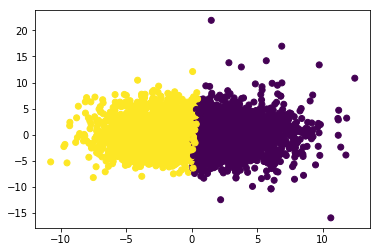

done k:= 3 
PCA:


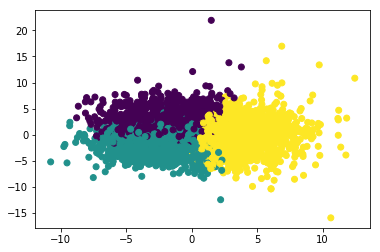

done k:= 4 
PCA:


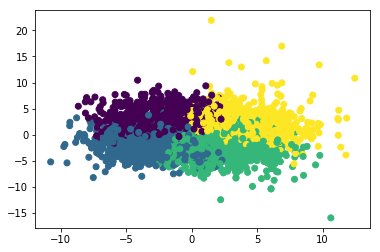

done k:= 5 
PCA:


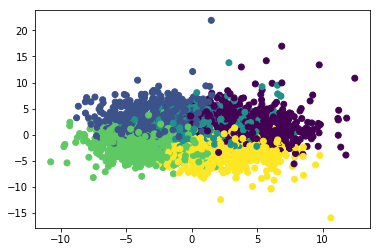

done k:= 6 
PCA:


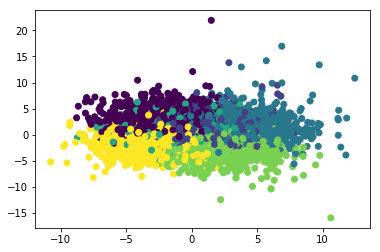

done k:= 7 
PCA:


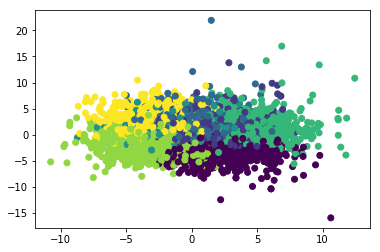

done k:= 8 
PCA:


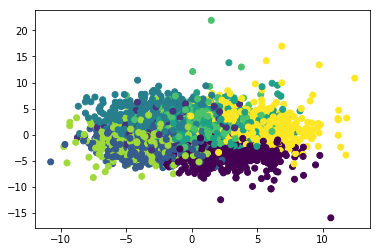

done k:= 9 
PCA:


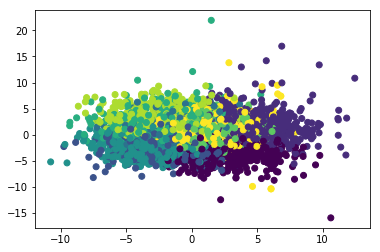

In [190]:
dict_k_vs_loss = {'k':[], 'loss':[]}
predictions_avg_word2vec = []

for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=16)
    predictions_avg_word2vec.append(kmeans.fit_predict(X_avg_word2vec_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))
    print("PCA:")
    plotPCA(X_avg_word2vec_std,predictions_avg_word2vec[k-2])

In [191]:
cluster_distribution(predictions_avg_word2vec)


cluster k=2 :
[2151 2764]

cluster k=3 :
[1377 1782 1756]

cluster k=4 :
[1260 1467 1194  994]

cluster k=5 :
[ 885 1002  704 1348  976]

cluster k=6 :
[ 876  613  812  494  901 1219]

cluster k=7 :
[ 779  542  704  468  633 1141  648]

cluster k=8 :
[706 435 758 578 494 670 650 624]

cluster k=9 :
[590 553 552 418 720 454 656 488 484]


In [192]:
df_k_vs_loss_avg_word2vec = pd.DataFrame(dict_k_vs_loss)

In [193]:
plot_elbow_curve(df_k_vs_loss_avg_word2vec, vector_type='W2V')

AttributeError: module 'seaborn' has no attribute 'lineplot'

<Figure size 1080x432 with 0 Axes>

In [194]:
#elbowUsingSilhoutte(X_avg_word2vec_std,10)

In [195]:
print(len(predictions_avg_word2vec))
print(len(predictions_avg_word2vec[0]))
print(predictions_avg_word2vec)

8
4915
[array([0, 0, 0, ..., 1, 1, 1]), array([2, 0, 2, ..., 1, 0, 1]), array([2, 2, 3, ..., 1, 0, 1]), array([4, 2, 0, ..., 3, 1, 3]), array([4, 1, 2, ..., 5, 0, 5]), array([0, 2, 2, ..., 5, 2, 5]), array([0, 5, 5, ..., 6, 5, 2]), array([8, 6, 6, ..., 2, 5, 2])]


In [196]:
# Suppose k = 8 is optimum

optimimum_k_avg_word2vec = 3
df_sandisk['labels_avg_word2vec'] = predictions_avg_word2vec[(optimimum_k_avg_word2vec-2)]

In [197]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO           NaN  [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO          0mie  [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO           1K3  [0, 0]   
1336617   A3H99DFEG68SR  B007WTAJTO           1m2  [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                reviewText  overall  \
1336614                                         No issues.      4.0   
1336615  Purchased this for my device, it worked as adv...      5.0   
1336616  it works as expected. I should have sprung for...      4.0   
1336617  This think has worked out great.Had a diff. br...      5.0   
1336618  Bought it with Retail Packaging, arrived legit...      5.0   

                                        summary  unixReviewTime   reviewTime  \
1336614                              Four Stars      1406073600  07 23, 2014   
1336615                           MOAR SPACE!!!      1382659200  10 25, 2013   
1336616               nothing to really say....      1356220800  12 23, 2012   
1336617  Great buy at this price!!!  *** UPDATE      1384992000  11 21, 2013   
1336618                        best deal around      1373673600  07 13, 2013   

                                               CleanedText  TotalTechWords  \
1336614                                               issu               0   
1336615  purchas devic work advertis never much phone m...               1   
1336616  work expect sprung higher capac think made bit...               1   
1336617  think work great diff bran gb card went south ...               4   
1336618  bought retail packag arriv legit orang envelop...               3   

         labels_avg_word2vec  
1336614                    2  
1336615                    0  
1336616                    2  
1336617                    2  
1336618                    2

In [198]:
df_sandisk['labels_avg_word2vec'].value_counts()

1    1782
2    1756
0    1377
Name: labels_avg_word2vec, dtype: int64

In [199]:

def plot_elbow_curves(df_loss, vector_type):
    """
    Plot the k(n_clusters) vs loss.
    The definition of the loss function can be found in the image above.
    This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    plt.plot(data=df_loss, x='k',y='loss')
    #plt.margins(1)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [200]:
for i in range(optimimum_k_avg_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i, "TotalTechWords"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == i,'labels_avg_word2vec'].count()
    print(i , ':  ', sumTotal )
    print(i , ':  ', sumTotal / clusterRows)

0 :   3484
0 :   2.530137981118373
1 :   12779
1 :   7.171156004489338
2 :   4208
2 :   2.3963553530751707


### Looks like cluster 2 contains the most intellectual users

In [201]:
pd.options.display.max_rows

60

In [202]:
pd.options.display.max_colwidth

50

In [203]:
pd.set_option('display.max_colwidth', -1)

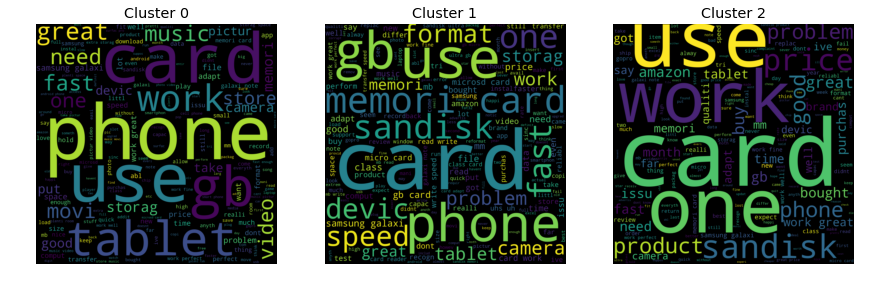

<Figure size 432x288 with 0 Axes>

In [204]:
_ = plot_wordcloud(predictions_avg_word2vec[(optimimum_k_avg_word2vec-2)], df_sandisk, n=1000)

In [205]:
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 2,'CleanedText']

1336614    issu                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1336616    work expect sprung higher capac think made bit cheesier earlier paint look clean                                                                                                                                                                                                                                                                                                                                                                                   
1336617    think work great diff bran gb card went south month one held pr

In [206]:
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 0,'CleanedText']

1336615    purchas devic work advertis never much phone memori sinc download lot stuff brainer                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
1336619    mini storag doesnt anyth els suppos purchas add addit storag microsoft surfac pro tablet come gb suppos sandisk long stand reput speak                                                                                                                                                                                                                                                                                                                   

In [207]:
df_sandisk.loc[df_sandisk['labels_avg_word2vec'] == 1,'CleanedText']

1336622    work htc rezound run short space gb sandisk order came fast issu                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [208]:
X_test = []
kmeans.predict(X_avg_word2vec_std)

array([8, 6, 6, ..., 2, 5, 2])

### 7 clusters have the highest score

In [209]:
#df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

In [210]:
#plot_elbow_curve(df_k_vs_loss, vector_type='W2V')

In [211]:
# kmeans.cluster_centers_

## TF_IDF Word2Vec

In [212]:
"""# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(df['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))"""

'# S = ["abc def pqr", "def def def abc", "pqr pqr def"]\nmodel = TfidfVectorizer()\ntf_idf_matrix = model.fit_transform(df[\'CleanedText\'].values)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary = dict(zip(model.get_feature_names(), list(model.idf_)))'

In [213]:
#saving TFIDFwordtoVec
"""with open('model_tfidf_w2v.pickle', 'wb') as f:
    pickle.dump(tf_idf_matrix, f)
    
with open('dict_tfidf_w2v.pickle', 'wb') as f:
    pickle.dump(dictionary, f)"""


"with open('model_tfidf_w2v.pickle', 'wb') as f:\n    pickle.dump(tf_idf_matrix, f)\n    \nwith open('dict_tfidf_w2v.pickle', 'wb') as f:\n    pickle.dump(dictionary, f)"

In [214]:
#Retrieving TFIDFwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('model_tfidf_w2v.pickle', 'rb') as f:
    tf_idf_matrix = pickle.load(f)
    
with open('dict_tfidf_w2v.pickle', 'rb') as f:
    dictionary = pickle.load(f)    
    
    
print(tf_idf_matrix)

  (0, 113446)	0.06543552031348972
  (0, 113724)	0.10689880576827723
  (0, 127587)	0.12668164648261895
  (0, 192819)	0.24208995932893568
  (0, 232445)	0.11680767979741104
  (0, 287042)	0.4132653563965022
  (0, 130599)	0.18564924993916707
  (0, 244382)	0.08983078187754093
  (0, 280517)	0.05431039996608468
  (0, 16932)	0.09589792376307019
  (0, 66974)	0.07247334056590914
  (0, 82486)	0.12470219166269692
  (0, 92384)	0.07438158088868267
  (0, 310764)	0.19909323374937687
  (0, 305771)	0.0843195060549834
  (0, 295865)	0.07528049804342238
  (0, 126397)	0.07485309713871229
  (0, 259940)	0.07973325244511463
  (0, 105520)	0.26163287050781087
  (0, 61992)	0.06581704831243064
  (0, 111594)	0.1382624562098832
  (0, 292405)	0.14840699803811622
  (0, 312209)	0.11824112138144985
  (0, 114574)	0.09107016048896265
  (0, 183105)	0.09779320399230933
  :	:
  (1689187, 74598)	0.08526490056208678
  (1689187, 113985)	0.07647590536461535
  (1689187, 105625)	0.06514649247917531
  (1689187, 175436)	0.09010331426

In [215]:
# TF-IDF weighted Word2Vec
#tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_tech_words = [];
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_sd): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    tech_tfidf = 0;
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            if word in unigramTechSet:
                tech_tfidf += tf_idf
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    tfidf_tech_words.append(tech_tfidf)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 4915/4915 [00:04<00:00, 1058.90it/s]


In [216]:
#saving TFIDFwordtoVec
"""with open('tfidf_tech_words.pickle', 'wb') as f:
    pickle.dump(tfidf_tech_words, f)"""
    

"with open('tfidf_tech_words.pickle', 'wb') as f:\n    pickle.dump(tfidf_tech_words, f)"

In [217]:
#Retrieving TFIDFwordtoVec
tfidf_tech_words = []; 
with open('tfidf_tech_words.pickle', 'rb') as f:
    tfidf_tech_words = pickle.load(f)
    
print(tfidf_tech_words)

[0, 0.34268643607837024, 0.42342695217535126, 1.1602295620274201, 0.5605591595030217, 1.3391599414011919, 1.1326338230752073, 0.3793152192791688, 0.8366700161098228, 0.2829250587819388, 2.7968245607458018, 3.9149060777500644, 1.9671091423493579, 2.345594545731338, 1.1429397115391513, 1.2029546993958438, 0.5324441270853791, 10.754233364467769, 2.0598757808129498, 0.7029221496369682, 0.7361914585674285, 0.54100568967862, 1.5373584023121718, 3.0208939176913967, 0.3851037368788921, 1.1885079567597556, 1.2147827276998429, 0.544057867416538, 1.174454109815446, 1.4590166385516798, 0.21782698769841058, 1.410988933051479, 1.2391027283360638, 0.9277370758972217, 0.4488346364742749, 2.0282489301666153, 0, 3.085608185341691, 4.039318212012803, 0.3258570081282933, 1.3553506256833157, 0.9615719629432916, 0.7456626635754453, 0.8600872507327292, 0.7625700852094578, 0.29945257331140407, 0.97883360655426, 0.6027039465343355, 0.5195014019047481, 0.13135806300590014, 0.55305850216376, 2.351264320166642, 1

In [218]:
df_sandisk['tech_words_tfidf'] = tfidf_tech_words;

In [219]:
#saving TFIDFwordtoVec
with open('sent_vectors_tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_sent_vectors, f)

In [220]:
#Retrieving TFIDFwordtoVec
#sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
with open('sent_vectors_tfidf.pickle', 'rb') as f:
    tfidf_sent_vectors = pickle.load(f)
    
print(tfidf_sent_vectors)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [221]:
print(len(tfidf_sent_vectors))
print(tfidf_sent_vectors[0])

4915
[ 0.62683418  2.8935956  -0.16636419 -0.77061227 -0.01096752  3.63719129
 -0.557293    1.49304676  1.72335172 -0.98403474  1.11930396 -0.54566187
  1.16893012 -1.42431794 -2.08388566 -0.53042936  1.05230109 -1.25121996
 -2.87727602  2.67584157  1.05996706  0.23263424  3.16750422 -1.6129551
  1.83319707 -0.26969912  1.18622906  0.5105402  -0.65293932  0.23602156
  1.67294612  1.55587088 -1.14006271  3.74987663  4.79241613  2.23710471
  2.31435197  0.69903348 -1.68827876  2.9819399  -1.07257056 -2.60570475
 -0.60529993 -2.68604689  5.00544861 -1.56939525  1.66467955  1.26796474
 -1.68828744 -1.35394069  2.84894534  4.75848126  1.54927961 -1.97853438
  0.9904298   2.00607997 -1.1921361  -0.91718184 -0.23484221 -1.84866763
  3.1976214  -1.98110045  0.33365246  1.65715177  1.0394646  -0.46013244
 -0.57109328 -0.62450592 -0.84296499  4.18349375  0.71365777  3.75276043
 -1.64399831  1.37060169  2.03018264  0.76618792  3.22901692  1.23975737
 -0.35114434  1.70904005 -1.82822985 -1.5413933

In [222]:
X_tfidf_word2vec = np.append(np.asarray(tfidf_sent_vectors),np.asarray(df_sandisk['tech_words_tfidf'])[:, None], 1)
X_tfidf_word2vec

array([[ 0.62683418,  2.8935956 , -0.16636419, ..., -1.93059951,
        -1.25731314,  0.        ],
       [-0.16084341, -0.67639046,  0.01009075, ..., -0.07430024,
        -0.02876555,  0.34268644],
       [ 0.1104335 , -0.13954827, -0.66062016, ..., -0.09510396,
         0.88494481,  0.42342695],
       ...,
       [ 0.20935766, -0.32957937,  0.2387222 , ...,  0.36746824,
         0.12172611,  1.79288795],
       [ 0.81907947, -1.15758589, -0.28846289, ..., -0.0316126 ,
         0.16781348,  0.        ],
       [ 0.45923097, -0.55037975,  1.25722368, ...,  0.30145033,
         0.25670129,  1.15298221]])

In [223]:
scaler_tfidf_word2vec = StandardScaler(with_mean=False)
X_tfidf_word2vec_std = scaler_tfidf_word2vec.fit_transform(X_tfidf_word2vec)

done k:= 2 
PCA:


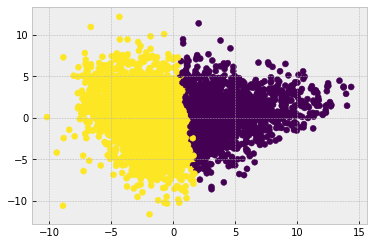

done k:= 3 
PCA:


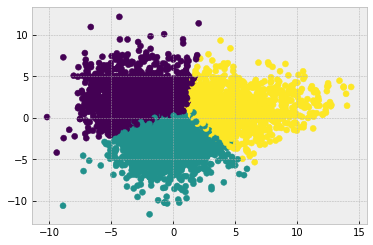

done k:= 4 
PCA:


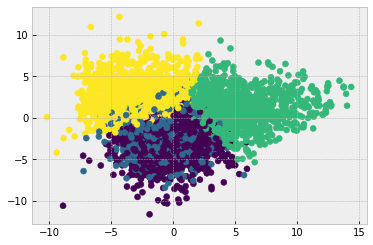

done k:= 5 
PCA:


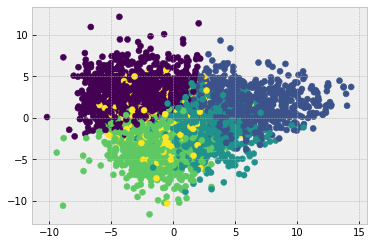

done k:= 6 
PCA:


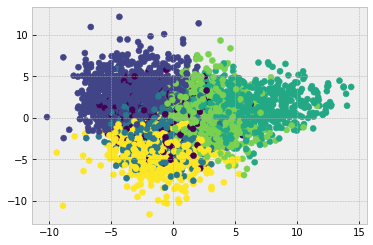

done k:= 7 
PCA:


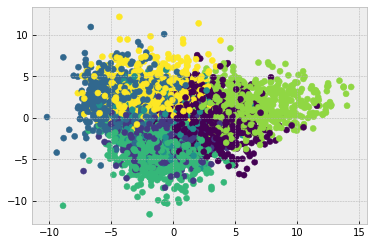

done k:= 8 
PCA:


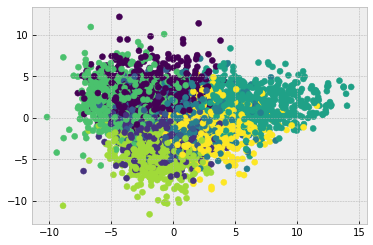

done k:= 9 
PCA:


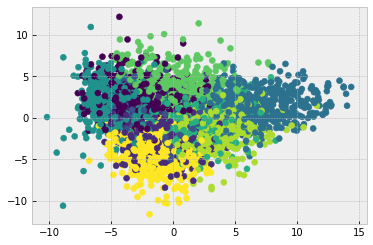

In [224]:
dict_k_vs_loss_tf = {'k':[], 'loss':[]}
predictions_tfidf_word2vec = []
clusters_models = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, n_jobs=16)
    clusters_models.append(kmeans)
    predictions_tfidf_word2vec.append(kmeans.fit_predict(X_tfidf_word2vec_std))
    dict_k_vs_loss_tf['k'].append(k)
    dict_k_vs_loss_tf['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))
    print("PCA:")
    plotPCA(X_tfidf_word2vec_std,predictions_tfidf_word2vec[k-2])

In [225]:
cluster_distribution(predictions_tfidf_word2vec)


cluster k=2 :
[1622 3293]

cluster k=3 :
[1875 1830 1210]

cluster k=4 :
[1426  862 1072 1555]

cluster k=5 :
[1507  695 1082 1150  481]

cluster k=6 :
[ 436 1290  721  595 1004  869]

cluster k=7 :
[910 611 805 406 812 568 803]

cluster k=8 :
[743 570 365 526 540 842 689 640]

cluster k=9 :
[686 512 358 493 674 467 452 606 667]


In [226]:
df_k_vs_loss_tfidf_word2vec = pd.DataFrame(dict_k_vs_loss_tf)

In [227]:
plot_elbow_curve(df_k_vs_loss_tfidf_word2vec, vector_type='TFIDF_W2V')

AttributeError: module 'seaborn' has no attribute 'lineplot'

<Figure size 1080x432 with 0 Axes>

In [228]:
#For nothing

In [229]:
optimimum_k_tfidf_word2vec = 3
df_sandisk['labels_tfidf_word2vec'] = predictions_tfidf_word2vec[(optimimum_k_tfidf_word2vec-2)]

In [230]:
df_sandisk.head()

reviewerID        asin  reviewerName helpful  \
1336614  A3SBTW3WS4IQSN  B007WTAJTO  NaN           [0, 0]   
1336615  A18K1ODH1I2MVB  B007WTAJTO  0mie          [0, 0]   
1336616  A2FII3I2MBMUIA  B007WTAJTO  1K3           [0, 0]   
1336617  A3H99DFEG68SR   B007WTAJTO  1m2           [0, 0]   
1336618  A375ZM4U047O79  B007WTAJTO  2&amp;1/2Men  [0, 0]   

                                                                                                                                                                                                                                                                                                                                                   reviewText  \
1336614  No issues.                                                                                                                                                                                                                                                                                                                                             
1336615  Purchased this for my device, it worked as advertised. You can never have too much phone memory, since I download a lot of stuff this was a no brainer for me.                                                                                                                                                                                         
1336616  it works as expected. I should have sprung for the higher capacity.  I think its made a bit cheesier than the earlier versions; the paint looks not as clean as before                                                                                                                                                                                 
1336617  This think has worked out great.Had a diff. bran 64gb card and if went south after 3 months.This one has held up pretty well since I had my S3, now on my Note3.*** update 3/21/14I've had this for a few months and have had ZERO issue's since it was transferred from my S3 to my Note3 and into a note2. This card is reliable and solid!Cheers!   
1336618  Bought it with Retail Packaging, arrived legit, in a orange envelope, english version not asian like the picture shows. arrived quickly, bought a 32 and 16 both retail packaging for my htc one sv and Lg Optimus, both cards in working order, probably best price you'll get for a nice sd card                                                     

         overall                                 summary  unixReviewTime  \
1336614  4.0      Four Stars                              1406073600       
1336615  5.0      MOAR SPACE!!!                           1382659200       
1336616  4.0      nothing to really say....               1356220800       
1336617  5.0      Great buy at this price!!!  *** UPDATE  1384992000       
1336618  5.0      best deal around                        1373673600       

          reviewTime  \
1336614  07 23, 2014   
1336615  10 25, 2013   
1336616  12 23, 2012   
1336617  11 21, 2013   
1336618  07 13, 2013   

                                                                                                                                                                                           CleanedText  \
1336614  issu                                                                                                                                                                                            
1336615  purchas devic work advertis never much phone memori sinc download lot stuff brainer                                                                                                             
1336616  work expect sprung higher capac think made bit cheesier earlier paint look clean                                                                                                                
1336617  think work great diff bran gb card went south month one held pretti well sinc updat month zero issu sinc tra

In [231]:
df_sandisk['labels_tfidf_word2vec'].value_counts()

0    1875
1    1830
2    1210
Name: labels_tfidf_word2vec, dtype: int64

In [232]:
for i in range(optimimum_k_tfidf_word2vec):
    sumTotal = sum(df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i, "tech_words_tfidf"])
    clusterRows = df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == i,'labels_tfidf_word2vec'].count()
    print(i , ':  ', sumTotal )
    print(i , ':  ', sumTotal / clusterRows)

0 :   1300.6169350928612
0 :   0.6936623653828593
1 :   1576.480204241854
1 :   0.8614645924818873
2 :   3345.123270534306
2 :   2.764564686391988


In [233]:
#_2 = plot_wordcloud(predictions_tfidf_word2vec[(2)], df_sandisk, n=1000)

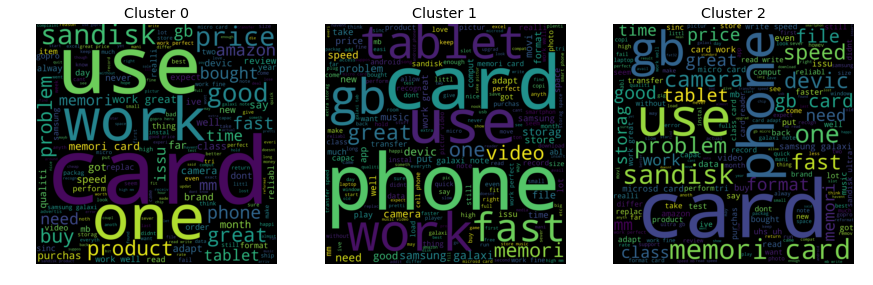

<Figure size 432x288 with 0 Axes>

In [234]:
_ = plot_wordcloud(predictions_tfidf_word2vec[(optimimum_k_tfidf_word2vec-2)], df_sandisk, n=1000)

In [235]:
df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == 2,'CleanedText']

1336624    like card take music video download person video file doc multimedia imag fast transfer rate class speed take game larg file easili still enough space app great video camera camcord suppli adapt fit easili smartphon tablet card slot mm gb card everyon                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [236]:
df_sandisk.loc[df_sandisk['labels_tfidf_word2vec'] == 1,'CleanedText']

1336615    purchas devic work advertis never much phone memori sinc download lot stuff brainer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1336619    mini storag doesnt anyth els suppos purchas add addit storag microsoft surfac pro tablet come gb suppos sandisk long stand reput speak                                                                                                                                                             

# Demo Review

In [243]:
demoReview1 = "My sd card is 16 gb with fast read write speed class about 20 mm"
demoReview2 = "great product"
demoReview3 = "great for my phone "

demoReviews = []
demoReviews.append(demoReview1)
demoReviews.append(demoReview2)
demoReviews.append(demoReview3)


In [244]:
#process input to get right form
tfidf_sum_arr = []
count_tech_all = []
filtered_sentence=[]

for review in demoReviews:
    filtered_sent = []
    count_tech = 0
    tfidf_sum = 0
    for w in review.split():
        w = w.lower()
        for i in bypass:
            if w.find(i) == -1:
                continue
            else:
                w= i
            filtered_sent.append(w)

        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        c = cleaned_words.lower()
                        s=(sno.stem(c))
                        filtered_sent.append(s)
                        if(s in unigramTechSet):
                            count_tech = count_tech + 1;                    
                        if s in dictionary:
                            tfidf_sum += dictionary[word]*(sent.count(word)/len(sent))
                    else:
                        continue
            else:
                    continue
    filtered_sentence.append(filtered_sent)
    tfidf_sum_arr.append(tfidf_sum)
    count_tech_all.append(count_tech)
print(filtered_sentence)

[['card', 'gb', 'fast', 'read', 'write', 'speed', 'class', 'mm'], ['great', 'product'], ['great', 'phone']]


In [245]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors_demo = []; # the tfidf-w2v for each sentence/review is stored in this list


row=0;

for sent in tqdm(filtered_sentence):
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    tech_tfidf = 0;
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_demo.append(sent_vec)
    row += 1
#print(tfidf_sent_vectors_demo)

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.23it/s]


In [246]:
X_test_tfidf_word2vec = np.append(np.asarray(tfidf_sent_vectors_demo),np.asarray(tfidf_sum_arr)[:,None], 1)
#X_test_tfidf_word2vec

In [247]:
#scaler_tfidf_word2vec = StandardScaler(with_mean=False)
tfidf_sent_vectors_demo_std = scaler_tfidf_word2vec.transform(X_test_tfidf_word2vec)

In [248]:
best_k = 3
best_cluster_model = clusters_models[best_k - 2]
#predictions_tfidf_word2vec
labels_predicted_demo = best_cluster_model.predict(X_test_tfidf_word2vec)
print(demoReviews , " belongs to cluster " , labels_predicted_demo)

['My sd card is 16 gb with fast read write speed class about 20 mm', 'great product', 'great for my phone ']  belongs to cluster  [2 0 1]
